In [1]:
import numpy as np
import energyflow
from particle import Particle

import torch
import torch.nn as nn
import torch.nn.functional as F
import pennylane as qml
from torch_geometric.nn import GCNConv, GATConv
from torch.nn import Linear, ReLU, Sigmoid, Tanh, ModuleList, LeakyReLU, Sequential, Dropout
from torch_geometric.nn import global_mean_pool
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import remove_self_loops, add_self_loops, degree
from torch_geometric.data import Data
from torch_geometric.utils import to_networkx
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss
from torch.optim import Adam
from torch_geometric.loader import DataLoader
from tqdm import tqdm

import networkx as nx
import os
import matplotlib.pyplot as plt
import copy
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

### Hyperparameters

In [2]:
n_connections = 3
input_dims = 8
hidden_dims = [8,8]
output_dims = 1
q_depth = 3
epochs = 20
lr = 1e-3
train_ratio = 0.6
val_ratio = 0.2
test_ratio = 0.2
batch_size = 64

In [3]:
path = "C:/Users/HAEMANTH/Documents/Internships/GSoC/"

### Load the dataset

In [4]:
energyflow.qg_jets.load(num_data=10000, pad=True, ncol=4, generator='pythia', with_bc=False, cache_dir='~/data')

(array([[[ 2.68769142e-01,  3.56903171e-01,  4.74138734e+00,
           2.20000000e+01],
         [ 1.60076377e-01, -2.55609533e-01,  4.55022910e+00,
           2.20000000e+01],
         [ 1.14868731e+00, -6.24380156e-02,  4.50385377e+00,
          -2.11000000e+02],
         ...,
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
           0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
           0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
           0.00000000e+00]],
 
        [[ 1.21266321e+00, -1.12853089e-01,  3.04708757e+00,
          -2.11000000e+02],
         [ 2.40893976e-01, -1.67174886e-02,  2.82705667e+00,
           2.20000000e+01],
         [ 1.02778452e-01, -8.58720522e-02,  3.04180579e+00,
           2.20000000e+01],
         ...,
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
           0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
           0.00000

In [4]:
dataset = np.load(os.path.expanduser('~/data/datasets/QG_jets.npz'))

In [5]:
dataset.files

['X', 'y']

In [6]:
X = dataset['X']
y = dataset['y']
X.shape, y.shape

((100000, 139, 4), (100000,))

In [7]:
X.shape

(100000, 139, 4)

In [8]:
y.shape, y.dtype

((100000,), dtype('float64'))

#### Select jets with >= 10 particles

In [9]:
inds10 = np.logical_and(np.sum(X[:,:,0]>1e-10,axis=1)>=10,np.sum(X[:,:,0]>1e-10,axis=1)<=120)

In [10]:
X10 = X[inds10,:,:]
y10 = y[inds10]

In [11]:
X10.shape, y10.shape

((99870, 139, 4), (99870,))

#### Sort by transverse momentum

In [18]:
X_sorted = np.zeros((X10.shape[0], 10, X10.shape[2]))
for i in range(X10.shape[0]):
    sort_nodes = np.argsort(X10[i,:,0])[::-1]
    X_sorted[i,:,:] = X10[i,sort_nodes[:10],:]

In [19]:
X_sorted.shape

(99870, 10, 4)

In [14]:
X_sorted = X_sorted[:,:n_connections,:]
X_sorted.shape

(99870, 3, 4)

In [14]:
pid = Particle.from_pdgid(-2.11000000e+02)
pid.mass, pid.charge

(139.57039, -1.0)

In [15]:
def feature_engineer_dataset(X):
    
    # unpack all features
    pt = X[:,:,0]
    rapidity = X[:,:,1]
    phi = X[:,:,2]
    pdgids = X[:,:,3]

    # Calculate new feature values
    nonzero_pdgids = np.where(pdgids > 0) 
    mass = np.zeros(pdgids.shape)
    mass_nonzeros = np.vectorize(Particle.from_pdgid)(pdgids[nonzero_pdgids])
    mass[nonzero_pdgids] = np.fromiter((i.mass for i in mass_nonzeros), float)

    mt = np.sqrt(np.square(mass) + np.square(pt))
    energy = mass*np.cosh(rapidity) 
    px = pt*np.cos(phi)
    py = pt*np.sin(phi)
    pz = mt*np.sinh(rapidity)
    
    return torch.tensor(np.stack((pt, rapidity, phi, mt, energy, px, py, pz), axis=2), dtype=torch.float)

In [16]:
X_new = feature_engineer_dataset(X_sorted)

In [17]:
X_new.shape

torch.Size([99870, 3, 8])

In [68]:
p = Particle.from_pdgid(2212)
print(p)

p


#### Compute number of useful particles, number of photons, number of charged hadrons, total charge for all jets

In [20]:
num_particles = torch.zeros(X_new.shape[0])
num_photons = torch.zeros(X_new.shape[0])
num_charged_hadrons = torch.zeros(X_new.shape[0])
num_neutral_hadrons = torch.zeros(X_new.shape[0])
num_particles.shape

torch.Size([99870])

In [21]:
inds = np.where(X10[2,:,0] > 1e-10)[0]
inds.shape[0]

57

In [22]:
for i in range(len(X10)):
    inds = np.where(X10[i,:,0] > 1e-10)[0]
    num_particles[i] = inds.shape[0]
    
    num_photons[i] = len(np.where(X10[i,inds,3] == 22)[0])
    
    num_charged_hadrons[i] = len(np.where(np.logical_or((abs(X10[i,inds,3]) == 211), 
                                   (abs(X10[i,inds,3]) == 321), 
                                   (abs(X10[i,inds,3]) == 2212)
                                  ) == True)[0])
    
    
    num_neutral_hadrons[i] = len(np.where(np.logical_or((abs(X[i,inds,3]) == 130), 
                                   (abs(X[i,inds,3]) == 2112)
                                  ) == True)[0])                   # neutral hadron    

In [23]:
pdgids = X10[0,:,3]
nonzero_pdgids = np.where(pdgids > 0) 
nonzero_pdgids

(array([ 0,  1,  5,  6,  7,  8, 10, 11, 12, 13, 14, 15, 16, 17],
       dtype=int64),)

In [24]:
pt = X10[0,nonzero_pdgids,0]
pt.shape, X10.shape

((1, 14), (99870, 139, 4))

In [25]:
pdgids = X10[:,:,3]
nonzero_pdgids = np.where(pdgids > 0) 
mass_nonzeros = np.vectorize(Particle.from_pdgid)(pdgids[nonzero_pdgids])
charge_particles = np.zeros(pdgids.shape)
charge_particles[nonzero_pdgids] = np.fromiter((i.charge if i.charge > 0 else 0 for i in mass_nonzeros), float)
pt = X10[:,:,0]
charge_jet_2 = np.sum(charge_particles * ((pt**0.2)/np.sum(pt)**0.2) , axis=1)
charge_jet_5 = np.sum(charge_particles * ((pt**0.5)/np.sum(pt)**0.5) , axis=1)
charge_jet_7 = np.sum(charge_particles * ((pt**0.7)/np.sum(pt)**0.7) , axis=1)

In [26]:
charge_jet = np.sum(charge_particles, axis=1)
charge_jet.shape

(99870,)

In [27]:
print(charge_jet_2.shape)
charge_jet_2

(99870,)


array([0.07898153, 0.1725243 , 0.52408037, ..., 0.17009737, 0.48479047,
       0.4587912 ])

In [28]:
charge_jet_7

array([2.48108168e-05, 8.78291430e-05, 1.99322411e-04, ...,
       4.69282329e-05, 1.52115589e-04, 2.57501495e-04])

In [29]:
graph_features = torch.stack((num_particles, num_photons, num_charged_hadrons, num_neutral_hadrons, torch.tensor(charge_jet)), dim=1)
graph_features.shape

torch.Size([99870, 5])

In [30]:
graph_features

tensor([[18., 12.,  6.,  0.,  2.],
        [17.,  7.,  8.,  1.,  4.],
        [57., 24., 24.,  6., 13.],
        ...,
        [16.,  6.,  9.,  0.,  5.],
        [88., 55., 26.,  3., 13.],
        [40., 15., 19.,  5., 12.]], dtype=torch.float64)

In [31]:
graph_features_norm = graph_features / torch.amax(graph_features, dim=(0))
graph_features_norm

tensor([[0.1500, 0.1644, 0.0923, 0.0000, 0.0588],
        [0.1417, 0.0959, 0.1231, 0.0909, 0.1176],
        [0.4750, 0.3288, 0.3692, 0.5455, 0.3824],
        ...,
        [0.1333, 0.0822, 0.1385, 0.0000, 0.1471],
        [0.7333, 0.7534, 0.4000, 0.2727, 0.3824],
        [0.3333, 0.2055, 0.2923, 0.4545, 0.3529]], dtype=torch.float64)

In [32]:
graph_features_norm.shape

torch.Size([99870, 5])

#### Normalize the dataset

In [33]:
torch.amax(X_new,dim=(0,1))

tensor([5.0142e+02, 1.9360e+00, 6.5275e+00, 1.0556e+03, 3.2500e+03, 4.9331e+02,
        4.7369e+02, 3.0296e+03])

In [34]:
X_norm = X_new / torch.amax(X_new, dim=(0,1))   
# fetch the maximum value for all feature (in last dimension) and normalize the dataset through max scaling.
X_norm.shape

torch.Size([99870, 3, 8])

In [35]:
def strip_zeros(X):
    X_useful = []
    for Xi in X:
        inds = np.where(Xi[:,0] > 1e-10)
        X_useful.append(Xi[inds])
        
    return X_useful

In [101]:
X_preprocessed = strip_zeros(X_norm)
len(X_preprocessed), X_preprocessed[0].shape, X_preprocessed[1].shape

(100000, torch.Size([18, 8]), torch.Size([17, 8]))

#### Form graph dataset

In [36]:
def create_graph(x):
    M = x.shape[0]  # number of nodes in graph (particles)
    N = M-1         # number of neighbors of each node to be considered for edge connections (1 extra for self loops) 
    # (√N is considered optimal number of neighbors for k-NN on N points)
    edge_index = torch.zeros((2,M*N))   
    edge_attr = torch.zeros((M*N, 1)) 
    # adj_node_pairs = torch.zeros((, ))
    
    for i, features in enumerate(x):
        # find N nearest neighbors in (𝜙,𝑦) space
        distances = torch.sqrt((features[2] - x[:,2])**2 + (features[1] - x[:,1])**2)
        N_nearest = np.argsort(distances)[1:N+1]
        
        edge_index[0][i*N:(i+1)*N] = torch.tensor([i for _ in range(N)])
        edge_index[1][i*N:(i+1)*N] = N_nearest
        edge_attr[i*N:(i+1)*N] = distances[N_nearest].reshape(N,1)   # (max(distances) - distances[N_nearest])/(min(distances[distances > 0]))).reshape(N,    
    
    edge_index = edge_index.to(torch.int)
    return edge_index, edge_attr

In [37]:
def create_graph_dataset(X, y, graph_features):
    dataset = []
        
    for Xi, yi, gi in zip(X,y,graph_features):

        edge_index, edge_attr = create_graph(Xi)            
        data = Data(x=Xi, edge_index=edge_index, edge_attr=edge_attr,y=torch.tensor(yi, dtype=torch.long), graph_features=gi)
        dataset.append(data)
        
    return dataset

In [38]:
dataset = create_graph_dataset(X_norm[:12500, :3, :],y10[:12500], graph_features_norm[:12500])

In [39]:
len(dataset), dataset[0]

(12500,
 Data(x=[3, 8], edge_index=[2, 6], edge_attr=[6, 1], y=1, graph_features=[5]))

In [40]:
dataset[0].edge_index

tensor([[0, 0, 1, 1, 2, 2],
        [1, 2, 0, 2, 1, 0]], dtype=torch.int32)

In [99]:
dataset[0].edge_attr

tensor([[0.1003],
        [0.0997],
        [0.0988],
        [0.0982],
        [0.0973],
        [0.0971],
        [0.0970],
        [0.0959],
        [0.0629],
        [0.1006],
        [0.1000],
        [0.0996],
        [0.0986],
        [0.0976],
        [0.0975],
        [0.0968],
        [0.0960],
        [0.0629],
        [0.1017],
        [0.1006],
        [0.1002],
        [0.0996],
        [0.0988],
        [0.0975],
        [0.0970],
        [0.0960],
        [0.0629],
        [0.0976],
        [0.0962],
        [0.0960],
        [0.0945],
        [0.0944],
        [0.0939],
        [0.0934],
        [0.0913],
        [0.0629],
        [0.0982],
        [0.0950],
        [0.0945],
        [0.0943],
        [0.0942],
        [0.0941],
        [0.0935],
        [0.0922],
        [0.0627],
        [0.1037],
        [0.1015],
        [0.1006],
        [0.1003],
        [0.0986],
        [0.0977],
        [0.0974],
        [0.0959],
        [0.0629],
        [0.0989],
        [0

In [91]:
dataset[0].edge_attr

tensor([[0.0000],
        [0.0006],
        [0.0000],
        [0.0006],
        [0.0000],
        [0.0011]])

In [34]:
dataset[0].edge_attr

tensor([[2.4870],
        [1.4870],
        [1.7354],
        [0.7354],
        [1.4331],
        [0.4331]])

In [79]:
for i in range(8):
    quarks = len([j for j in range(i*12500, (i+1)*12500) if y[j]==1])
    gluons = len([j for j in range(i*12500, (i+1)*12500) if y[j]==0])
    print(i, quarks, gluons)

0 6325 6175
1 6266 6234
2 6247 6253
3 6190 6310
4 6336 6164
5 6170 6330
6 6297 6203
7 6169 6331


In [41]:
batch_size = 64

In [42]:
data_train, data_val, data_test = torch.utils.data.random_split(dataset, [train_ratio, val_ratio, test_ratio])

In [43]:
train_dataloader = DataLoader(data_train,
                              batch_size = batch_size,
                              shuffle=True)
val_dataloader = DataLoader(data_val,
                            batch_size = batch_size,
                            shuffle=True)
test_dataloader = DataLoader(data_test,
                         batch_size = batch_size,
                         shuffle=True)

In [44]:
len(train_dataloader)

118

In [45]:
for batch in train_dataloader:
    print(f"Batch node features shape: {batch.x.shape}")
    print(f"Batch edge indices shape: {batch.edge_index.shape}")
    print(f"Batch edge attributes shape: {batch.edge_attr.shape}")
    print(f"Batch target shape: {batch.y.shape}")
    break


Batch node features shape: torch.Size([192, 8])
Batch edge indices shape: torch.Size([2, 384])
Batch edge attributes shape: torch.Size([384, 1])
Batch target shape: torch.Size([64])


### Train functions

In [46]:
def run_model(model, epoch, loader, lossFn, optimizer, train=True, quantum=False):
    if train:
        model.train()
    else:
        model.eval()
        
    loss = 0
    net_loss = 0
    correct = 0
  
    for batch_idx, data in (tqdm(enumerate(loader)) if train else enumerate(loader)):
        
        target = data.y

        #This will zero out the gradients for this batch. 
        optimizer.zero_grad()

        #Run the model on the train data
        output = model(data.x, data.edge_index.type(torch.int64), data.edge_attr, data.batch, data.graph_features)

        target = target.unsqueeze(1).float()

        # Calculate the loss
        loss = lossFn(output, target)
        net_loss += loss.data * batch_size

        if train:
            #dloss/dx for every Variable 
            loss.backward()

            #to do a one-step update on our parameter.
            optimizer.step()

        pred = (output > 0).float() 
        # since we are working with logits and not probabilities (sigmoid is applied while computing loss), we consider 0 as threshold
        
#         _, pred = torch.max(F.softmax(output,dim=1).data, dim=1)
        correct += (pred == target).sum()
        
        
    acc = correct / len(loader.dataset)
    net_loss /= len(loader.dataset)
      
    if train:
        print('Train', end=" ")
    else:
        print("Val", end=" ")
        
    # Print out the loss
    print('Epoch: {} \tLoss: {:.6f}, Accuracy: {}/{} ({:.0f}%)'.format(
          epoch, net_loss, correct, len(loader.dataset),
          100. * acc))
    
    return net_loss, acc

In [47]:
def train_model(model, optimizer, lossFn, epochs, lr, train_dataloader, val_dataloader):
    
    history = {'train_loss': [],'val_loss':[],'train_acc': [],'val_acc': [] }
    best_model = model
    best_val_loss = 1000

    for epoch in range(epochs):
        train_loss, train_acc = run_model(model, epoch, train_dataloader, lossFn, optimizer)
        val_loss, val_acc = run_model(model, epoch, val_dataloader, lossFn, optimizer, train=False)
        print()

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        if(best_val_loss > val_loss):
            best_val_loss = val_loss
            best_model = model
        
    return history, best_model

In [48]:
def test_eval(model, test_dataloader):
    
    preds = []
    labels = []
    acc = 0
    for data in test_dataloader:

        target = data.y
        labels.append(target.detach().cpu().numpy())
        
        output = model(data.x, data.edge_index.type(torch.int64), data.edge_attr, data.batch, data.graph_features)
        preds.append(output.detach().cpu().numpy())  # Convert to numpy array
        # probs = Sigmoid()(output).detach().cpu().numpy()  # Convert to numpy array
        # preds.append(copy.deepcopy(output))

        target = target.unsqueeze(1).float()    
        pred = (output > 0).float()    
        acc += (pred == target).sum().item()

    acc = acc / len(test_dataloader.dataset)
    print("Test accuracy: ", 100. * acc)
    
    labels = np.concatenate(labels, axis=0)  # Concatenate lists into a single numpy array
    preds = np.concatenate(preds, axis=0)  # Concatenate lists into a single numpy array

    
    return labels, preds

In [49]:
def plot_loss(history, step=2):
    n = len(history['train_loss'])
    x = range(n)
    plt.plot(x, history['train_loss'], label='Train loss')
    plt.plot(x, history['val_loss'], label='Val loss')
    plt.plot(x, history['train_acc'], label='Train acc')
    plt.plot(x, history['val_acc'], label='Val acc')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.xticks(range(0,n,step), range(1,n+1,step))

    plt.legend()
    plt.show()

In [50]:
def plot_auc(model, test_dataloader):
    labels, preds = test_eval(model, test_dataloader)
    auc = roc_auc_score(labels, preds)
    fpr, tpr, _ = roc_curve(labels, preds)
    plt.plot(fpr, tpr, label="AUC = {0}".format(auc))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

In [80]:
example = next(iter(train_dataloader))
example.num_useful_nodes.shape

torch.Size([192])

In [40]:
tensor_a = torch.randn(100, 4)

# Tensor of shape (12500, 1)
tensor_b = torch.randint(0, 10, (100, 1))

# Concatenate along the second dimension (dim=1)
result_tensor = torch.cat((tensor_a, tensor_b), dim=1)

print(result_tensor.shape) 

torch.Size([100, 5])


In [120]:
eg = next(iter(train_dataloader))
eg.x.shape, eg.edge_index.shape, eg.edge_attr.shape, eg.batch.shape, eg.graph_features.shape

(torch.Size([192, 8]),
 torch.Size([2, 384]),
 torch.Size([384, 1]),
 torch.Size([192]),
 torch.Size([320]))

### PyTorch GAT

In [210]:
from torch_geometric.nn import GATConv

In [211]:
class GAT(torch.nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim, activ_fn):
        super().__init__()
        layers = []
        layers.append(GATConv(input_dim, hidden_dims[0], edge_dim=1))
    
        for i in range(len(hidden_dims)-1):
            layers.append(GATConv(hidden_dims[i], hidden_dims[i+1], edge_dim=1))
            
        self.layers = ModuleList(layers)
        self.activ_fn = activ_fn
        self.classifier = Sequential(Linear(hidden_dims[-1]+5, 8),
                                     ReLU(),
#                                      Linear(16, 8),
#                                      ReLU(),
                                     Linear(8, output_dims)
                                    )

    def forward(self, x, edge_index, edge_weight, batch, graph_features):
        h = x
        for i in range(len(self.layers)):
            h = self.layers[i](h, edge_index, edge_weight)
            h = self.activ_fn(h)
         
        h = global_mean_pool(h, batch)   # readout layer to get the embedding for each graph in batch
        h = torch.cat((h, graph_features.float().reshape(-1,5)), dim=1)
        h = self.classifier(h)
        return h

### PyTorch GCN

In [114]:
class GNN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim, activ_fn):
        super().__init__()
        layers = []
        layers.append(GCNConv(input_dim, hidden_dims[0]))
    
        for i in range(len(hidden_dims)-1):
            layers.append(GCNConv(hidden_dims[i], hidden_dims[i+1]))
            
        self.layers = ModuleList(layers)
        self.activ_fn = activ_fn
        self.classifier = Sequential(Linear(hidden_dims[-1]+5, 16),
                                     ReLU(),
                                     Linear(16, 8),
                                     ReLU(),
                                     Linear(8, output_dims)
                                    )

    def forward(self, x, edge_index, edge_weight, batch, graph_features):
        h = x
        for i in range(len(self.layers)):
            h = self.layers[i](h, edge_index, edge_weight)
            h = self.activ_fn(h)
         
        h = global_mean_pool(h, batch)   # readout layer to get the embedding for each graph in batch
        h = torch.cat((h, graph_features.float().reshape(-1,5)), dim=1)
        h = self.classifier(h)
        return h

In [69]:
def find_ideal_particles(X, y, num_particles, min_particles, max_particles):
    train_loss = dict()
    val_loss = dict()
    train_acc = dict()
    val_acc = dict()
    auc = dict()
    
    for i in range(min_particles, max_particles+1):
        
        print("Particles per jet:",i)
        train_loss_i = []
        val_loss_i = []
        train_acc_i = []
        val_acc_i = []
        auc_i = []
        
        for j in range(8):

            X_filtered = X[j*12500:min(len(X), (j+1)*12500), :i, :]
            y_filtered = y[j*12500:min(len(X), (j+1)*12500)]
            num_particles_filtered = num_particles[j*12500:min(len(X), (j+1)*12500)] 
            dataset = create_graph_dataset(X_filtered,y_filtered, num_particles_filtered)

            data_train, data_val, data_test = torch.utils.data.random_split(dataset, [train_ratio, val_ratio, test_ratio])

            train_dataloader = DataLoader(data_train,
                                  batch_size = batch_size,
                                  shuffle=True)
            val_dataloader = DataLoader(data_val,
                                        batch_size = batch_size,
                                        shuffle=True)
            test_dataloader = DataLoader(data_test,
                             batch_size = batch_size,
                             shuffle=True)

            model = GNN(input_dims,hidden_dims,output_dims, activ_fn=ReLU())

            optimizer = Adam(model.parameters(), 1e-2)
            lossFn = BCEWithLogitsLoss()
            history, best_model = train_model(model, optimizer, lossFn, epochs, lr, train_dataloader, val_dataloader)

            ind = np.argmin(history['val_loss'])
            train_loss_i.append(history['train_loss'][ind])
            val_loss_i.append(history['val_loss'][ind])
            train_acc_i.append(history['train_acc'][ind])
            val_acc_i.append(history['val_acc'][ind])

            labels, preds = test_eval(best_model, test_dataloader)
            auc_i.append(roc_auc_score(labels, preds))

            plot_loss(history)
            print("*"*100)
            print()
            
        print()
        print()
            
        train_loss[i] = train_loss_i
        val_loss[i] = val_loss_i
        train_acc[i] = train_acc_i
        val_acc[i] = val_acc_i
        auc[i] = auc_i
        
    return train_loss, val_loss, train_acc, val_acc, auc

#### With all particles, complete graph, edge_weights

In [72]:
hidden_dims = [8,8]
model = GNN(input_dims,hidden_dims,output_dims, activ_fn=ReLU())
model

GNN(
  (layers): ModuleList(
    (0-1): 2 x GCNConv(8, 8)
  )
  (activ_fn): ReLU()
  (classifier): Sequential(
    (0): Linear(in_features=12, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=1, bias=True)
  )
)

In [88]:
epochs = 40
optimizer = Adam(model.parameters(), 1e-2)
lossFn = BCEWithLogitsLoss()
history, best_model = train_model(model, optimizer, lossFn, epochs, lr, train_dataloader, val_dataloader)

118it [00:01, 66.16it/s]


Train Epoch: 0 	Loss: 0.698557, Accuracy: 3758/7500 (50%)
Val Epoch: 0 	Loss: 0.701518, Accuracy: 1266/2500 (51%)



118it [00:01, 70.60it/s]


Train Epoch: 1 	Loss: 0.662718, Accuracy: 5037/7500 (67%)
Val Epoch: 1 	Loss: 0.637884, Accuracy: 1813/2500 (73%)



118it [00:01, 70.56it/s]


Train Epoch: 2 	Loss: 0.598763, Accuracy: 5453/7500 (73%)
Val Epoch: 2 	Loss: 0.574247, Accuracy: 1869/2500 (75%)



118it [00:01, 76.81it/s]


Train Epoch: 3 	Loss: 0.554426, Accuracy: 5681/7500 (76%)
Val Epoch: 3 	Loss: 0.545458, Accuracy: 1910/2500 (76%)



118it [00:01, 105.80it/s]


Train Epoch: 4 	Loss: 0.516734, Accuracy: 5732/7500 (76%)
Val Epoch: 4 	Loss: 0.515224, Accuracy: 1933/2500 (77%)



118it [00:00, 136.60it/s]


Train Epoch: 5 	Loss: 0.495157, Accuracy: 5757/7500 (77%)
Val Epoch: 5 	Loss: 0.508361, Accuracy: 1922/2500 (77%)



118it [00:00, 129.63it/s]


Train Epoch: 6 	Loss: 0.491236, Accuracy: 5788/7500 (77%)
Val Epoch: 6 	Loss: 0.486070, Accuracy: 1930/2500 (77%)



118it [00:00, 131.39it/s]


Train Epoch: 7 	Loss: 0.486512, Accuracy: 5786/7500 (77%)
Val Epoch: 7 	Loss: 0.485602, Accuracy: 1942/2500 (78%)



118it [00:00, 121.45it/s]


Train Epoch: 8 	Loss: 0.485407, Accuracy: 5806/7500 (77%)
Val Epoch: 8 	Loss: 0.497796, Accuracy: 1948/2500 (78%)



118it [00:00, 123.84it/s]


Train Epoch: 9 	Loss: 0.484630, Accuracy: 5792/7500 (77%)
Val Epoch: 9 	Loss: 0.492354, Accuracy: 1946/2500 (78%)



66it [00:00, 119.53it/s]


KeyboardInterrupt: 

Test accuracy:  77.73105036547511


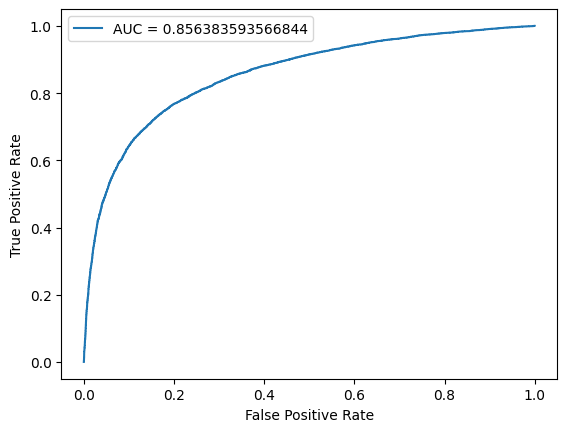

In [136]:
plot_auc(best_model, test_dataloader)

### 100K jets

#### GAT - 5 particles

In [213]:
hidden_dims = [8,8]
model = GAT(input_dims,hidden_dims,output_dims, activ_fn=ReLU())
model

GAT(
  (layers): ModuleList(
    (0-1): 2 x GATConv(8, 8, heads=1)
  )
  (activ_fn): ReLU()
  (classifier): Sequential(
    (0): Linear(in_features=13, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=1, bias=True)
  )
)

In [214]:
epochs = 50
optimizer = Adam(model.parameters(), 1e-3)
lossFn = BCEWithLogitsLoss()
history, best_model = train_model(model, optimizer, lossFn, epochs, lr, train_dataloader, val_dataloader)

469it [00:20, 22.77it/s]


Train Epoch: 0 	Loss: 0.613485, Accuracy: 41525/59922 (69%)
Val Epoch: 0 	Loss: 0.515274, Accuracy: 15405/19974 (77%)



469it [00:21, 21.82it/s]


Train Epoch: 1 	Loss: 0.498130, Accuracy: 46061/59922 (77%)
Val Epoch: 1 	Loss: 0.490772, Accuracy: 15474/19974 (77%)



469it [00:21, 21.36it/s]


Train Epoch: 2 	Loss: 0.489602, Accuracy: 46340/59922 (77%)
Val Epoch: 2 	Loss: 0.485421, Accuracy: 15489/19974 (78%)



469it [00:22, 20.98it/s]


Train Epoch: 3 	Loss: 0.486331, Accuracy: 46376/59922 (77%)
Val Epoch: 3 	Loss: 0.484247, Accuracy: 15521/19974 (78%)



469it [00:21, 21.48it/s]


Train Epoch: 4 	Loss: 0.484642, Accuracy: 46424/59922 (77%)
Val Epoch: 4 	Loss: 0.481393, Accuracy: 15541/19974 (78%)



469it [00:22, 20.56it/s]


Train Epoch: 5 	Loss: 0.484189, Accuracy: 46469/59922 (78%)
Val Epoch: 5 	Loss: 0.481894, Accuracy: 15499/19974 (78%)



469it [00:22, 20.43it/s]


Train Epoch: 6 	Loss: 0.483592, Accuracy: 46407/59922 (77%)
Val Epoch: 6 	Loss: 0.483477, Accuracy: 15555/19974 (78%)



469it [00:22, 20.87it/s]


Train Epoch: 7 	Loss: 0.482897, Accuracy: 46476/59922 (78%)
Val Epoch: 7 	Loss: 0.480599, Accuracy: 15530/19974 (78%)



469it [00:22, 20.69it/s]


Train Epoch: 8 	Loss: 0.483413, Accuracy: 46452/59922 (78%)
Val Epoch: 8 	Loss: 0.481068, Accuracy: 15552/19974 (78%)



469it [00:22, 21.16it/s]


Train Epoch: 9 	Loss: 0.482715, Accuracy: 46450/59922 (78%)
Val Epoch: 9 	Loss: 0.482546, Accuracy: 15551/19974 (78%)



469it [00:23, 20.25it/s]


Train Epoch: 10 	Loss: 0.482397, Accuracy: 46473/59922 (78%)
Val Epoch: 10 	Loss: 0.479346, Accuracy: 15546/19974 (78%)



469it [00:24, 18.81it/s]


Train Epoch: 11 	Loss: 0.482196, Accuracy: 46492/59922 (78%)
Val Epoch: 11 	Loss: 0.479538, Accuracy: 15545/19974 (78%)



469it [00:23, 20.02it/s]


Train Epoch: 12 	Loss: 0.481815, Accuracy: 46483/59922 (78%)
Val Epoch: 12 	Loss: 0.481093, Accuracy: 15532/19974 (78%)



469it [00:22, 20.42it/s]


Train Epoch: 13 	Loss: 0.481846, Accuracy: 46488/59922 (78%)
Val Epoch: 13 	Loss: 0.480746, Accuracy: 15556/19974 (78%)



469it [00:23, 20.19it/s]


Train Epoch: 14 	Loss: 0.481432, Accuracy: 46496/59922 (78%)
Val Epoch: 14 	Loss: 0.480059, Accuracy: 15549/19974 (78%)



469it [00:22, 20.43it/s]


Train Epoch: 15 	Loss: 0.482199, Accuracy: 46482/59922 (78%)
Val Epoch: 15 	Loss: 0.481116, Accuracy: 15549/19974 (78%)



469it [00:22, 20.40it/s]


Train Epoch: 16 	Loss: 0.481472, Accuracy: 46504/59922 (78%)
Val Epoch: 16 	Loss: 0.481916, Accuracy: 15533/19974 (78%)



469it [00:22, 20.47it/s]


Train Epoch: 17 	Loss: 0.481529, Accuracy: 46503/59922 (78%)
Val Epoch: 17 	Loss: 0.480717, Accuracy: 15561/19974 (78%)



469it [00:22, 20.65it/s]


Train Epoch: 18 	Loss: 0.480743, Accuracy: 46543/59922 (78%)
Val Epoch: 18 	Loss: 0.479509, Accuracy: 15555/19974 (78%)



469it [00:23, 20.26it/s]


Train Epoch: 19 	Loss: 0.480898, Accuracy: 46511/59922 (78%)
Val Epoch: 19 	Loss: 0.479391, Accuracy: 15554/19974 (78%)



469it [00:22, 20.53it/s]


Train Epoch: 20 	Loss: 0.480285, Accuracy: 46573/59922 (78%)
Val Epoch: 20 	Loss: 0.480617, Accuracy: 15537/19974 (78%)



469it [00:23, 20.07it/s]


Train Epoch: 21 	Loss: 0.480642, Accuracy: 46547/59922 (78%)
Val Epoch: 21 	Loss: 0.478156, Accuracy: 15591/19974 (78%)



469it [00:22, 20.74it/s]


Train Epoch: 22 	Loss: 0.479626, Accuracy: 46534/59922 (78%)
Val Epoch: 22 	Loss: 0.477844, Accuracy: 15579/19974 (78%)



469it [00:23, 20.09it/s]


Train Epoch: 23 	Loss: 0.479492, Accuracy: 46551/59922 (78%)
Val Epoch: 23 	Loss: 0.477326, Accuracy: 15577/19974 (78%)



469it [00:23, 19.86it/s]


Train Epoch: 24 	Loss: 0.479263, Accuracy: 46574/59922 (78%)
Val Epoch: 24 	Loss: 0.476110, Accuracy: 15582/19974 (78%)



469it [00:23, 20.18it/s]


Train Epoch: 25 	Loss: 0.478903, Accuracy: 46586/59922 (78%)
Val Epoch: 25 	Loss: 0.479825, Accuracy: 15591/19974 (78%)



469it [00:23, 20.11it/s]


Train Epoch: 26 	Loss: 0.478830, Accuracy: 46606/59922 (78%)
Val Epoch: 26 	Loss: 0.478589, Accuracy: 15608/19974 (78%)



469it [00:23, 19.89it/s]


Train Epoch: 27 	Loss: 0.478479, Accuracy: 46631/59922 (78%)
Val Epoch: 27 	Loss: 0.476939, Accuracy: 15598/19974 (78%)



469it [00:23, 20.26it/s]


Train Epoch: 28 	Loss: 0.478003, Accuracy: 46584/59922 (78%)
Val Epoch: 28 	Loss: 0.475921, Accuracy: 15615/19974 (78%)



469it [00:23, 19.70it/s]


Train Epoch: 29 	Loss: 0.477491, Accuracy: 46614/59922 (78%)
Val Epoch: 29 	Loss: 0.474756, Accuracy: 15614/19974 (78%)



469it [00:22, 20.66it/s]


Train Epoch: 30 	Loss: 0.477096, Accuracy: 46615/59922 (78%)
Val Epoch: 30 	Loss: 0.475077, Accuracy: 15612/19974 (78%)



469it [00:23, 19.86it/s]


Train Epoch: 31 	Loss: 0.477571, Accuracy: 46568/59922 (78%)
Val Epoch: 31 	Loss: 0.474225, Accuracy: 15633/19974 (78%)



469it [00:24, 19.41it/s]


Train Epoch: 32 	Loss: 0.476654, Accuracy: 46661/59922 (78%)
Val Epoch: 32 	Loss: 0.477056, Accuracy: 15613/19974 (78%)



469it [00:22, 20.55it/s]


Train Epoch: 33 	Loss: 0.476683, Accuracy: 46647/59922 (78%)
Val Epoch: 33 	Loss: 0.478475, Accuracy: 15585/19974 (78%)



469it [00:23, 20.18it/s]


Train Epoch: 34 	Loss: 0.476168, Accuracy: 46618/59922 (78%)
Val Epoch: 34 	Loss: 0.474830, Accuracy: 15638/19974 (78%)



469it [00:20, 22.36it/s]


Train Epoch: 35 	Loss: 0.475868, Accuracy: 46690/59922 (78%)
Val Epoch: 35 	Loss: 0.474316, Accuracy: 15599/19974 (78%)



469it [00:16, 29.15it/s]


Train Epoch: 36 	Loss: 0.475580, Accuracy: 46705/59922 (78%)
Val Epoch: 36 	Loss: 0.478756, Accuracy: 15589/19974 (78%)



469it [00:14, 33.27it/s]


Train Epoch: 37 	Loss: 0.475535, Accuracy: 46669/59922 (78%)
Val Epoch: 37 	Loss: 0.475474, Accuracy: 15641/19974 (78%)



469it [00:08, 54.64it/s]


Train Epoch: 38 	Loss: 0.475776, Accuracy: 46691/59922 (78%)
Val Epoch: 38 	Loss: 0.473618, Accuracy: 15638/19974 (78%)



469it [00:13, 35.62it/s]


Train Epoch: 39 	Loss: 0.475310, Accuracy: 46666/59922 (78%)
Val Epoch: 39 	Loss: 0.473178, Accuracy: 15635/19974 (78%)



469it [00:13, 35.09it/s]


Train Epoch: 40 	Loss: 0.475345, Accuracy: 46713/59922 (78%)
Val Epoch: 40 	Loss: 0.474614, Accuracy: 15630/19974 (78%)



469it [00:20, 22.47it/s]


Train Epoch: 41 	Loss: 0.474983, Accuracy: 46703/59922 (78%)
Val Epoch: 41 	Loss: 0.473736, Accuracy: 15644/19974 (78%)



469it [00:18, 25.15it/s]


Train Epoch: 42 	Loss: 0.474792, Accuracy: 46700/59922 (78%)
Val Epoch: 42 	Loss: 0.473370, Accuracy: 15646/19974 (78%)



469it [00:15, 29.43it/s]


Train Epoch: 43 	Loss: 0.474587, Accuracy: 46756/59922 (78%)
Val Epoch: 43 	Loss: 0.475479, Accuracy: 15646/19974 (78%)



469it [00:22, 20.47it/s]


Train Epoch: 44 	Loss: 0.474305, Accuracy: 46728/59922 (78%)
Val Epoch: 44 	Loss: 0.476723, Accuracy: 15654/19974 (78%)



469it [00:18, 25.33it/s]


Train Epoch: 45 	Loss: 0.474485, Accuracy: 46678/59922 (78%)
Val Epoch: 45 	Loss: 0.478205, Accuracy: 15621/19974 (78%)



469it [00:29, 15.86it/s]


Train Epoch: 46 	Loss: 0.474562, Accuracy: 46719/59922 (78%)
Val Epoch: 46 	Loss: 0.472746, Accuracy: 15643/19974 (78%)



469it [00:20, 22.49it/s]


Train Epoch: 47 	Loss: 0.474214, Accuracy: 46719/59922 (78%)
Val Epoch: 47 	Loss: 0.476842, Accuracy: 15611/19974 (78%)



469it [00:14, 32.28it/s]


Train Epoch: 48 	Loss: 0.474301, Accuracy: 46751/59922 (78%)
Val Epoch: 48 	Loss: 0.475083, Accuracy: 15641/19974 (78%)



469it [00:17, 26.95it/s]


Train Epoch: 49 	Loss: 0.473668, Accuracy: 46720/59922 (78%)
Val Epoch: 49 	Loss: 0.475211, Accuracy: 15644/19974 (78%)



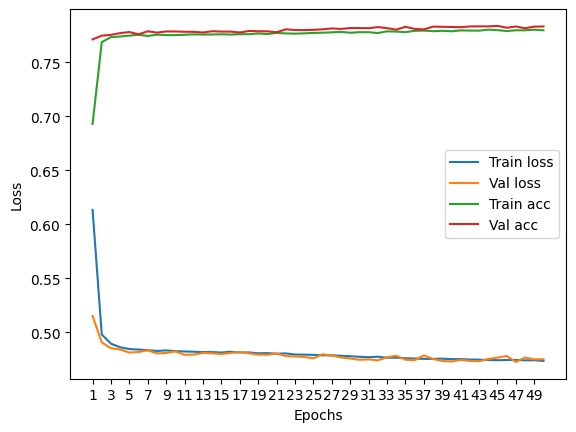

In [215]:
plot_loss(history)

Test accuracy:  77.17532792630419


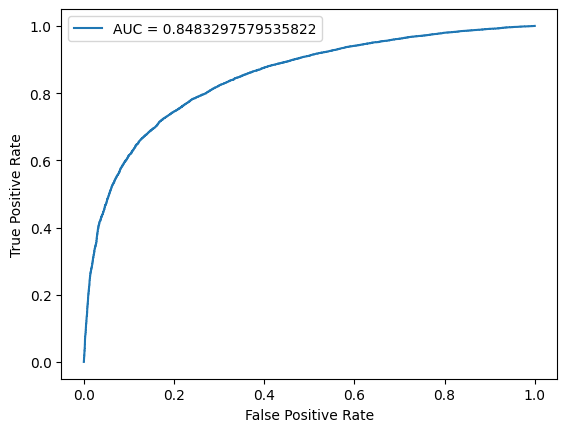

In [216]:
plot_auc(best_model, test_dataloader)

#### GAT - With 5 particles, edge_weights, (total particles, photon, charged hadron, neutral hadron, charge of jet with k = 0.2, 0.5, 0.7) count

In [116]:
input_dims = 8
hidden_dims = [8,8]
model = GAT(input_dims,hidden_dims,output_dims, activ_fn=ReLU())
model

GAT(
  (layers): ModuleList(
    (0-1): 2 x GATConv(8, 8, heads=1)
  )
  (activ_fn): ReLU()
  (classifier): Sequential(
    (0): Linear(in_features=15, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=1, bias=True)
  )
)

In [117]:
epochs = 50
optimizer = Adam(model.parameters(), 1e-3)
lossFn = BCEWithLogitsLoss()
history, best_model = train_model(model, optimizer, lossFn, epochs, lr, train_dataloader, val_dataloader)

118it [00:01, 64.49it/s]


Train Epoch: 0 	Loss: 0.686021, Accuracy: 4737/7500 (63%)
Val Epoch: 0 	Loss: 0.684530, Accuracy: 1741/2500 (70%)



118it [00:01, 60.21it/s]


Train Epoch: 1 	Loss: 0.658967, Accuracy: 5352/7500 (71%)
Val Epoch: 1 	Loss: 0.648924, Accuracy: 1894/2500 (76%)



118it [00:01, 60.47it/s]


Train Epoch: 2 	Loss: 0.616825, Accuracy: 5631/7500 (75%)
Val Epoch: 2 	Loss: 0.598189, Accuracy: 1879/2500 (75%)



118it [00:01, 59.27it/s]


Train Epoch: 3 	Loss: 0.563784, Accuracy: 5732/7500 (76%)
Val Epoch: 3 	Loss: 0.546261, Accuracy: 1958/2500 (78%)



118it [00:02, 52.24it/s]


Train Epoch: 4 	Loss: 0.524339, Accuracy: 5742/7500 (77%)
Val Epoch: 4 	Loss: 0.514191, Accuracy: 1960/2500 (78%)



118it [00:01, 76.52it/s]


Train Epoch: 5 	Loss: 0.506530, Accuracy: 5776/7500 (77%)
Val Epoch: 5 	Loss: 0.496887, Accuracy: 1959/2500 (78%)



118it [00:01, 72.13it/s]


Train Epoch: 6 	Loss: 0.500158, Accuracy: 5783/7500 (77%)
Val Epoch: 6 	Loss: 0.510235, Accuracy: 1955/2500 (78%)



118it [00:01, 81.37it/s]


Train Epoch: 7 	Loss: 0.496915, Accuracy: 5778/7500 (77%)
Val Epoch: 7 	Loss: 0.495451, Accuracy: 1956/2500 (78%)



118it [00:01, 71.23it/s]


Train Epoch: 8 	Loss: 0.493624, Accuracy: 5775/7500 (77%)
Val Epoch: 8 	Loss: 0.502586, Accuracy: 1955/2500 (78%)



118it [00:01, 74.56it/s]


Train Epoch: 9 	Loss: 0.495615, Accuracy: 5804/7500 (77%)
Val Epoch: 9 	Loss: 0.518696, Accuracy: 1963/2500 (79%)



118it [00:01, 84.34it/s]


Train Epoch: 10 	Loss: 0.494836, Accuracy: 5795/7500 (77%)
Val Epoch: 10 	Loss: 0.495251, Accuracy: 1962/2500 (78%)



118it [00:01, 86.50it/s]


Train Epoch: 11 	Loss: 0.492540, Accuracy: 5788/7500 (77%)
Val Epoch: 11 	Loss: 0.495857, Accuracy: 1964/2500 (79%)



118it [00:01, 84.62it/s]


Train Epoch: 12 	Loss: 0.491353, Accuracy: 5811/7500 (77%)
Val Epoch: 12 	Loss: 0.496157, Accuracy: 1938/2500 (78%)



118it [00:01, 74.29it/s]


Train Epoch: 13 	Loss: 0.490998, Accuracy: 5786/7500 (77%)
Val Epoch: 13 	Loss: 0.500981, Accuracy: 1934/2500 (77%)



118it [00:02, 57.87it/s]


Train Epoch: 14 	Loss: 0.491629, Accuracy: 5794/7500 (77%)
Val Epoch: 14 	Loss: 0.503641, Accuracy: 1962/2500 (78%)



118it [00:01, 65.58it/s]


Train Epoch: 15 	Loss: 0.492204, Accuracy: 5787/7500 (77%)
Val Epoch: 15 	Loss: 0.492672, Accuracy: 1941/2500 (78%)



118it [00:01, 72.59it/s]


Train Epoch: 16 	Loss: 0.490911, Accuracy: 5798/7500 (77%)
Val Epoch: 16 	Loss: 0.511580, Accuracy: 1923/2500 (77%)



118it [00:01, 68.33it/s]


Train Epoch: 17 	Loss: 0.491473, Accuracy: 5789/7500 (77%)
Val Epoch: 17 	Loss: 0.491214, Accuracy: 1963/2500 (79%)



118it [00:01, 67.71it/s]


Train Epoch: 18 	Loss: 0.492077, Accuracy: 5797/7500 (77%)
Val Epoch: 18 	Loss: 0.490608, Accuracy: 1953/2500 (78%)



118it [00:01, 68.15it/s]


Train Epoch: 19 	Loss: 0.490158, Accuracy: 5803/7500 (77%)
Val Epoch: 19 	Loss: 0.489131, Accuracy: 1965/2500 (79%)



118it [00:01, 77.31it/s]


Train Epoch: 20 	Loss: 0.490469, Accuracy: 5805/7500 (77%)
Val Epoch: 20 	Loss: 0.500512, Accuracy: 1959/2500 (78%)



118it [00:01, 63.80it/s]


Train Epoch: 21 	Loss: 0.489991, Accuracy: 5798/7500 (77%)
Val Epoch: 21 	Loss: 0.523574, Accuracy: 1956/2500 (78%)



118it [00:02, 54.06it/s]


Train Epoch: 22 	Loss: 0.490759, Accuracy: 5809/7500 (77%)
Val Epoch: 22 	Loss: 0.497075, Accuracy: 1965/2500 (79%)



118it [00:01, 70.47it/s]


Train Epoch: 23 	Loss: 0.490968, Accuracy: 5801/7500 (77%)
Val Epoch: 23 	Loss: 0.513020, Accuracy: 1961/2500 (78%)



118it [00:01, 70.52it/s]


Train Epoch: 24 	Loss: 0.491407, Accuracy: 5795/7500 (77%)
Val Epoch: 24 	Loss: 0.496537, Accuracy: 1962/2500 (78%)



118it [00:01, 71.71it/s]


Train Epoch: 25 	Loss: 0.491457, Accuracy: 5795/7500 (77%)
Val Epoch: 25 	Loss: 0.500533, Accuracy: 1955/2500 (78%)



118it [00:02, 56.03it/s]


Train Epoch: 26 	Loss: 0.491600, Accuracy: 5794/7500 (77%)
Val Epoch: 26 	Loss: 0.494258, Accuracy: 1965/2500 (79%)



118it [00:01, 83.27it/s]


Train Epoch: 27 	Loss: 0.491609, Accuracy: 5779/7500 (77%)
Val Epoch: 27 	Loss: 0.493297, Accuracy: 1952/2500 (78%)



118it [00:01, 68.26it/s]


Train Epoch: 28 	Loss: 0.490929, Accuracy: 5801/7500 (77%)
Val Epoch: 28 	Loss: 0.490775, Accuracy: 1958/2500 (78%)



118it [00:01, 67.66it/s]


Train Epoch: 29 	Loss: 0.489238, Accuracy: 5800/7500 (77%)
Val Epoch: 29 	Loss: 0.497249, Accuracy: 1958/2500 (78%)



118it [00:02, 56.32it/s]


Train Epoch: 30 	Loss: 0.490004, Accuracy: 5791/7500 (77%)
Val Epoch: 30 	Loss: 0.488094, Accuracy: 1963/2500 (79%)



118it [00:01, 66.95it/s]


Train Epoch: 31 	Loss: 0.491168, Accuracy: 5812/7500 (77%)
Val Epoch: 31 	Loss: 0.496628, Accuracy: 1946/2500 (78%)



118it [00:01, 73.96it/s]


Train Epoch: 32 	Loss: 0.488646, Accuracy: 5798/7500 (77%)
Val Epoch: 32 	Loss: 0.513928, Accuracy: 1962/2500 (78%)



118it [00:01, 70.38it/s]


Train Epoch: 33 	Loss: 0.491555, Accuracy: 5803/7500 (77%)
Val Epoch: 33 	Loss: 0.501996, Accuracy: 1958/2500 (78%)



118it [00:01, 72.69it/s]


Train Epoch: 34 	Loss: 0.491496, Accuracy: 5791/7500 (77%)
Val Epoch: 34 	Loss: 0.495320, Accuracy: 1966/2500 (79%)



118it [00:01, 75.38it/s]


Train Epoch: 35 	Loss: 0.491025, Accuracy: 5780/7500 (77%)
Val Epoch: 35 	Loss: 0.516928, Accuracy: 1961/2500 (78%)



118it [00:02, 52.46it/s]


Train Epoch: 36 	Loss: 0.490847, Accuracy: 5791/7500 (77%)
Val Epoch: 36 	Loss: 0.501201, Accuracy: 1955/2500 (78%)



118it [00:01, 71.79it/s]


Train Epoch: 37 	Loss: 0.491389, Accuracy: 5797/7500 (77%)
Val Epoch: 37 	Loss: 0.491841, Accuracy: 1955/2500 (78%)



118it [00:01, 73.48it/s]


Train Epoch: 38 	Loss: 0.489153, Accuracy: 5808/7500 (77%)
Val Epoch: 38 	Loss: 0.491316, Accuracy: 1956/2500 (78%)



118it [00:01, 71.27it/s]


Train Epoch: 39 	Loss: 0.488669, Accuracy: 5803/7500 (77%)
Val Epoch: 39 	Loss: 0.507509, Accuracy: 1950/2500 (78%)



118it [00:01, 66.47it/s]


Train Epoch: 40 	Loss: 0.491565, Accuracy: 5777/7500 (77%)
Val Epoch: 40 	Loss: 0.494215, Accuracy: 1934/2500 (77%)



118it [00:01, 72.42it/s]


Train Epoch: 41 	Loss: 0.490229, Accuracy: 5798/7500 (77%)
Val Epoch: 41 	Loss: 0.512541, Accuracy: 1962/2500 (78%)



118it [00:01, 85.80it/s]


Train Epoch: 42 	Loss: 0.492499, Accuracy: 5796/7500 (77%)
Val Epoch: 42 	Loss: 0.493773, Accuracy: 1946/2500 (78%)



118it [00:01, 73.60it/s]


Train Epoch: 43 	Loss: 0.491144, Accuracy: 5781/7500 (77%)
Val Epoch: 43 	Loss: 0.496098, Accuracy: 1958/2500 (78%)



118it [00:01, 75.66it/s]


Train Epoch: 44 	Loss: 0.489180, Accuracy: 5801/7500 (77%)
Val Epoch: 44 	Loss: 0.499658, Accuracy: 1966/2500 (79%)



118it [00:01, 85.96it/s]


Train Epoch: 45 	Loss: 0.488689, Accuracy: 5796/7500 (77%)
Val Epoch: 45 	Loss: 0.491563, Accuracy: 1953/2500 (78%)



118it [00:01, 82.51it/s]


Train Epoch: 46 	Loss: 0.487570, Accuracy: 5776/7500 (77%)
Val Epoch: 46 	Loss: 0.504904, Accuracy: 1959/2500 (78%)



118it [00:01, 84.77it/s]


Train Epoch: 47 	Loss: 0.487756, Accuracy: 5804/7500 (77%)
Val Epoch: 47 	Loss: 0.500567, Accuracy: 1946/2500 (78%)



118it [00:01, 84.26it/s]


Train Epoch: 48 	Loss: 0.489368, Accuracy: 5802/7500 (77%)
Val Epoch: 48 	Loss: 0.504492, Accuracy: 1956/2500 (78%)



118it [00:01, 84.24it/s]


Train Epoch: 49 	Loss: 0.489822, Accuracy: 5796/7500 (77%)
Val Epoch: 49 	Loss: 0.490107, Accuracy: 1949/2500 (78%)



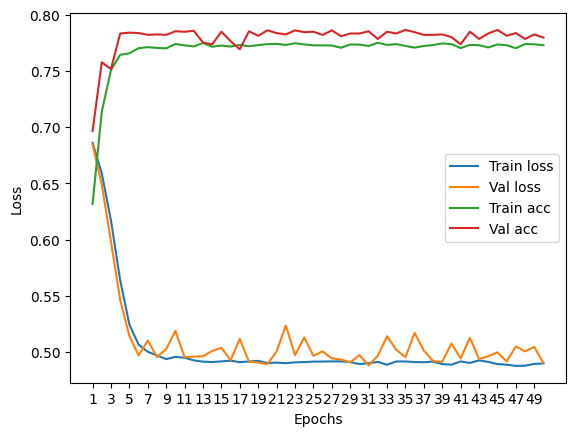

In [118]:
plot_loss(history)

Test accuracy:  76.55999999999999


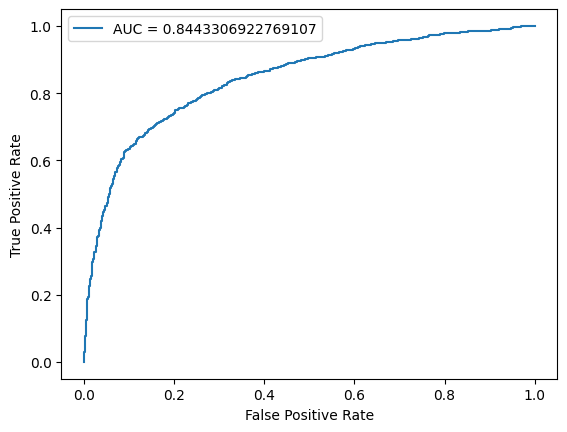

In [119]:
plot_auc(best_model, test_dataloader)

### 12500 jets

#### With 10 particles, charge, complete graph, edge_weights, (photon, CH, NH) count

In [108]:
input_dims = 9
hidden_dims = [9, 9]
model = GNN(input_dims,hidden_dims,output_dims, activ_fn=ReLU())
model

GNN(
  (layers): ModuleList(
    (0-1): 2 x GCNConv(9, 9)
  )
  (activ_fn): ReLU()
  (classifier): Sequential(
    (0): Linear(in_features=12, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=1, bias=True)
  )
)

In [109]:
epochs = 40
optimizer = Adam(model.parameters(), 1e-2)
lossFn = BCEWithLogitsLoss()
history, best_model = train_model(model, optimizer, lossFn, epochs, lr, train_dataloader, val_dataloader)

118it [00:03, 36.78it/s]


Train Epoch: 0 	Loss: 0.555826, Accuracy: 5415/7500 (72%)
Val Epoch: 0 	Loss: 0.497916, Accuracy: 1912/2500 (76%)



118it [00:02, 40.33it/s]


Train Epoch: 1 	Loss: 0.488436, Accuracy: 5779/7500 (77%)
Val Epoch: 1 	Loss: 0.497270, Accuracy: 1926/2500 (77%)



118it [00:02, 51.81it/s]


Train Epoch: 2 	Loss: 0.488584, Accuracy: 5788/7500 (77%)
Val Epoch: 2 	Loss: 0.487464, Accuracy: 1934/2500 (77%)



118it [00:02, 51.27it/s]


Train Epoch: 3 	Loss: 0.485599, Accuracy: 5784/7500 (77%)
Val Epoch: 3 	Loss: 0.510941, Accuracy: 1895/2500 (76%)



118it [00:02, 44.06it/s]


Train Epoch: 4 	Loss: 0.488502, Accuracy: 5766/7500 (77%)
Val Epoch: 4 	Loss: 0.502689, Accuracy: 1906/2500 (76%)



118it [00:02, 49.06it/s]


Train Epoch: 5 	Loss: 0.486104, Accuracy: 5802/7500 (77%)
Val Epoch: 5 	Loss: 0.488566, Accuracy: 1909/2500 (76%)



118it [00:01, 78.51it/s]


Train Epoch: 6 	Loss: 0.484846, Accuracy: 5787/7500 (77%)
Val Epoch: 6 	Loss: 0.507668, Accuracy: 1915/2500 (77%)



118it [00:01, 82.50it/s]


Train Epoch: 7 	Loss: 0.486948, Accuracy: 5786/7500 (77%)
Val Epoch: 7 	Loss: 0.496342, Accuracy: 1928/2500 (77%)



118it [00:01, 78.90it/s]


Train Epoch: 8 	Loss: 0.489360, Accuracy: 5793/7500 (77%)
Val Epoch: 8 	Loss: 0.499380, Accuracy: 1943/2500 (78%)



118it [00:01, 79.17it/s]


Train Epoch: 9 	Loss: 0.483617, Accuracy: 5782/7500 (77%)
Val Epoch: 9 	Loss: 0.505572, Accuracy: 1918/2500 (77%)



118it [00:01, 81.68it/s]


Train Epoch: 10 	Loss: 0.486195, Accuracy: 5806/7500 (77%)
Val Epoch: 10 	Loss: 0.485380, Accuracy: 1937/2500 (77%)



118it [00:02, 54.68it/s]


Train Epoch: 11 	Loss: 0.482514, Accuracy: 5799/7500 (77%)
Val Epoch: 11 	Loss: 0.505618, Accuracy: 1903/2500 (76%)



118it [00:01, 61.00it/s]


Train Epoch: 12 	Loss: 0.484329, Accuracy: 5814/7500 (78%)
Val Epoch: 12 	Loss: 0.492114, Accuracy: 1930/2500 (77%)



118it [00:01, 76.93it/s]


Train Epoch: 13 	Loss: 0.482823, Accuracy: 5800/7500 (77%)
Val Epoch: 13 	Loss: 0.491083, Accuracy: 1939/2500 (78%)



118it [00:01, 76.88it/s]


Train Epoch: 14 	Loss: 0.484418, Accuracy: 5778/7500 (77%)
Val Epoch: 14 	Loss: 0.504206, Accuracy: 1907/2500 (76%)



118it [00:02, 56.87it/s]


Train Epoch: 15 	Loss: 0.483147, Accuracy: 5788/7500 (77%)
Val Epoch: 15 	Loss: 0.487000, Accuracy: 1940/2500 (78%)



118it [00:01, 69.98it/s]


Train Epoch: 16 	Loss: 0.483765, Accuracy: 5802/7500 (77%)
Val Epoch: 16 	Loss: 0.497930, Accuracy: 1935/2500 (77%)



118it [00:01, 65.64it/s]


Train Epoch: 17 	Loss: 0.483942, Accuracy: 5816/7500 (78%)
Val Epoch: 17 	Loss: 0.489233, Accuracy: 1931/2500 (77%)



118it [00:01, 60.11it/s]


Train Epoch: 18 	Loss: 0.482807, Accuracy: 5826/7500 (78%)
Val Epoch: 18 	Loss: 0.489371, Accuracy: 1919/2500 (77%)



118it [00:02, 52.44it/s]


Train Epoch: 19 	Loss: 0.483620, Accuracy: 5812/7500 (77%)
Val Epoch: 19 	Loss: 0.530022, Accuracy: 1910/2500 (76%)



118it [00:02, 52.49it/s]


Train Epoch: 20 	Loss: 0.488522, Accuracy: 5792/7500 (77%)
Val Epoch: 20 	Loss: 0.510626, Accuracy: 1945/2500 (78%)



118it [00:01, 65.83it/s]


Train Epoch: 21 	Loss: 0.482010, Accuracy: 5783/7500 (77%)
Val Epoch: 21 	Loss: 0.487130, Accuracy: 1942/2500 (78%)



118it [00:01, 72.48it/s]


Train Epoch: 22 	Loss: 0.482241, Accuracy: 5799/7500 (77%)
Val Epoch: 22 	Loss: 0.498144, Accuracy: 1938/2500 (78%)



118it [00:01, 79.03it/s]


Train Epoch: 23 	Loss: 0.482910, Accuracy: 5811/7500 (77%)
Val Epoch: 23 	Loss: 0.483661, Accuracy: 1925/2500 (77%)



118it [00:01, 83.32it/s]


Train Epoch: 24 	Loss: 0.483662, Accuracy: 5784/7500 (77%)
Val Epoch: 24 	Loss: 0.505076, Accuracy: 1916/2500 (77%)



118it [00:01, 63.29it/s]


Train Epoch: 25 	Loss: 0.481410, Accuracy: 5807/7500 (77%)
Val Epoch: 25 	Loss: 0.492998, Accuracy: 1952/2500 (78%)



118it [00:01, 62.77it/s]


Train Epoch: 26 	Loss: 0.480076, Accuracy: 5799/7500 (77%)
Val Epoch: 26 	Loss: 0.496546, Accuracy: 1933/2500 (77%)



118it [00:01, 78.05it/s]


Train Epoch: 27 	Loss: 0.482635, Accuracy: 5807/7500 (77%)
Val Epoch: 27 	Loss: 0.487271, Accuracy: 1939/2500 (78%)



118it [00:01, 83.33it/s]


Train Epoch: 28 	Loss: 0.479583, Accuracy: 5824/7500 (78%)
Val Epoch: 28 	Loss: 0.501705, Accuracy: 1939/2500 (78%)



118it [00:01, 83.69it/s]


Train Epoch: 29 	Loss: 0.479801, Accuracy: 5808/7500 (77%)
Val Epoch: 29 	Loss: 0.504604, Accuracy: 1919/2500 (77%)



118it [00:01, 77.61it/s]


Train Epoch: 30 	Loss: 0.479030, Accuracy: 5801/7500 (77%)
Val Epoch: 30 	Loss: 0.480135, Accuracy: 1926/2500 (77%)



118it [00:01, 82.62it/s]


Train Epoch: 31 	Loss: 0.478211, Accuracy: 5803/7500 (77%)
Val Epoch: 31 	Loss: 0.503202, Accuracy: 1923/2500 (77%)



118it [00:01, 70.03it/s]


Train Epoch: 32 	Loss: 0.480154, Accuracy: 5835/7500 (78%)
Val Epoch: 32 	Loss: 0.511335, Accuracy: 1897/2500 (76%)



118it [00:01, 62.14it/s]


Train Epoch: 33 	Loss: 0.477732, Accuracy: 5818/7500 (78%)
Val Epoch: 33 	Loss: 0.492690, Accuracy: 1932/2500 (77%)



118it [00:01, 60.40it/s]


Train Epoch: 34 	Loss: 0.476694, Accuracy: 5833/7500 (78%)
Val Epoch: 34 	Loss: 0.491781, Accuracy: 1956/2500 (78%)



118it [00:01, 77.69it/s]


Train Epoch: 35 	Loss: 0.479038, Accuracy: 5808/7500 (77%)
Val Epoch: 35 	Loss: 0.501923, Accuracy: 1913/2500 (77%)



118it [00:01, 67.15it/s]


Train Epoch: 36 	Loss: 0.479944, Accuracy: 5838/7500 (78%)
Val Epoch: 36 	Loss: 0.497349, Accuracy: 1934/2500 (77%)



118it [00:01, 72.45it/s]


Train Epoch: 37 	Loss: 0.478748, Accuracy: 5847/7500 (78%)
Val Epoch: 37 	Loss: 0.487180, Accuracy: 1948/2500 (78%)



118it [00:01, 82.74it/s]


Train Epoch: 38 	Loss: 0.474133, Accuracy: 5845/7500 (78%)
Val Epoch: 38 	Loss: 0.478425, Accuracy: 1939/2500 (78%)



118it [00:01, 80.58it/s]


Train Epoch: 39 	Loss: 0.475480, Accuracy: 5850/7500 (78%)
Val Epoch: 39 	Loss: 0.490963, Accuracy: 1951/2500 (78%)



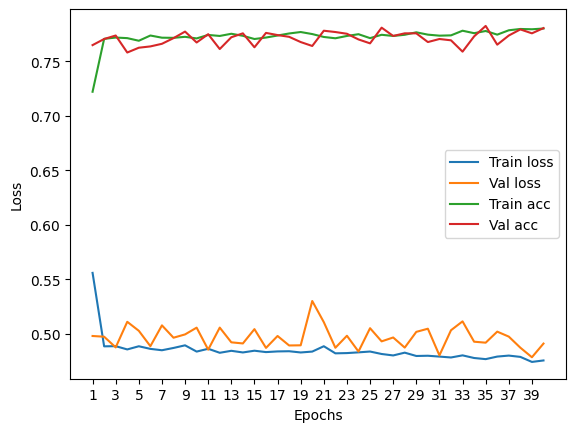

In [110]:
plot_loss(history)

Test accuracy:  78.4


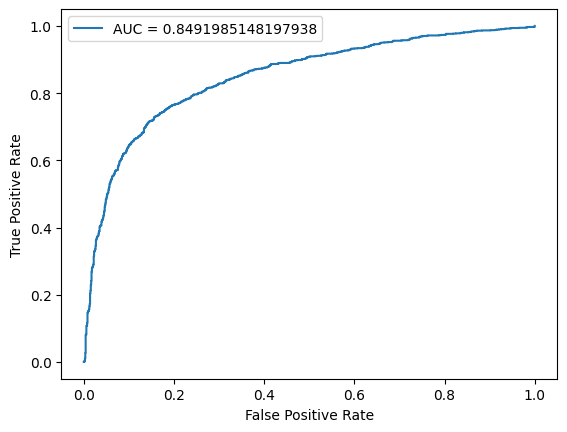

In [111]:
plot_auc(best_model, test_dataloader)

#### GAT - With 10 particles, edge_weights, (total particles, photon, charged hadron, neutral hadron, net positive charge of jet) count

In [111]:
input_dims = 8
hidden_dims = [8,8]
model = GAT(input_dims,hidden_dims,output_dims, activ_fn=ReLU())
model

GAT(
  (layers): ModuleList(
    (0-1): 2 x GATConv(8, 8, heads=1)
  )
  (activ_fn): ReLU()
  (classifier): Sequential(
    (0): Linear(in_features=15, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=1, bias=True)
  )
)

In [112]:
epochs = 50
optimizer = Adam(model.parameters(), 1e-3)
lossFn = BCEWithLogitsLoss()
history, best_model = train_model(model, optimizer, lossFn, epochs, lr, train_dataloader, val_dataloader)

0it [00:00, ?it/s]


RuntimeError: mat1 and mat2 must have the same dtype, but got Double and Float

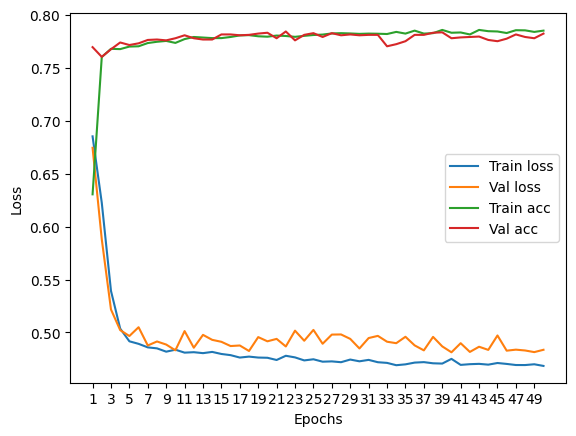

In [46]:
plot_loss(history)

Test accuracy:  76.88000000000001


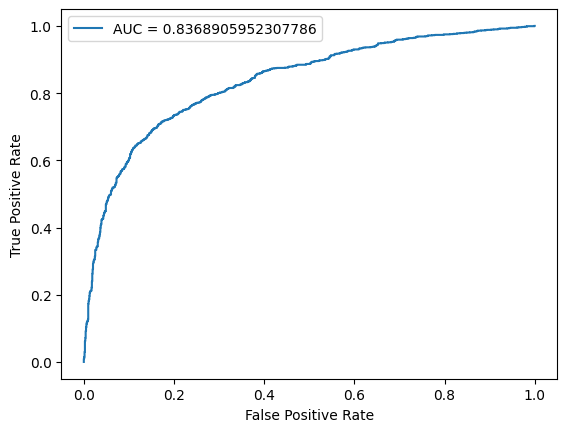

In [47]:
plot_auc(best_model, test_dataloader)

#### GAT - With 5 particles, edge_weights, (total particles, photon, charged hadron, neutral hadron, charge of jet with k = 0.2, 0.5, 0.7) count

In [116]:
input_dims = 8
hidden_dims = [8,8]
model = GAT(input_dims,hidden_dims,output_dims, activ_fn=ReLU())
model

GAT(
  (layers): ModuleList(
    (0-1): 2 x GATConv(8, 8, heads=1)
  )
  (activ_fn): ReLU()
  (classifier): Sequential(
    (0): Linear(in_features=15, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=1, bias=True)
  )
)

In [117]:
epochs = 50
optimizer = Adam(model.parameters(), 1e-3)
lossFn = BCEWithLogitsLoss()
history, best_model = train_model(model, optimizer, lossFn, epochs, lr, train_dataloader, val_dataloader)

118it [00:01, 64.49it/s]


Train Epoch: 0 	Loss: 0.686021, Accuracy: 4737/7500 (63%)
Val Epoch: 0 	Loss: 0.684530, Accuracy: 1741/2500 (70%)



118it [00:01, 60.21it/s]


Train Epoch: 1 	Loss: 0.658967, Accuracy: 5352/7500 (71%)
Val Epoch: 1 	Loss: 0.648924, Accuracy: 1894/2500 (76%)



118it [00:01, 60.47it/s]


Train Epoch: 2 	Loss: 0.616825, Accuracy: 5631/7500 (75%)
Val Epoch: 2 	Loss: 0.598189, Accuracy: 1879/2500 (75%)



118it [00:01, 59.27it/s]


Train Epoch: 3 	Loss: 0.563784, Accuracy: 5732/7500 (76%)
Val Epoch: 3 	Loss: 0.546261, Accuracy: 1958/2500 (78%)



118it [00:02, 52.24it/s]


Train Epoch: 4 	Loss: 0.524339, Accuracy: 5742/7500 (77%)
Val Epoch: 4 	Loss: 0.514191, Accuracy: 1960/2500 (78%)



118it [00:01, 76.52it/s]


Train Epoch: 5 	Loss: 0.506530, Accuracy: 5776/7500 (77%)
Val Epoch: 5 	Loss: 0.496887, Accuracy: 1959/2500 (78%)



118it [00:01, 72.13it/s]


Train Epoch: 6 	Loss: 0.500158, Accuracy: 5783/7500 (77%)
Val Epoch: 6 	Loss: 0.510235, Accuracy: 1955/2500 (78%)



118it [00:01, 81.37it/s]


Train Epoch: 7 	Loss: 0.496915, Accuracy: 5778/7500 (77%)
Val Epoch: 7 	Loss: 0.495451, Accuracy: 1956/2500 (78%)



118it [00:01, 71.23it/s]


Train Epoch: 8 	Loss: 0.493624, Accuracy: 5775/7500 (77%)
Val Epoch: 8 	Loss: 0.502586, Accuracy: 1955/2500 (78%)



118it [00:01, 74.56it/s]


Train Epoch: 9 	Loss: 0.495615, Accuracy: 5804/7500 (77%)
Val Epoch: 9 	Loss: 0.518696, Accuracy: 1963/2500 (79%)



118it [00:01, 84.34it/s]


Train Epoch: 10 	Loss: 0.494836, Accuracy: 5795/7500 (77%)
Val Epoch: 10 	Loss: 0.495251, Accuracy: 1962/2500 (78%)



118it [00:01, 86.50it/s]


Train Epoch: 11 	Loss: 0.492540, Accuracy: 5788/7500 (77%)
Val Epoch: 11 	Loss: 0.495857, Accuracy: 1964/2500 (79%)



118it [00:01, 84.62it/s]


Train Epoch: 12 	Loss: 0.491353, Accuracy: 5811/7500 (77%)
Val Epoch: 12 	Loss: 0.496157, Accuracy: 1938/2500 (78%)



118it [00:01, 74.29it/s]


Train Epoch: 13 	Loss: 0.490998, Accuracy: 5786/7500 (77%)
Val Epoch: 13 	Loss: 0.500981, Accuracy: 1934/2500 (77%)



118it [00:02, 57.87it/s]


Train Epoch: 14 	Loss: 0.491629, Accuracy: 5794/7500 (77%)
Val Epoch: 14 	Loss: 0.503641, Accuracy: 1962/2500 (78%)



118it [00:01, 65.58it/s]


Train Epoch: 15 	Loss: 0.492204, Accuracy: 5787/7500 (77%)
Val Epoch: 15 	Loss: 0.492672, Accuracy: 1941/2500 (78%)



118it [00:01, 72.59it/s]


Train Epoch: 16 	Loss: 0.490911, Accuracy: 5798/7500 (77%)
Val Epoch: 16 	Loss: 0.511580, Accuracy: 1923/2500 (77%)



118it [00:01, 68.33it/s]


Train Epoch: 17 	Loss: 0.491473, Accuracy: 5789/7500 (77%)
Val Epoch: 17 	Loss: 0.491214, Accuracy: 1963/2500 (79%)



118it [00:01, 67.71it/s]


Train Epoch: 18 	Loss: 0.492077, Accuracy: 5797/7500 (77%)
Val Epoch: 18 	Loss: 0.490608, Accuracy: 1953/2500 (78%)



118it [00:01, 68.15it/s]


Train Epoch: 19 	Loss: 0.490158, Accuracy: 5803/7500 (77%)
Val Epoch: 19 	Loss: 0.489131, Accuracy: 1965/2500 (79%)



118it [00:01, 77.31it/s]


Train Epoch: 20 	Loss: 0.490469, Accuracy: 5805/7500 (77%)
Val Epoch: 20 	Loss: 0.500512, Accuracy: 1959/2500 (78%)



118it [00:01, 63.80it/s]


Train Epoch: 21 	Loss: 0.489991, Accuracy: 5798/7500 (77%)
Val Epoch: 21 	Loss: 0.523574, Accuracy: 1956/2500 (78%)



118it [00:02, 54.06it/s]


Train Epoch: 22 	Loss: 0.490759, Accuracy: 5809/7500 (77%)
Val Epoch: 22 	Loss: 0.497075, Accuracy: 1965/2500 (79%)



118it [00:01, 70.47it/s]


Train Epoch: 23 	Loss: 0.490968, Accuracy: 5801/7500 (77%)
Val Epoch: 23 	Loss: 0.513020, Accuracy: 1961/2500 (78%)



118it [00:01, 70.52it/s]


Train Epoch: 24 	Loss: 0.491407, Accuracy: 5795/7500 (77%)
Val Epoch: 24 	Loss: 0.496537, Accuracy: 1962/2500 (78%)



118it [00:01, 71.71it/s]


Train Epoch: 25 	Loss: 0.491457, Accuracy: 5795/7500 (77%)
Val Epoch: 25 	Loss: 0.500533, Accuracy: 1955/2500 (78%)



118it [00:02, 56.03it/s]


Train Epoch: 26 	Loss: 0.491600, Accuracy: 5794/7500 (77%)
Val Epoch: 26 	Loss: 0.494258, Accuracy: 1965/2500 (79%)



118it [00:01, 83.27it/s]


Train Epoch: 27 	Loss: 0.491609, Accuracy: 5779/7500 (77%)
Val Epoch: 27 	Loss: 0.493297, Accuracy: 1952/2500 (78%)



118it [00:01, 68.26it/s]


Train Epoch: 28 	Loss: 0.490929, Accuracy: 5801/7500 (77%)
Val Epoch: 28 	Loss: 0.490775, Accuracy: 1958/2500 (78%)



118it [00:01, 67.66it/s]


Train Epoch: 29 	Loss: 0.489238, Accuracy: 5800/7500 (77%)
Val Epoch: 29 	Loss: 0.497249, Accuracy: 1958/2500 (78%)



118it [00:02, 56.32it/s]


Train Epoch: 30 	Loss: 0.490004, Accuracy: 5791/7500 (77%)
Val Epoch: 30 	Loss: 0.488094, Accuracy: 1963/2500 (79%)



118it [00:01, 66.95it/s]


Train Epoch: 31 	Loss: 0.491168, Accuracy: 5812/7500 (77%)
Val Epoch: 31 	Loss: 0.496628, Accuracy: 1946/2500 (78%)



118it [00:01, 73.96it/s]


Train Epoch: 32 	Loss: 0.488646, Accuracy: 5798/7500 (77%)
Val Epoch: 32 	Loss: 0.513928, Accuracy: 1962/2500 (78%)



118it [00:01, 70.38it/s]


Train Epoch: 33 	Loss: 0.491555, Accuracy: 5803/7500 (77%)
Val Epoch: 33 	Loss: 0.501996, Accuracy: 1958/2500 (78%)



118it [00:01, 72.69it/s]


Train Epoch: 34 	Loss: 0.491496, Accuracy: 5791/7500 (77%)
Val Epoch: 34 	Loss: 0.495320, Accuracy: 1966/2500 (79%)



118it [00:01, 75.38it/s]


Train Epoch: 35 	Loss: 0.491025, Accuracy: 5780/7500 (77%)
Val Epoch: 35 	Loss: 0.516928, Accuracy: 1961/2500 (78%)



118it [00:02, 52.46it/s]


Train Epoch: 36 	Loss: 0.490847, Accuracy: 5791/7500 (77%)
Val Epoch: 36 	Loss: 0.501201, Accuracy: 1955/2500 (78%)



118it [00:01, 71.79it/s]


Train Epoch: 37 	Loss: 0.491389, Accuracy: 5797/7500 (77%)
Val Epoch: 37 	Loss: 0.491841, Accuracy: 1955/2500 (78%)



118it [00:01, 73.48it/s]


Train Epoch: 38 	Loss: 0.489153, Accuracy: 5808/7500 (77%)
Val Epoch: 38 	Loss: 0.491316, Accuracy: 1956/2500 (78%)



118it [00:01, 71.27it/s]


Train Epoch: 39 	Loss: 0.488669, Accuracy: 5803/7500 (77%)
Val Epoch: 39 	Loss: 0.507509, Accuracy: 1950/2500 (78%)



118it [00:01, 66.47it/s]


Train Epoch: 40 	Loss: 0.491565, Accuracy: 5777/7500 (77%)
Val Epoch: 40 	Loss: 0.494215, Accuracy: 1934/2500 (77%)



118it [00:01, 72.42it/s]


Train Epoch: 41 	Loss: 0.490229, Accuracy: 5798/7500 (77%)
Val Epoch: 41 	Loss: 0.512541, Accuracy: 1962/2500 (78%)



118it [00:01, 85.80it/s]


Train Epoch: 42 	Loss: 0.492499, Accuracy: 5796/7500 (77%)
Val Epoch: 42 	Loss: 0.493773, Accuracy: 1946/2500 (78%)



118it [00:01, 73.60it/s]


Train Epoch: 43 	Loss: 0.491144, Accuracy: 5781/7500 (77%)
Val Epoch: 43 	Loss: 0.496098, Accuracy: 1958/2500 (78%)



118it [00:01, 75.66it/s]


Train Epoch: 44 	Loss: 0.489180, Accuracy: 5801/7500 (77%)
Val Epoch: 44 	Loss: 0.499658, Accuracy: 1966/2500 (79%)



118it [00:01, 85.96it/s]


Train Epoch: 45 	Loss: 0.488689, Accuracy: 5796/7500 (77%)
Val Epoch: 45 	Loss: 0.491563, Accuracy: 1953/2500 (78%)



118it [00:01, 82.51it/s]


Train Epoch: 46 	Loss: 0.487570, Accuracy: 5776/7500 (77%)
Val Epoch: 46 	Loss: 0.504904, Accuracy: 1959/2500 (78%)



118it [00:01, 84.77it/s]


Train Epoch: 47 	Loss: 0.487756, Accuracy: 5804/7500 (77%)
Val Epoch: 47 	Loss: 0.500567, Accuracy: 1946/2500 (78%)



118it [00:01, 84.26it/s]


Train Epoch: 48 	Loss: 0.489368, Accuracy: 5802/7500 (77%)
Val Epoch: 48 	Loss: 0.504492, Accuracy: 1956/2500 (78%)



118it [00:01, 84.24it/s]


Train Epoch: 49 	Loss: 0.489822, Accuracy: 5796/7500 (77%)
Val Epoch: 49 	Loss: 0.490107, Accuracy: 1949/2500 (78%)



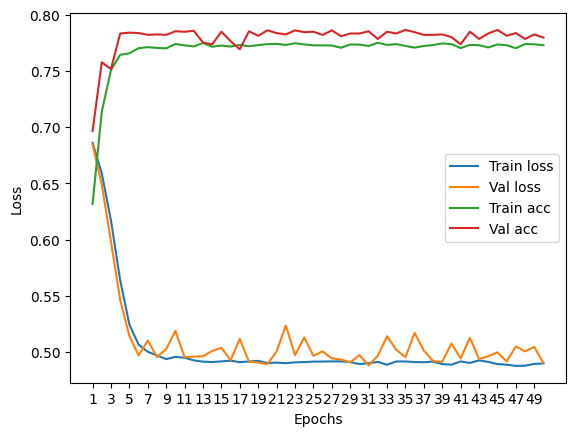

In [118]:
plot_loss(history)

Test accuracy:  76.55999999999999


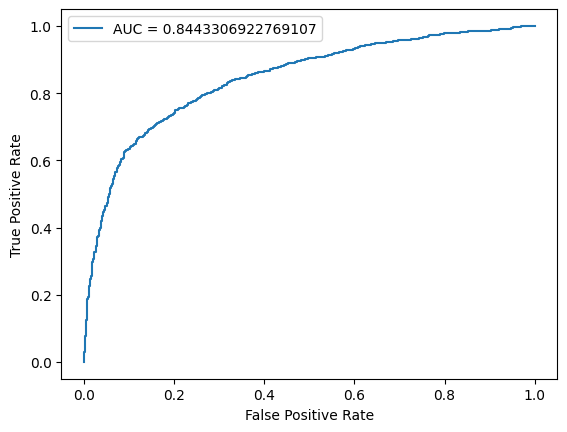

In [119]:
plot_auc(best_model, test_dataloader)

#### GAT - With 3 particles, edge_weights, (total particles, photon, charged hadron, neutral hadron, net positive charge of jet) count

In [100]:
input_dims = 8
hidden_dims = [8,8]
model = GAT(input_dims,hidden_dims,output_dims, activ_fn=ReLU())
model

GAT(
  (layers): ModuleList(
    (0-1): 2 x GATConv(8, 8, heads=1)
  )
  (activ_fn): ReLU()
  (classifier): Sequential(
    (0): Linear(in_features=13, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=1, bias=True)
  )
)

In [101]:
epochs = 50
optimizer = Adam(model.parameters(), 1e-3)
lossFn = BCEWithLogitsLoss()
history, best_model = train_model(model, optimizer, lossFn, epochs, lr, train_dataloader, val_dataloader)

118it [00:02, 56.34it/s]


Train Epoch: 0 	Loss: 0.679224, Accuracy: 4981/7500 (66%)
Val Epoch: 0 	Loss: 0.661855, Accuracy: 1847/2500 (74%)



118it [00:02, 42.49it/s]


Train Epoch: 1 	Loss: 0.590658, Accuracy: 5735/7500 (76%)
Val Epoch: 1 	Loss: 0.548389, Accuracy: 1909/2500 (76%)



118it [00:02, 40.28it/s]


Train Epoch: 2 	Loss: 0.514190, Accuracy: 5773/7500 (77%)
Val Epoch: 2 	Loss: 0.515656, Accuracy: 1905/2500 (76%)



118it [00:02, 49.37it/s]


Train Epoch: 3 	Loss: 0.496978, Accuracy: 5773/7500 (77%)
Val Epoch: 3 	Loss: 0.512654, Accuracy: 1911/2500 (76%)



118it [00:02, 43.42it/s]


Train Epoch: 4 	Loss: 0.493885, Accuracy: 5785/7500 (77%)
Val Epoch: 4 	Loss: 0.517532, Accuracy: 1908/2500 (76%)



118it [00:02, 46.78it/s]


Train Epoch: 5 	Loss: 0.493907, Accuracy: 5804/7500 (77%)
Val Epoch: 5 	Loss: 0.513201, Accuracy: 1913/2500 (77%)



118it [00:02, 47.88it/s]


Train Epoch: 6 	Loss: 0.488610, Accuracy: 5809/7500 (77%)
Val Epoch: 6 	Loss: 0.505969, Accuracy: 1913/2500 (77%)



118it [00:02, 46.43it/s]


Train Epoch: 7 	Loss: 0.489598, Accuracy: 5800/7500 (77%)
Val Epoch: 7 	Loss: 0.507472, Accuracy: 1918/2500 (77%)



118it [00:02, 47.08it/s]


Train Epoch: 8 	Loss: 0.491638, Accuracy: 5802/7500 (77%)
Val Epoch: 8 	Loss: 0.503521, Accuracy: 1918/2500 (77%)



118it [00:02, 48.05it/s]


Train Epoch: 9 	Loss: 0.487710, Accuracy: 5800/7500 (77%)
Val Epoch: 9 	Loss: 0.502871, Accuracy: 1915/2500 (77%)



118it [00:02, 44.40it/s]


Train Epoch: 10 	Loss: 0.487363, Accuracy: 5804/7500 (77%)
Val Epoch: 10 	Loss: 0.497687, Accuracy: 1924/2500 (77%)



118it [00:02, 48.20it/s]


Train Epoch: 11 	Loss: 0.486249, Accuracy: 5808/7500 (77%)
Val Epoch: 11 	Loss: 0.510538, Accuracy: 1911/2500 (76%)



118it [00:02, 46.63it/s]


Train Epoch: 12 	Loss: 0.486494, Accuracy: 5823/7500 (78%)
Val Epoch: 12 	Loss: 0.509723, Accuracy: 1919/2500 (77%)



118it [00:02, 46.52it/s]


Train Epoch: 13 	Loss: 0.485860, Accuracy: 5798/7500 (77%)
Val Epoch: 13 	Loss: 0.505694, Accuracy: 1913/2500 (77%)



118it [00:02, 45.97it/s]


Train Epoch: 14 	Loss: 0.487298, Accuracy: 5825/7500 (78%)
Val Epoch: 14 	Loss: 0.504729, Accuracy: 1915/2500 (77%)



118it [00:02, 40.95it/s]


Train Epoch: 15 	Loss: 0.487353, Accuracy: 5808/7500 (77%)
Val Epoch: 15 	Loss: 0.504469, Accuracy: 1909/2500 (76%)



118it [00:02, 41.80it/s]


Train Epoch: 16 	Loss: 0.485933, Accuracy: 5799/7500 (77%)
Val Epoch: 16 	Loss: 0.496940, Accuracy: 1916/2500 (77%)



118it [00:02, 40.60it/s]


Train Epoch: 17 	Loss: 0.487280, Accuracy: 5813/7500 (78%)
Val Epoch: 17 	Loss: 0.502543, Accuracy: 1924/2500 (77%)



118it [00:02, 42.61it/s]


Train Epoch: 18 	Loss: 0.487826, Accuracy: 5803/7500 (77%)
Val Epoch: 18 	Loss: 0.503252, Accuracy: 1912/2500 (76%)



118it [00:02, 42.74it/s]


Train Epoch: 19 	Loss: 0.485548, Accuracy: 5806/7500 (77%)
Val Epoch: 19 	Loss: 0.502494, Accuracy: 1918/2500 (77%)



118it [00:02, 39.87it/s]


Train Epoch: 20 	Loss: 0.485457, Accuracy: 5796/7500 (77%)
Val Epoch: 20 	Loss: 0.496603, Accuracy: 1915/2500 (77%)



118it [00:02, 40.03it/s]


Train Epoch: 21 	Loss: 0.486554, Accuracy: 5810/7500 (77%)
Val Epoch: 21 	Loss: 0.505461, Accuracy: 1912/2500 (76%)



118it [00:02, 43.30it/s]


Train Epoch: 22 	Loss: 0.487286, Accuracy: 5807/7500 (77%)
Val Epoch: 22 	Loss: 0.520765, Accuracy: 1914/2500 (77%)



118it [00:02, 53.34it/s]


Train Epoch: 23 	Loss: 0.484216, Accuracy: 5797/7500 (77%)
Val Epoch: 23 	Loss: 0.507713, Accuracy: 1922/2500 (77%)



118it [00:02, 53.81it/s]


Train Epoch: 24 	Loss: 0.485404, Accuracy: 5809/7500 (77%)
Val Epoch: 24 	Loss: 0.506315, Accuracy: 1917/2500 (77%)



118it [00:02, 48.90it/s]


Train Epoch: 25 	Loss: 0.486350, Accuracy: 5813/7500 (78%)
Val Epoch: 25 	Loss: 0.495411, Accuracy: 1917/2500 (77%)



118it [00:02, 47.69it/s]


Train Epoch: 26 	Loss: 0.484343, Accuracy: 5814/7500 (78%)
Val Epoch: 26 	Loss: 0.506845, Accuracy: 1909/2500 (76%)



118it [00:02, 41.58it/s]


Train Epoch: 27 	Loss: 0.485731, Accuracy: 5808/7500 (77%)
Val Epoch: 27 	Loss: 0.520948, Accuracy: 1923/2500 (77%)



118it [00:02, 42.42it/s]


Train Epoch: 28 	Loss: 0.483592, Accuracy: 5804/7500 (77%)
Val Epoch: 28 	Loss: 0.497840, Accuracy: 1919/2500 (77%)



118it [00:02, 43.82it/s]


Train Epoch: 29 	Loss: 0.482675, Accuracy: 5816/7500 (78%)
Val Epoch: 29 	Loss: 0.495366, Accuracy: 1920/2500 (77%)



118it [00:02, 40.53it/s]


Train Epoch: 30 	Loss: 0.482501, Accuracy: 5817/7500 (78%)
Val Epoch: 30 	Loss: 0.499579, Accuracy: 1918/2500 (77%)



118it [00:02, 42.63it/s]


Train Epoch: 31 	Loss: 0.484835, Accuracy: 5823/7500 (78%)
Val Epoch: 31 	Loss: 0.509477, Accuracy: 1906/2500 (76%)



118it [00:02, 42.16it/s]


Train Epoch: 32 	Loss: 0.483728, Accuracy: 5804/7500 (77%)
Val Epoch: 32 	Loss: 0.502098, Accuracy: 1910/2500 (76%)



118it [00:02, 44.14it/s]


Train Epoch: 33 	Loss: 0.483241, Accuracy: 5819/7500 (78%)
Val Epoch: 33 	Loss: 0.506517, Accuracy: 1923/2500 (77%)



118it [00:03, 36.34it/s]


Train Epoch: 34 	Loss: 0.483518, Accuracy: 5825/7500 (78%)
Val Epoch: 34 	Loss: 0.507315, Accuracy: 1923/2500 (77%)



118it [00:03, 36.24it/s]


Train Epoch: 35 	Loss: 0.484081, Accuracy: 5823/7500 (78%)
Val Epoch: 35 	Loss: 0.495028, Accuracy: 1915/2500 (77%)



118it [00:03, 38.01it/s]


Train Epoch: 36 	Loss: 0.483063, Accuracy: 5809/7500 (77%)
Val Epoch: 36 	Loss: 0.497442, Accuracy: 1920/2500 (77%)



118it [00:03, 38.06it/s]


Train Epoch: 37 	Loss: 0.483488, Accuracy: 5822/7500 (78%)
Val Epoch: 37 	Loss: 0.504834, Accuracy: 1911/2500 (76%)



118it [00:02, 43.07it/s]


Train Epoch: 38 	Loss: 0.481824, Accuracy: 5825/7500 (78%)
Val Epoch: 38 	Loss: 0.497843, Accuracy: 1919/2500 (77%)



118it [00:02, 49.89it/s]


Train Epoch: 39 	Loss: 0.483534, Accuracy: 5834/7500 (78%)
Val Epoch: 39 	Loss: 0.500782, Accuracy: 1914/2500 (77%)



118it [00:02, 43.42it/s]


Train Epoch: 40 	Loss: 0.482789, Accuracy: 5811/7500 (77%)
Val Epoch: 40 	Loss: 0.511113, Accuracy: 1918/2500 (77%)



118it [00:02, 44.13it/s]


Train Epoch: 41 	Loss: 0.481134, Accuracy: 5828/7500 (78%)
Val Epoch: 41 	Loss: 0.498796, Accuracy: 1918/2500 (77%)



118it [00:02, 43.69it/s]


Train Epoch: 42 	Loss: 0.482381, Accuracy: 5827/7500 (78%)
Val Epoch: 42 	Loss: 0.499624, Accuracy: 1911/2500 (76%)



118it [00:02, 44.36it/s]


Train Epoch: 43 	Loss: 0.482835, Accuracy: 5820/7500 (78%)
Val Epoch: 43 	Loss: 0.497498, Accuracy: 1919/2500 (77%)



118it [00:02, 48.49it/s]


Train Epoch: 44 	Loss: 0.482784, Accuracy: 5830/7500 (78%)
Val Epoch: 44 	Loss: 0.519504, Accuracy: 1917/2500 (77%)



118it [00:02, 44.34it/s]


Train Epoch: 45 	Loss: 0.484919, Accuracy: 5820/7500 (78%)
Val Epoch: 45 	Loss: 0.511558, Accuracy: 1918/2500 (77%)



118it [00:02, 43.88it/s]


Train Epoch: 46 	Loss: 0.482472, Accuracy: 5817/7500 (78%)
Val Epoch: 46 	Loss: 0.498900, Accuracy: 1914/2500 (77%)



118it [00:02, 43.85it/s]


Train Epoch: 47 	Loss: 0.481679, Accuracy: 5849/7500 (78%)
Val Epoch: 47 	Loss: 0.497862, Accuracy: 1919/2500 (77%)



118it [00:02, 44.19it/s]


Train Epoch: 48 	Loss: 0.482015, Accuracy: 5829/7500 (78%)
Val Epoch: 48 	Loss: 0.500814, Accuracy: 1918/2500 (77%)



118it [00:02, 50.59it/s]


Train Epoch: 49 	Loss: 0.480615, Accuracy: 5837/7500 (78%)
Val Epoch: 49 	Loss: 0.506221, Accuracy: 1918/2500 (77%)



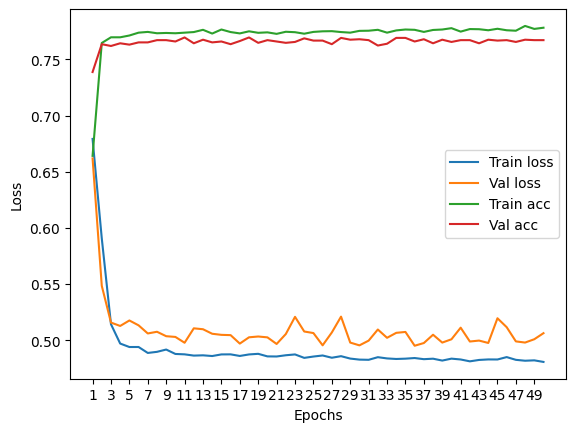

In [102]:
plot_loss(history)

Test accuracy:  79.47999999999999


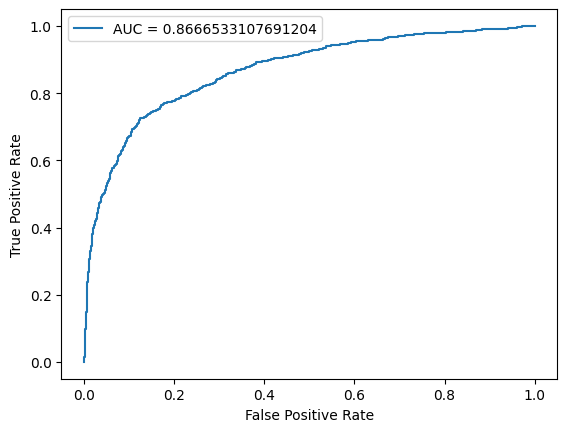

In [103]:
plot_auc(best_model, test_dataloader)

#### GAT - With 3 particles, edge_weights, (total particles, photon, charged hadron, neutral hadron, net positive charge of jet) count

In [64]:
input_dims = 8
hidden_dims = [8,8]
model = GAT(input_dims,hidden_dims,output_dims, activ_fn=ReLU())
model

GAT(
  (layers): ModuleList(
    (0-1): 2 x GATConv(8, 8, heads=1)
  )
  (activ_fn): ReLU()
  (classifier): Sequential(
    (0): Linear(in_features=13, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=1, bias=True)
  )
)

In [65]:
epochs = 50
optimizer = Adam(model.parameters(), 1e-3)
lossFn = BCEWithLogitsLoss()
history, best_model = train_model(model, optimizer, lossFn, epochs, lr, train_dataloader, val_dataloader)

118it [00:03, 36.50it/s]


Train Epoch: 0 	Loss: 0.699354, Accuracy: 3740/7500 (50%)
Val Epoch: 0 	Loss: 0.701798, Accuracy: 1239/2500 (50%)



118it [00:03, 39.10it/s]


Train Epoch: 1 	Loss: 0.670694, Accuracy: 4430/7500 (59%)
Val Epoch: 1 	Loss: 0.652759, Accuracy: 1829/2500 (73%)



118it [00:03, 36.37it/s]


Train Epoch: 2 	Loss: 0.607265, Accuracy: 5622/7500 (75%)
Val Epoch: 2 	Loss: 0.575294, Accuracy: 1882/2500 (75%)



118it [00:03, 36.61it/s]


Train Epoch: 3 	Loss: 0.545586, Accuracy: 5702/7500 (76%)
Val Epoch: 3 	Loss: 0.519337, Accuracy: 1917/2500 (77%)



118it [00:03, 35.54it/s]


Train Epoch: 4 	Loss: 0.516325, Accuracy: 5741/7500 (77%)
Val Epoch: 4 	Loss: 0.507093, Accuracy: 1939/2500 (78%)



118it [00:03, 36.49it/s]


Train Epoch: 5 	Loss: 0.509497, Accuracy: 5741/7500 (77%)
Val Epoch: 5 	Loss: 0.497451, Accuracy: 1926/2500 (77%)



118it [00:03, 34.85it/s]


Train Epoch: 6 	Loss: 0.506086, Accuracy: 5748/7500 (77%)
Val Epoch: 6 	Loss: 0.494883, Accuracy: 1933/2500 (77%)



118it [00:03, 36.15it/s]


Train Epoch: 7 	Loss: 0.503816, Accuracy: 5752/7500 (77%)
Val Epoch: 7 	Loss: 0.489023, Accuracy: 1933/2500 (77%)



118it [00:03, 36.04it/s]


Train Epoch: 8 	Loss: 0.503827, Accuracy: 5749/7500 (77%)
Val Epoch: 8 	Loss: 0.486952, Accuracy: 1931/2500 (77%)



118it [00:03, 36.35it/s]


Train Epoch: 9 	Loss: 0.501117, Accuracy: 5769/7500 (77%)
Val Epoch: 9 	Loss: 0.497595, Accuracy: 1944/2500 (78%)



118it [00:03, 35.40it/s]


Train Epoch: 10 	Loss: 0.501098, Accuracy: 5763/7500 (77%)
Val Epoch: 10 	Loss: 0.501252, Accuracy: 1945/2500 (78%)



118it [00:03, 35.55it/s]


Train Epoch: 11 	Loss: 0.499949, Accuracy: 5787/7500 (77%)
Val Epoch: 11 	Loss: 0.500875, Accuracy: 1939/2500 (78%)



118it [00:03, 34.89it/s]


Train Epoch: 12 	Loss: 0.501005, Accuracy: 5757/7500 (77%)
Val Epoch: 12 	Loss: 0.492302, Accuracy: 1943/2500 (78%)



118it [00:03, 38.05it/s]


Train Epoch: 13 	Loss: 0.498879, Accuracy: 5766/7500 (77%)
Val Epoch: 13 	Loss: 0.488999, Accuracy: 1951/2500 (78%)



118it [00:03, 34.89it/s]


Train Epoch: 14 	Loss: 0.499012, Accuracy: 5762/7500 (77%)
Val Epoch: 14 	Loss: 0.489519, Accuracy: 1952/2500 (78%)



118it [00:03, 35.56it/s]


Train Epoch: 15 	Loss: 0.496413, Accuracy: 5791/7500 (77%)
Val Epoch: 15 	Loss: 0.485582, Accuracy: 1951/2500 (78%)



118it [00:03, 36.33it/s]


Train Epoch: 16 	Loss: 0.497348, Accuracy: 5771/7500 (77%)
Val Epoch: 16 	Loss: 0.497765, Accuracy: 1943/2500 (78%)



118it [00:03, 36.06it/s]


Train Epoch: 17 	Loss: 0.496291, Accuracy: 5781/7500 (77%)
Val Epoch: 17 	Loss: 0.481195, Accuracy: 1954/2500 (78%)



118it [00:03, 35.62it/s]


Train Epoch: 18 	Loss: 0.496443, Accuracy: 5781/7500 (77%)
Val Epoch: 18 	Loss: 0.499333, Accuracy: 1944/2500 (78%)



118it [00:03, 34.06it/s]


Train Epoch: 19 	Loss: 0.497591, Accuracy: 5782/7500 (77%)
Val Epoch: 19 	Loss: 0.482335, Accuracy: 1956/2500 (78%)



118it [00:03, 33.19it/s]


Train Epoch: 20 	Loss: 0.494449, Accuracy: 5791/7500 (77%)
Val Epoch: 20 	Loss: 0.500872, Accuracy: 1959/2500 (78%)



118it [00:03, 31.70it/s]


Train Epoch: 21 	Loss: 0.496343, Accuracy: 5767/7500 (77%)
Val Epoch: 21 	Loss: 0.481721, Accuracy: 1955/2500 (78%)



118it [00:03, 34.66it/s]


Train Epoch: 22 	Loss: 0.495090, Accuracy: 5773/7500 (77%)
Val Epoch: 22 	Loss: 0.494303, Accuracy: 1954/2500 (78%)



118it [00:03, 35.14it/s]


Train Epoch: 23 	Loss: 0.495072, Accuracy: 5764/7500 (77%)
Val Epoch: 23 	Loss: 0.482626, Accuracy: 1960/2500 (78%)



118it [00:03, 37.52it/s]


Train Epoch: 24 	Loss: 0.495594, Accuracy: 5782/7500 (77%)
Val Epoch: 24 	Loss: 0.484181, Accuracy: 1962/2500 (78%)



118it [00:03, 34.64it/s]


Train Epoch: 25 	Loss: 0.493523, Accuracy: 5798/7500 (77%)
Val Epoch: 25 	Loss: 0.488866, Accuracy: 1952/2500 (78%)



118it [00:03, 32.87it/s]


Train Epoch: 26 	Loss: 0.493921, Accuracy: 5784/7500 (77%)
Val Epoch: 26 	Loss: 0.481496, Accuracy: 1954/2500 (78%)



118it [00:03, 30.65it/s]


Train Epoch: 27 	Loss: 0.494173, Accuracy: 5796/7500 (77%)
Val Epoch: 27 	Loss: 0.482656, Accuracy: 1956/2500 (78%)



118it [00:04, 28.72it/s]


Train Epoch: 28 	Loss: 0.494241, Accuracy: 5780/7500 (77%)
Val Epoch: 28 	Loss: 0.481878, Accuracy: 1948/2500 (78%)



118it [00:03, 37.61it/s]


Train Epoch: 29 	Loss: 0.492355, Accuracy: 5783/7500 (77%)
Val Epoch: 29 	Loss: 0.490858, Accuracy: 1955/2500 (78%)



118it [00:03, 34.12it/s]


Train Epoch: 30 	Loss: 0.493718, Accuracy: 5775/7500 (77%)
Val Epoch: 30 	Loss: 0.482533, Accuracy: 1962/2500 (78%)



118it [00:03, 36.32it/s]


Train Epoch: 31 	Loss: 0.489974, Accuracy: 5793/7500 (77%)
Val Epoch: 31 	Loss: 0.487204, Accuracy: 1957/2500 (78%)



118it [00:03, 36.19it/s]


Train Epoch: 32 	Loss: 0.491995, Accuracy: 5778/7500 (77%)
Val Epoch: 32 	Loss: 0.488752, Accuracy: 1957/2500 (78%)



118it [00:03, 34.44it/s]


Train Epoch: 33 	Loss: 0.492863, Accuracy: 5782/7500 (77%)
Val Epoch: 33 	Loss: 0.484523, Accuracy: 1955/2500 (78%)



118it [00:03, 34.64it/s]


Train Epoch: 34 	Loss: 0.490497, Accuracy: 5790/7500 (77%)
Val Epoch: 34 	Loss: 0.493404, Accuracy: 1956/2500 (78%)



118it [00:03, 37.47it/s]


Train Epoch: 35 	Loss: 0.493160, Accuracy: 5782/7500 (77%)
Val Epoch: 35 	Loss: 0.478923, Accuracy: 1953/2500 (78%)



118it [00:03, 34.94it/s]


Train Epoch: 36 	Loss: 0.492305, Accuracy: 5792/7500 (77%)
Val Epoch: 36 	Loss: 0.482304, Accuracy: 1959/2500 (78%)



118it [00:03, 34.27it/s]


Train Epoch: 37 	Loss: 0.491511, Accuracy: 5786/7500 (77%)
Val Epoch: 37 	Loss: 0.479187, Accuracy: 1962/2500 (78%)



118it [00:03, 34.63it/s]


Train Epoch: 38 	Loss: 0.492198, Accuracy: 5786/7500 (77%)
Val Epoch: 38 	Loss: 0.490178, Accuracy: 1959/2500 (78%)



118it [00:03, 36.14it/s]


Train Epoch: 39 	Loss: 0.489874, Accuracy: 5790/7500 (77%)
Val Epoch: 39 	Loss: 0.480702, Accuracy: 1960/2500 (78%)



118it [00:03, 35.09it/s]


Train Epoch: 40 	Loss: 0.489885, Accuracy: 5801/7500 (77%)
Val Epoch: 40 	Loss: 0.480007, Accuracy: 1961/2500 (78%)



118it [00:03, 34.42it/s]


Train Epoch: 41 	Loss: 0.491614, Accuracy: 5785/7500 (77%)
Val Epoch: 41 	Loss: 0.497461, Accuracy: 1961/2500 (78%)



118it [00:03, 34.75it/s]


Train Epoch: 42 	Loss: 0.489097, Accuracy: 5799/7500 (77%)
Val Epoch: 42 	Loss: 0.477839, Accuracy: 1959/2500 (78%)



118it [00:03, 37.35it/s]


Train Epoch: 43 	Loss: 0.490707, Accuracy: 5773/7500 (77%)
Val Epoch: 43 	Loss: 0.502007, Accuracy: 1962/2500 (78%)



118it [00:03, 34.30it/s]


Train Epoch: 44 	Loss: 0.491165, Accuracy: 5787/7500 (77%)
Val Epoch: 44 	Loss: 0.485472, Accuracy: 1960/2500 (78%)



118it [00:03, 34.27it/s]


Train Epoch: 45 	Loss: 0.490934, Accuracy: 5773/7500 (77%)
Val Epoch: 45 	Loss: 0.492866, Accuracy: 1953/2500 (78%)



118it [00:03, 39.21it/s]


Train Epoch: 46 	Loss: 0.488538, Accuracy: 5792/7500 (77%)
Val Epoch: 46 	Loss: 0.492247, Accuracy: 1953/2500 (78%)



118it [00:03, 37.23it/s]


Train Epoch: 47 	Loss: 0.492049, Accuracy: 5785/7500 (77%)
Val Epoch: 47 	Loss: 0.498169, Accuracy: 1958/2500 (78%)



118it [00:03, 34.56it/s]


Train Epoch: 48 	Loss: 0.488220, Accuracy: 5820/7500 (78%)
Val Epoch: 48 	Loss: 0.484803, Accuracy: 1947/2500 (78%)



118it [00:03, 33.43it/s]


Train Epoch: 49 	Loss: 0.490920, Accuracy: 5796/7500 (77%)
Val Epoch: 49 	Loss: 0.487696, Accuracy: 1958/2500 (78%)



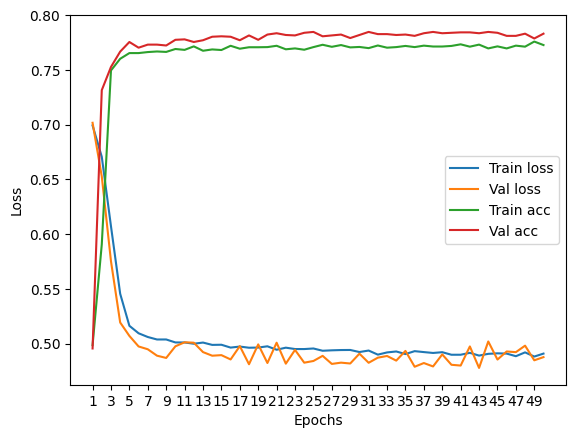

In [66]:
plot_loss(history)

Test accuracy:  77.28


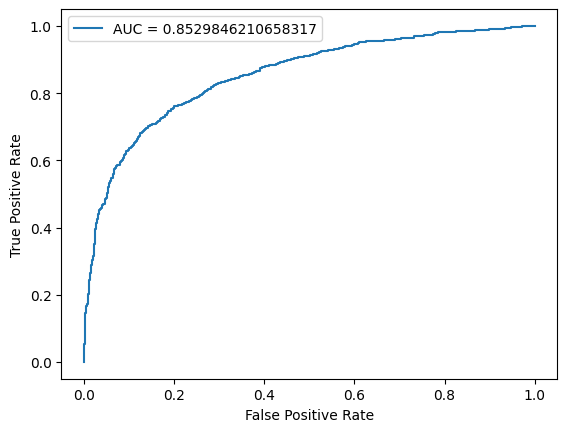

In [67]:
plot_auc(best_model, test_dataloader)

#### With 3 particles, edge_weights, (total particles, photon, charged hadron, neutral hadron, net positive charge of jet) count

In [47]:
input_dims = 8
hidden_dims = [8,8]
model = GNN(input_dims,hidden_dims,output_dims, activ_fn=ReLU())
model

NameError: name 'GNN' is not defined

In [155]:
epochs = 50
optimizer = Adam(model.parameters(), 1e-3)
lossFn = BCEWithLogitsLoss()
history, best_model = train_model(model, optimizer, lossFn, epochs, lr, train_dataloader, val_dataloader)

118it [00:02, 58.84it/s]


Train Epoch: 0 	Loss: 0.685528, Accuracy: 4312/7500 (57%)
Val Epoch: 0 	Loss: 0.685085, Accuracy: 1434/2500 (57%)



118it [00:02, 48.85it/s]


Train Epoch: 1 	Loss: 0.621606, Accuracy: 5365/7500 (72%)
Val Epoch: 1 	Loss: 0.570897, Accuracy: 1894/2500 (76%)



118it [00:01, 62.25it/s]


Train Epoch: 2 	Loss: 0.519863, Accuracy: 5713/7500 (76%)
Val Epoch: 2 	Loss: 0.508976, Accuracy: 1884/2500 (75%)



118it [00:02, 57.10it/s]


Train Epoch: 3 	Loss: 0.494194, Accuracy: 5771/7500 (77%)
Val Epoch: 3 	Loss: 0.502651, Accuracy: 1900/2500 (76%)



118it [00:02, 55.34it/s]


Train Epoch: 4 	Loss: 0.489101, Accuracy: 5776/7500 (77%)
Val Epoch: 4 	Loss: 0.505832, Accuracy: 1913/2500 (77%)



118it [00:02, 52.21it/s]


Train Epoch: 5 	Loss: 0.487716, Accuracy: 5794/7500 (77%)
Val Epoch: 5 	Loss: 0.494924, Accuracy: 1918/2500 (77%)



118it [00:02, 51.78it/s]


Train Epoch: 6 	Loss: 0.487323, Accuracy: 5802/7500 (77%)
Val Epoch: 6 	Loss: 0.509311, Accuracy: 1892/2500 (76%)



118it [00:02, 51.48it/s]


Train Epoch: 7 	Loss: 0.487108, Accuracy: 5795/7500 (77%)
Val Epoch: 7 	Loss: 0.498114, Accuracy: 1922/2500 (77%)



118it [00:02, 58.53it/s]


Train Epoch: 8 	Loss: 0.485618, Accuracy: 5809/7500 (77%)
Val Epoch: 8 	Loss: 0.507186, Accuracy: 1917/2500 (77%)



118it [00:02, 52.39it/s]


Train Epoch: 9 	Loss: 0.483095, Accuracy: 5813/7500 (78%)
Val Epoch: 9 	Loss: 0.496915, Accuracy: 1925/2500 (77%)



118it [00:02, 51.17it/s]


Train Epoch: 10 	Loss: 0.484610, Accuracy: 5800/7500 (77%)
Val Epoch: 10 	Loss: 0.495221, Accuracy: 1924/2500 (77%)



118it [00:02, 49.38it/s]


Train Epoch: 11 	Loss: 0.484865, Accuracy: 5823/7500 (78%)
Val Epoch: 11 	Loss: 0.495658, Accuracy: 1918/2500 (77%)



118it [00:02, 51.15it/s]


Train Epoch: 12 	Loss: 0.485194, Accuracy: 5808/7500 (77%)
Val Epoch: 12 	Loss: 0.501887, Accuracy: 1919/2500 (77%)



118it [00:02, 50.16it/s]


Train Epoch: 13 	Loss: 0.483585, Accuracy: 5819/7500 (78%)
Val Epoch: 13 	Loss: 0.505195, Accuracy: 1928/2500 (77%)



118it [00:01, 61.73it/s]


Train Epoch: 14 	Loss: 0.482176, Accuracy: 5817/7500 (78%)
Val Epoch: 14 	Loss: 0.501631, Accuracy: 1921/2500 (77%)



118it [00:02, 51.12it/s]


Train Epoch: 15 	Loss: 0.482026, Accuracy: 5829/7500 (78%)
Val Epoch: 15 	Loss: 0.508243, Accuracy: 1912/2500 (76%)



118it [00:02, 48.55it/s]


Train Epoch: 16 	Loss: 0.481848, Accuracy: 5832/7500 (78%)
Val Epoch: 16 	Loss: 0.497162, Accuracy: 1928/2500 (77%)



118it [00:02, 49.91it/s]


Train Epoch: 17 	Loss: 0.482894, Accuracy: 5834/7500 (78%)
Val Epoch: 17 	Loss: 0.514141, Accuracy: 1932/2500 (77%)



118it [00:02, 51.72it/s]


Train Epoch: 18 	Loss: 0.484537, Accuracy: 5827/7500 (78%)
Val Epoch: 18 	Loss: 0.493758, Accuracy: 1924/2500 (77%)



118it [00:02, 55.19it/s]


Train Epoch: 19 	Loss: 0.481078, Accuracy: 5831/7500 (78%)
Val Epoch: 19 	Loss: 0.499123, Accuracy: 1922/2500 (77%)



118it [00:02, 52.85it/s]


Train Epoch: 20 	Loss: 0.481924, Accuracy: 5816/7500 (78%)
Val Epoch: 20 	Loss: 0.495733, Accuracy: 1928/2500 (77%)



118it [00:02, 51.58it/s]


Train Epoch: 21 	Loss: 0.479304, Accuracy: 5828/7500 (78%)
Val Epoch: 21 	Loss: 0.516009, Accuracy: 1936/2500 (77%)



118it [00:02, 51.36it/s]


Train Epoch: 22 	Loss: 0.483665, Accuracy: 5835/7500 (78%)
Val Epoch: 22 	Loss: 0.497132, Accuracy: 1929/2500 (77%)



118it [00:02, 50.82it/s]


Train Epoch: 23 	Loss: 0.478970, Accuracy: 5844/7500 (78%)
Val Epoch: 23 	Loss: 0.496017, Accuracy: 1918/2500 (77%)



118it [00:02, 48.14it/s]


Train Epoch: 24 	Loss: 0.479543, Accuracy: 5848/7500 (78%)
Val Epoch: 24 	Loss: 0.503331, Accuracy: 1927/2500 (77%)



118it [00:01, 64.46it/s]


Train Epoch: 25 	Loss: 0.481622, Accuracy: 5841/7500 (78%)
Val Epoch: 25 	Loss: 0.498532, Accuracy: 1927/2500 (77%)



118it [00:02, 51.55it/s]


Train Epoch: 26 	Loss: 0.479253, Accuracy: 5829/7500 (78%)
Val Epoch: 26 	Loss: 0.503413, Accuracy: 1932/2500 (77%)



118it [00:02, 49.21it/s]


Train Epoch: 27 	Loss: 0.478574, Accuracy: 5846/7500 (78%)
Val Epoch: 27 	Loss: 0.495086, Accuracy: 1925/2500 (77%)



118it [00:02, 50.75it/s]


Train Epoch: 28 	Loss: 0.481948, Accuracy: 5816/7500 (78%)
Val Epoch: 28 	Loss: 0.497814, Accuracy: 1929/2500 (77%)



118it [00:02, 49.58it/s]


Train Epoch: 29 	Loss: 0.478294, Accuracy: 5847/7500 (78%)
Val Epoch: 29 	Loss: 0.501038, Accuracy: 1930/2500 (77%)



118it [00:02, 56.86it/s]


Train Epoch: 30 	Loss: 0.480744, Accuracy: 5851/7500 (78%)
Val Epoch: 30 	Loss: 0.522677, Accuracy: 1929/2500 (77%)



118it [00:02, 53.26it/s]


Train Epoch: 31 	Loss: 0.479561, Accuracy: 5826/7500 (78%)
Val Epoch: 31 	Loss: 0.503239, Accuracy: 1917/2500 (77%)



118it [00:02, 49.49it/s]


Train Epoch: 32 	Loss: 0.479676, Accuracy: 5839/7500 (78%)
Val Epoch: 32 	Loss: 0.497320, Accuracy: 1936/2500 (77%)



118it [00:02, 48.12it/s]


Train Epoch: 33 	Loss: 0.479471, Accuracy: 5834/7500 (78%)
Val Epoch: 33 	Loss: 0.497995, Accuracy: 1928/2500 (77%)



118it [00:02, 43.22it/s]


Train Epoch: 34 	Loss: 0.481735, Accuracy: 5845/7500 (78%)
Val Epoch: 34 	Loss: 0.504653, Accuracy: 1927/2500 (77%)



118it [00:02, 44.17it/s]


Train Epoch: 35 	Loss: 0.478552, Accuracy: 5836/7500 (78%)
Val Epoch: 35 	Loss: 0.497608, Accuracy: 1930/2500 (77%)



118it [00:02, 52.19it/s]


Train Epoch: 36 	Loss: 0.480573, Accuracy: 5844/7500 (78%)
Val Epoch: 36 	Loss: 0.493109, Accuracy: 1934/2500 (77%)



118it [00:02, 52.82it/s]


Train Epoch: 37 	Loss: 0.481807, Accuracy: 5854/7500 (78%)
Val Epoch: 37 	Loss: 0.502052, Accuracy: 1931/2500 (77%)



118it [00:02, 51.25it/s]


Train Epoch: 38 	Loss: 0.482404, Accuracy: 5814/7500 (78%)
Val Epoch: 38 	Loss: 0.512512, Accuracy: 1930/2500 (77%)



118it [00:02, 44.74it/s]


Train Epoch: 39 	Loss: 0.478064, Accuracy: 5851/7500 (78%)
Val Epoch: 39 	Loss: 0.496703, Accuracy: 1929/2500 (77%)



118it [00:02, 43.33it/s]


Train Epoch: 40 	Loss: 0.479625, Accuracy: 5846/7500 (78%)
Val Epoch: 40 	Loss: 0.501640, Accuracy: 1931/2500 (77%)



118it [00:02, 53.36it/s]


Train Epoch: 41 	Loss: 0.479372, Accuracy: 5842/7500 (78%)
Val Epoch: 41 	Loss: 0.506662, Accuracy: 1930/2500 (77%)



118it [00:02, 54.32it/s]


Train Epoch: 42 	Loss: 0.477532, Accuracy: 5839/7500 (78%)
Val Epoch: 42 	Loss: 0.506716, Accuracy: 1932/2500 (77%)



118it [00:02, 50.35it/s]


Train Epoch: 43 	Loss: 0.479834, Accuracy: 5847/7500 (78%)
Val Epoch: 43 	Loss: 0.494311, Accuracy: 1926/2500 (77%)



118it [00:02, 42.61it/s]


Train Epoch: 44 	Loss: 0.478025, Accuracy: 5840/7500 (78%)
Val Epoch: 44 	Loss: 0.500466, Accuracy: 1928/2500 (77%)



118it [00:02, 48.06it/s]


Train Epoch: 45 	Loss: 0.479735, Accuracy: 5855/7500 (78%)
Val Epoch: 45 	Loss: 0.487779, Accuracy: 1928/2500 (77%)



118it [00:02, 52.73it/s]


Train Epoch: 46 	Loss: 0.476667, Accuracy: 5847/7500 (78%)
Val Epoch: 46 	Loss: 0.496730, Accuracy: 1933/2500 (77%)



118it [00:02, 49.90it/s]


Train Epoch: 47 	Loss: 0.479927, Accuracy: 5834/7500 (78%)
Val Epoch: 47 	Loss: 0.494934, Accuracy: 1933/2500 (77%)



118it [00:02, 49.51it/s]


Train Epoch: 48 	Loss: 0.477397, Accuracy: 5856/7500 (78%)
Val Epoch: 48 	Loss: 0.510249, Accuracy: 1934/2500 (77%)



118it [00:02, 48.87it/s]


Train Epoch: 49 	Loss: 0.476795, Accuracy: 5858/7500 (78%)
Val Epoch: 49 	Loss: 0.490885, Accuracy: 1932/2500 (77%)



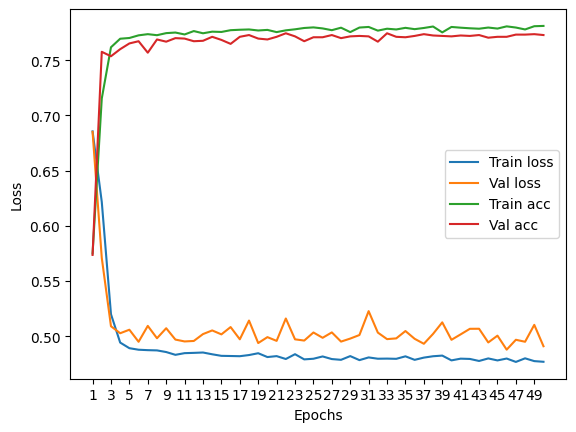

In [156]:
plot_loss(history)

Test accuracy:  78.60000000000001


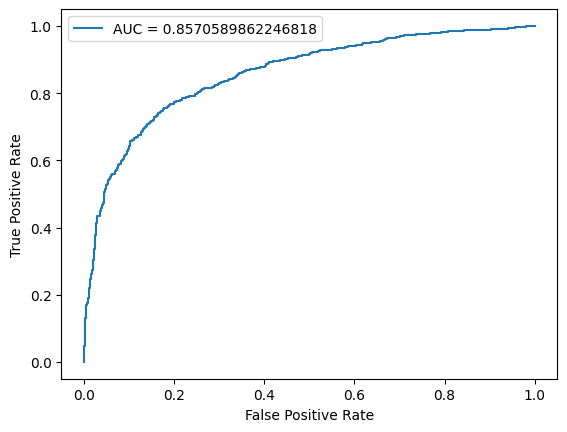

In [157]:
plot_auc(best_model, test_dataloader)

#### With 3 particles _ edge_weights

In [58]:
hidden_dims = [8]
model = GNN(input_dims,hidden_dims,output_dims, activ_fn=ReLU())
model

GNN(
  (layers): ModuleList(
    (0): GCNConv(8, 8)
  )
  (activ_fn): ReLU()
  (classifier): Sequential(
    (0): Linear(in_features=9, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=1, bias=True)
  )
)

In [59]:
epochs = 40
optimizer = Adam(model.parameters(), 1e-2)
lossFn = BCEWithLogitsLoss()
history, best_model = train_model(model, optimizer, lossFn, epochs, lr, train_dataloader, val_dataloader)

118it [00:00, 161.05it/s]


Train Epoch: 0 	Loss: 0.597074, Accuracy: 5380/7500 (72%)
Val Epoch: 0 	Loss: 0.524107, Accuracy: 1898/2500 (76%)



118it [00:00, 195.05it/s]


Train Epoch: 1 	Loss: 0.489333, Accuracy: 5770/7500 (77%)
Val Epoch: 1 	Loss: 0.506700, Accuracy: 1900/2500 (76%)



118it [00:00, 204.84it/s]


Train Epoch: 2 	Loss: 0.481938, Accuracy: 5832/7500 (78%)
Val Epoch: 2 	Loss: 0.514233, Accuracy: 1909/2500 (76%)



118it [00:00, 201.25it/s]


Train Epoch: 3 	Loss: 0.479497, Accuracy: 5820/7500 (78%)
Val Epoch: 3 	Loss: 0.506254, Accuracy: 1924/2500 (77%)



118it [00:00, 201.66it/s]


Train Epoch: 4 	Loss: 0.479692, Accuracy: 5843/7500 (78%)
Val Epoch: 4 	Loss: 0.496182, Accuracy: 1916/2500 (77%)



118it [00:00, 205.89it/s]


Train Epoch: 5 	Loss: 0.479176, Accuracy: 5832/7500 (78%)
Val Epoch: 5 	Loss: 0.503697, Accuracy: 1914/2500 (77%)



118it [00:00, 217.28it/s]


Train Epoch: 6 	Loss: 0.477221, Accuracy: 5830/7500 (78%)
Val Epoch: 6 	Loss: 0.523180, Accuracy: 1918/2500 (77%)



118it [00:00, 210.49it/s]


Train Epoch: 7 	Loss: 0.478082, Accuracy: 5845/7500 (78%)
Val Epoch: 7 	Loss: 0.508998, Accuracy: 1914/2500 (77%)



118it [00:00, 205.56it/s]


Train Epoch: 8 	Loss: 0.478542, Accuracy: 5829/7500 (78%)
Val Epoch: 8 	Loss: 0.498209, Accuracy: 1916/2500 (77%)



118it [00:00, 197.11it/s]


Train Epoch: 9 	Loss: 0.476787, Accuracy: 5850/7500 (78%)
Val Epoch: 9 	Loss: 0.502342, Accuracy: 1915/2500 (77%)



118it [00:00, 149.85it/s]


Train Epoch: 10 	Loss: 0.477686, Accuracy: 5854/7500 (78%)
Val Epoch: 10 	Loss: 0.509687, Accuracy: 1908/2500 (76%)



118it [00:00, 145.75it/s]


Train Epoch: 11 	Loss: 0.477264, Accuracy: 5835/7500 (78%)
Val Epoch: 11 	Loss: 0.505959, Accuracy: 1906/2500 (76%)



118it [00:00, 177.54it/s]


Train Epoch: 12 	Loss: 0.479277, Accuracy: 5825/7500 (78%)
Val Epoch: 12 	Loss: 0.503189, Accuracy: 1921/2500 (77%)



118it [00:00, 193.31it/s]


Train Epoch: 13 	Loss: 0.478733, Accuracy: 5854/7500 (78%)
Val Epoch: 13 	Loss: 0.505110, Accuracy: 1917/2500 (77%)



118it [00:00, 163.16it/s]


Train Epoch: 14 	Loss: 0.477604, Accuracy: 5837/7500 (78%)
Val Epoch: 14 	Loss: 0.499926, Accuracy: 1926/2500 (77%)



118it [00:00, 142.43it/s]


Train Epoch: 15 	Loss: 0.474911, Accuracy: 5825/7500 (78%)
Val Epoch: 15 	Loss: 0.495240, Accuracy: 1914/2500 (77%)



118it [00:00, 206.58it/s]


Train Epoch: 16 	Loss: 0.477934, Accuracy: 5841/7500 (78%)
Val Epoch: 16 	Loss: 0.495550, Accuracy: 1923/2500 (77%)



118it [00:00, 207.42it/s]


Train Epoch: 17 	Loss: 0.474984, Accuracy: 5848/7500 (78%)
Val Epoch: 17 	Loss: 0.502051, Accuracy: 1922/2500 (77%)



118it [00:00, 208.01it/s]


Train Epoch: 18 	Loss: 0.476422, Accuracy: 5841/7500 (78%)
Val Epoch: 18 	Loss: 0.497351, Accuracy: 1920/2500 (77%)



118it [00:00, 211.32it/s]


Train Epoch: 19 	Loss: 0.474678, Accuracy: 5830/7500 (78%)
Val Epoch: 19 	Loss: 0.513626, Accuracy: 1921/2500 (77%)



118it [00:00, 205.35it/s]


Train Epoch: 20 	Loss: 0.474470, Accuracy: 5842/7500 (78%)
Val Epoch: 20 	Loss: 0.489888, Accuracy: 1915/2500 (77%)



118it [00:00, 204.74it/s]


Train Epoch: 21 	Loss: 0.475198, Accuracy: 5850/7500 (78%)
Val Epoch: 21 	Loss: 0.497474, Accuracy: 1922/2500 (77%)



118it [00:00, 206.04it/s]


Train Epoch: 22 	Loss: 0.475646, Accuracy: 5837/7500 (78%)
Val Epoch: 22 	Loss: 0.494094, Accuracy: 1916/2500 (77%)



118it [00:00, 208.34it/s]


Train Epoch: 23 	Loss: 0.474300, Accuracy: 5862/7500 (78%)
Val Epoch: 23 	Loss: 0.511518, Accuracy: 1922/2500 (77%)



118it [00:00, 212.40it/s]


Train Epoch: 24 	Loss: 0.474751, Accuracy: 5852/7500 (78%)
Val Epoch: 24 	Loss: 0.498989, Accuracy: 1920/2500 (77%)



118it [00:00, 210.73it/s]


Train Epoch: 25 	Loss: 0.473747, Accuracy: 5848/7500 (78%)
Val Epoch: 25 	Loss: 0.495681, Accuracy: 1917/2500 (77%)



118it [00:00, 211.66it/s]


Train Epoch: 26 	Loss: 0.475349, Accuracy: 5852/7500 (78%)
Val Epoch: 26 	Loss: 0.506577, Accuracy: 1912/2500 (76%)



118it [00:00, 200.89it/s]


Train Epoch: 27 	Loss: 0.474390, Accuracy: 5868/7500 (78%)
Val Epoch: 27 	Loss: 0.496329, Accuracy: 1925/2500 (77%)



118it [00:00, 216.84it/s]


Train Epoch: 28 	Loss: 0.475333, Accuracy: 5846/7500 (78%)
Val Epoch: 28 	Loss: 0.500177, Accuracy: 1917/2500 (77%)



118it [00:00, 202.45it/s]


Train Epoch: 29 	Loss: 0.475013, Accuracy: 5848/7500 (78%)
Val Epoch: 29 	Loss: 0.503152, Accuracy: 1923/2500 (77%)



118it [00:00, 125.91it/s]


Train Epoch: 30 	Loss: 0.474384, Accuracy: 5861/7500 (78%)
Val Epoch: 30 	Loss: 0.504914, Accuracy: 1922/2500 (77%)



118it [00:00, 181.49it/s]


Train Epoch: 31 	Loss: 0.472400, Accuracy: 5852/7500 (78%)
Val Epoch: 31 	Loss: 0.495379, Accuracy: 1926/2500 (77%)



118it [00:00, 178.41it/s]


Train Epoch: 32 	Loss: 0.476799, Accuracy: 5849/7500 (78%)
Val Epoch: 32 	Loss: 0.497383, Accuracy: 1920/2500 (77%)



118it [00:00, 183.20it/s]


Train Epoch: 33 	Loss: 0.471803, Accuracy: 5847/7500 (78%)
Val Epoch: 33 	Loss: 0.508023, Accuracy: 1913/2500 (77%)



118it [00:00, 195.53it/s]


Train Epoch: 34 	Loss: 0.474028, Accuracy: 5865/7500 (78%)
Val Epoch: 34 	Loss: 0.500759, Accuracy: 1917/2500 (77%)



118it [00:00, 202.66it/s]


Train Epoch: 35 	Loss: 0.472643, Accuracy: 5858/7500 (78%)
Val Epoch: 35 	Loss: 0.522671, Accuracy: 1929/2500 (77%)



118it [00:00, 215.55it/s]


Train Epoch: 36 	Loss: 0.472102, Accuracy: 5841/7500 (78%)
Val Epoch: 36 	Loss: 0.512138, Accuracy: 1916/2500 (77%)



118it [00:00, 192.56it/s]


Train Epoch: 37 	Loss: 0.474379, Accuracy: 5870/7500 (78%)
Val Epoch: 37 	Loss: 0.497368, Accuracy: 1920/2500 (77%)



118it [00:00, 212.30it/s]


Train Epoch: 38 	Loss: 0.473937, Accuracy: 5841/7500 (78%)
Val Epoch: 38 	Loss: 0.488797, Accuracy: 1921/2500 (77%)



118it [00:00, 199.48it/s]


Train Epoch: 39 	Loss: 0.475058, Accuracy: 5857/7500 (78%)
Val Epoch: 39 	Loss: 0.492165, Accuracy: 1925/2500 (77%)



#### With 3 particles

In [65]:
hidden_dims = [8]
model = GNN(input_dims,hidden_dims,output_dims, activ_fn=ReLU())
model

GNN(
  (layers): ModuleList(
    (0): GCNConv(8, 8)
  )
  (activ_fn): ReLU()
  (classifier): Sequential(
    (0): Linear(in_features=9, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=1, bias=True)
  )
)

In [66]:
epochs = 40
optimizer = Adam(model.parameters(), 1e-2)
lossFn = BCEWithLogitsLoss()
history, best_model = train_model(model, optimizer, lossFn, epochs, lr, train_dataloader, val_dataloader)

118it [00:00, 148.58it/s]


Train Epoch: 0 	Loss: 0.603747, Accuracy: 5272/7500 (70%)
Val Epoch: 0 	Loss: 0.505677, Accuracy: 1881/2500 (75%)



118it [00:01, 102.98it/s]


Train Epoch: 1 	Loss: 0.500781, Accuracy: 5767/7500 (77%)
Val Epoch: 1 	Loss: 0.515120, Accuracy: 1877/2500 (75%)



118it [00:01, 116.28it/s]


Train Epoch: 2 	Loss: 0.494295, Accuracy: 5761/7500 (77%)
Val Epoch: 2 	Loss: 0.501457, Accuracy: 1946/2500 (78%)



118it [00:00, 156.78it/s]


Train Epoch: 3 	Loss: 0.491558, Accuracy: 5784/7500 (77%)
Val Epoch: 3 	Loss: 0.487226, Accuracy: 1949/2500 (78%)



118it [00:00, 166.96it/s]


Train Epoch: 4 	Loss: 0.484519, Accuracy: 5835/7500 (78%)
Val Epoch: 4 	Loss: 0.497819, Accuracy: 1897/2500 (76%)



118it [00:00, 148.16it/s]


Train Epoch: 5 	Loss: 0.489901, Accuracy: 5814/7500 (78%)
Val Epoch: 5 	Loss: 0.497099, Accuracy: 1932/2500 (77%)



118it [00:00, 156.86it/s]


Train Epoch: 6 	Loss: 0.487670, Accuracy: 5821/7500 (78%)
Val Epoch: 6 	Loss: 0.480455, Accuracy: 1955/2500 (78%)



118it [00:00, 153.63it/s]


Train Epoch: 7 	Loss: 0.485871, Accuracy: 5803/7500 (77%)
Val Epoch: 7 	Loss: 0.490667, Accuracy: 1915/2500 (77%)



118it [00:00, 156.20it/s]


Train Epoch: 8 	Loss: 0.487032, Accuracy: 5814/7500 (78%)
Val Epoch: 8 	Loss: 0.482816, Accuracy: 1939/2500 (78%)



118it [00:00, 162.78it/s]


Train Epoch: 9 	Loss: 0.488305, Accuracy: 5822/7500 (78%)
Val Epoch: 9 	Loss: 0.514272, Accuracy: 1936/2500 (77%)



118it [00:00, 141.32it/s]


Train Epoch: 10 	Loss: 0.487673, Accuracy: 5805/7500 (77%)
Val Epoch: 10 	Loss: 0.488381, Accuracy: 1957/2500 (78%)



118it [00:00, 146.13it/s]


Train Epoch: 11 	Loss: 0.484566, Accuracy: 5815/7500 (78%)
Val Epoch: 11 	Loss: 0.485724, Accuracy: 1946/2500 (78%)



118it [00:00, 158.87it/s]


Train Epoch: 12 	Loss: 0.483376, Accuracy: 5827/7500 (78%)
Val Epoch: 12 	Loss: 0.485092, Accuracy: 1936/2500 (77%)



118it [00:00, 147.53it/s]


Train Epoch: 13 	Loss: 0.482770, Accuracy: 5835/7500 (78%)
Val Epoch: 13 	Loss: 0.490813, Accuracy: 1952/2500 (78%)



118it [00:00, 152.66it/s]


Train Epoch: 14 	Loss: 0.486607, Accuracy: 5800/7500 (77%)
Val Epoch: 14 	Loss: 0.487062, Accuracy: 1953/2500 (78%)



118it [00:00, 132.83it/s]


Train Epoch: 15 	Loss: 0.482549, Accuracy: 5829/7500 (78%)
Val Epoch: 15 	Loss: 0.481579, Accuracy: 1939/2500 (78%)



118it [00:00, 132.10it/s]


Train Epoch: 16 	Loss: 0.484580, Accuracy: 5820/7500 (78%)
Val Epoch: 16 	Loss: 0.495805, Accuracy: 1929/2500 (77%)



118it [00:00, 135.60it/s]


Train Epoch: 17 	Loss: 0.485577, Accuracy: 5829/7500 (78%)
Val Epoch: 17 	Loss: 0.477230, Accuracy: 1956/2500 (78%)



118it [00:00, 155.18it/s]


Train Epoch: 18 	Loss: 0.483222, Accuracy: 5823/7500 (78%)
Val Epoch: 18 	Loss: 0.488951, Accuracy: 1956/2500 (78%)



118it [00:00, 164.88it/s]


Train Epoch: 19 	Loss: 0.484006, Accuracy: 5817/7500 (78%)
Val Epoch: 19 	Loss: 0.484838, Accuracy: 1948/2500 (78%)



118it [00:00, 166.13it/s]


Train Epoch: 20 	Loss: 0.483373, Accuracy: 5839/7500 (78%)
Val Epoch: 20 	Loss: 0.493018, Accuracy: 1952/2500 (78%)



118it [00:00, 148.27it/s]


Train Epoch: 21 	Loss: 0.485459, Accuracy: 5808/7500 (77%)
Val Epoch: 21 	Loss: 0.479877, Accuracy: 1952/2500 (78%)



118it [00:00, 162.44it/s]


Train Epoch: 22 	Loss: 0.482578, Accuracy: 5810/7500 (77%)
Val Epoch: 22 	Loss: 0.489085, Accuracy: 1956/2500 (78%)



118it [00:00, 154.98it/s]


Train Epoch: 23 	Loss: 0.485029, Accuracy: 5827/7500 (78%)
Val Epoch: 23 	Loss: 0.498015, Accuracy: 1943/2500 (78%)



118it [00:00, 153.42it/s]


Train Epoch: 24 	Loss: 0.482632, Accuracy: 5827/7500 (78%)
Val Epoch: 24 	Loss: 0.487305, Accuracy: 1943/2500 (78%)



118it [00:00, 164.05it/s]


Train Epoch: 25 	Loss: 0.482483, Accuracy: 5819/7500 (78%)
Val Epoch: 25 	Loss: 0.485884, Accuracy: 1949/2500 (78%)



118it [00:00, 126.32it/s]


Train Epoch: 26 	Loss: 0.482431, Accuracy: 5817/7500 (78%)
Val Epoch: 26 	Loss: 0.488379, Accuracy: 1952/2500 (78%)



118it [00:00, 162.64it/s]


Train Epoch: 27 	Loss: 0.481874, Accuracy: 5800/7500 (77%)
Val Epoch: 27 	Loss: 0.484046, Accuracy: 1953/2500 (78%)



118it [00:00, 145.71it/s]


Train Epoch: 28 	Loss: 0.482526, Accuracy: 5843/7500 (78%)
Val Epoch: 28 	Loss: 0.476844, Accuracy: 1951/2500 (78%)



118it [00:00, 146.31it/s]


Train Epoch: 29 	Loss: 0.481538, Accuracy: 5814/7500 (78%)
Val Epoch: 29 	Loss: 0.482565, Accuracy: 1949/2500 (78%)



118it [00:00, 126.35it/s]


Train Epoch: 30 	Loss: 0.484918, Accuracy: 5803/7500 (77%)
Val Epoch: 30 	Loss: 0.479984, Accuracy: 1951/2500 (78%)



118it [00:00, 144.93it/s]


Train Epoch: 31 	Loss: 0.483005, Accuracy: 5836/7500 (78%)
Val Epoch: 31 	Loss: 0.483594, Accuracy: 1945/2500 (78%)



118it [00:00, 153.87it/s]


Train Epoch: 32 	Loss: 0.480590, Accuracy: 5814/7500 (78%)
Val Epoch: 32 	Loss: 0.507708, Accuracy: 1927/2500 (77%)



118it [00:00, 158.25it/s]


Train Epoch: 33 	Loss: 0.482103, Accuracy: 5813/7500 (78%)
Val Epoch: 33 	Loss: 0.485087, Accuracy: 1931/2500 (77%)



118it [00:00, 148.27it/s]


Train Epoch: 34 	Loss: 0.481983, Accuracy: 5834/7500 (78%)
Val Epoch: 34 	Loss: 0.488391, Accuracy: 1944/2500 (78%)



118it [00:00, 149.42it/s]


Train Epoch: 35 	Loss: 0.483952, Accuracy: 5826/7500 (78%)
Val Epoch: 35 	Loss: 0.485493, Accuracy: 1954/2500 (78%)



118it [00:00, 163.70it/s]


Train Epoch: 36 	Loss: 0.479474, Accuracy: 5838/7500 (78%)
Val Epoch: 36 	Loss: 0.485527, Accuracy: 1942/2500 (78%)



118it [00:00, 147.97it/s]


Train Epoch: 37 	Loss: 0.481252, Accuracy: 5823/7500 (78%)
Val Epoch: 37 	Loss: 0.486692, Accuracy: 1950/2500 (78%)



118it [00:00, 161.54it/s]


Train Epoch: 38 	Loss: 0.480262, Accuracy: 5821/7500 (78%)
Val Epoch: 38 	Loss: 0.479005, Accuracy: 1955/2500 (78%)



118it [00:00, 156.68it/s]


Train Epoch: 39 	Loss: 0.481105, Accuracy: 5815/7500 (78%)
Val Epoch: 39 	Loss: 0.492589, Accuracy: 1935/2500 (77%)



Test accuracy:  77.2


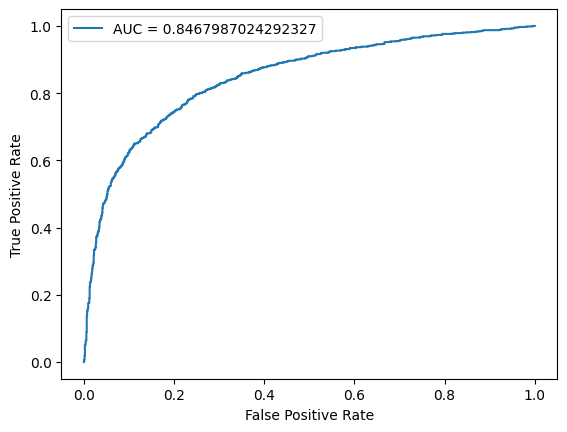

In [68]:
plot_auc(best_model, test_dataloader)

In [106]:
epochs = 40
optimizer = Adam(model.parameters(), 1e-2)
lossFn = BCEWithLogitsLoss()
history = train_model(model, optimizer, lossFn, epochs, lr, train_dataloader, val_dataloader)

118it [00:00, 120.23it/s]


Train Epoch: 0 	Loss: 0.663259, Accuracy: 5005/7500 (67%)
Val Epoch: 0 	Loss: 0.628697, Accuracy: 1797/2500 (72%)



118it [00:01, 102.90it/s]


Train Epoch: 1 	Loss: 0.569472, Accuracy: 5593/7500 (75%)
Val Epoch: 1 	Loss: 0.554084, Accuracy: 1839/2500 (74%)



118it [00:00, 126.05it/s]


Train Epoch: 2 	Loss: 0.529648, Accuracy: 5614/7500 (75%)
Val Epoch: 2 	Loss: 0.540692, Accuracy: 1839/2500 (74%)



118it [00:00, 147.16it/s]


Train Epoch: 3 	Loss: 0.521168, Accuracy: 5638/7500 (75%)
Val Epoch: 3 	Loss: 0.540964, Accuracy: 1839/2500 (74%)



118it [00:00, 150.27it/s]


Train Epoch: 4 	Loss: 0.519924, Accuracy: 5628/7500 (75%)
Val Epoch: 4 	Loss: 0.538054, Accuracy: 1851/2500 (74%)



118it [00:00, 189.46it/s]


Train Epoch: 5 	Loss: 0.513636, Accuracy: 5658/7500 (75%)
Val Epoch: 5 	Loss: 0.532537, Accuracy: 1862/2500 (74%)



118it [00:00, 162.31it/s]


Train Epoch: 6 	Loss: 0.514516, Accuracy: 5661/7500 (75%)
Val Epoch: 6 	Loss: 0.537451, Accuracy: 1859/2500 (74%)



118it [00:00, 137.56it/s]


Train Epoch: 7 	Loss: 0.510633, Accuracy: 5676/7500 (76%)
Val Epoch: 7 	Loss: 0.535905, Accuracy: 1862/2500 (74%)



118it [00:00, 131.58it/s]


Train Epoch: 8 	Loss: 0.509031, Accuracy: 5696/7500 (76%)
Val Epoch: 8 	Loss: 0.537191, Accuracy: 1871/2500 (75%)



118it [00:00, 142.15it/s]


Train Epoch: 9 	Loss: 0.508605, Accuracy: 5709/7500 (76%)
Val Epoch: 9 	Loss: 0.537833, Accuracy: 1868/2500 (75%)



118it [00:00, 187.93it/s]


Train Epoch: 10 	Loss: 0.505370, Accuracy: 5704/7500 (76%)
Val Epoch: 10 	Loss: 0.524298, Accuracy: 1860/2500 (74%)



118it [00:00, 127.43it/s]


Train Epoch: 11 	Loss: 0.502605, Accuracy: 5710/7500 (76%)
Val Epoch: 11 	Loss: 0.525553, Accuracy: 1868/2500 (75%)



118it [00:00, 154.17it/s]


Train Epoch: 12 	Loss: 0.500607, Accuracy: 5730/7500 (76%)
Val Epoch: 12 	Loss: 0.528313, Accuracy: 1871/2500 (75%)



118it [00:00, 151.84it/s]


Train Epoch: 13 	Loss: 0.501197, Accuracy: 5734/7500 (76%)
Val Epoch: 13 	Loss: 0.531990, Accuracy: 1864/2500 (75%)



118it [00:00, 182.40it/s]


Train Epoch: 14 	Loss: 0.499848, Accuracy: 5751/7500 (77%)
Val Epoch: 14 	Loss: 0.520664, Accuracy: 1871/2500 (75%)



118it [00:00, 174.43it/s]


Train Epoch: 15 	Loss: 0.498038, Accuracy: 5763/7500 (77%)
Val Epoch: 15 	Loss: 0.524885, Accuracy: 1875/2500 (75%)



118it [00:00, 162.86it/s]


Train Epoch: 16 	Loss: 0.498725, Accuracy: 5731/7500 (76%)
Val Epoch: 16 	Loss: 0.519440, Accuracy: 1859/2500 (74%)



118it [00:00, 194.68it/s]


Train Epoch: 17 	Loss: 0.495908, Accuracy: 5764/7500 (77%)
Val Epoch: 17 	Loss: 0.521057, Accuracy: 1865/2500 (75%)



118it [00:00, 193.58it/s]


Train Epoch: 18 	Loss: 0.496037, Accuracy: 5783/7500 (77%)
Val Epoch: 18 	Loss: 0.525774, Accuracy: 1852/2500 (74%)



118it [00:00, 183.20it/s]


Train Epoch: 19 	Loss: 0.496939, Accuracy: 5761/7500 (77%)
Val Epoch: 19 	Loss: 0.520592, Accuracy: 1864/2500 (75%)



118it [00:00, 188.23it/s]


Train Epoch: 20 	Loss: 0.497095, Accuracy: 5754/7500 (77%)
Val Epoch: 20 	Loss: 0.517128, Accuracy: 1869/2500 (75%)



118it [00:00, 190.97it/s]


Train Epoch: 21 	Loss: 0.494315, Accuracy: 5744/7500 (77%)
Val Epoch: 21 	Loss: 0.531806, Accuracy: 1888/2500 (76%)



118it [00:00, 188.35it/s]


Train Epoch: 22 	Loss: 0.494490, Accuracy: 5749/7500 (77%)
Val Epoch: 22 	Loss: 0.522250, Accuracy: 1885/2500 (75%)



118it [00:00, 187.46it/s]


Train Epoch: 23 	Loss: 0.493914, Accuracy: 5743/7500 (77%)
Val Epoch: 23 	Loss: 0.524095, Accuracy: 1870/2500 (75%)



118it [00:00, 191.66it/s]


Train Epoch: 24 	Loss: 0.494183, Accuracy: 5759/7500 (77%)
Val Epoch: 24 	Loss: 0.520638, Accuracy: 1867/2500 (75%)



118it [00:00, 190.18it/s]


Train Epoch: 25 	Loss: 0.493797, Accuracy: 5768/7500 (77%)
Val Epoch: 25 	Loss: 0.520515, Accuracy: 1877/2500 (75%)



118it [00:00, 194.20it/s]


Train Epoch: 26 	Loss: 0.494474, Accuracy: 5752/7500 (77%)
Val Epoch: 26 	Loss: 0.516899, Accuracy: 1872/2500 (75%)



118it [00:00, 183.97it/s]


Train Epoch: 27 	Loss: 0.495654, Accuracy: 5768/7500 (77%)
Val Epoch: 27 	Loss: 0.524539, Accuracy: 1871/2500 (75%)



118it [00:00, 182.74it/s]


Train Epoch: 28 	Loss: 0.493594, Accuracy: 5767/7500 (77%)
Val Epoch: 28 	Loss: 0.520767, Accuracy: 1869/2500 (75%)



118it [00:00, 145.96it/s]


Train Epoch: 29 	Loss: 0.494357, Accuracy: 5785/7500 (77%)
Val Epoch: 29 	Loss: 0.513933, Accuracy: 1867/2500 (75%)



118it [00:00, 140.74it/s]


Train Epoch: 30 	Loss: 0.492707, Accuracy: 5772/7500 (77%)
Val Epoch: 30 	Loss: 0.514575, Accuracy: 1875/2500 (75%)



118it [00:00, 129.65it/s]


Train Epoch: 31 	Loss: 0.493486, Accuracy: 5783/7500 (77%)
Val Epoch: 31 	Loss: 0.525121, Accuracy: 1878/2500 (75%)



118it [00:00, 164.54it/s]


Train Epoch: 32 	Loss: 0.492950, Accuracy: 5781/7500 (77%)
Val Epoch: 32 	Loss: 0.521939, Accuracy: 1880/2500 (75%)



118it [00:00, 199.18it/s]


Train Epoch: 33 	Loss: 0.491077, Accuracy: 5781/7500 (77%)
Val Epoch: 33 	Loss: 0.539144, Accuracy: 1868/2500 (75%)



118it [00:00, 174.23it/s]


Train Epoch: 34 	Loss: 0.491214, Accuracy: 5795/7500 (77%)
Val Epoch: 34 	Loss: 0.512134, Accuracy: 1875/2500 (75%)



118it [00:00, 188.61it/s]


Train Epoch: 35 	Loss: 0.493938, Accuracy: 5760/7500 (77%)
Val Epoch: 35 	Loss: 0.515868, Accuracy: 1873/2500 (75%)



118it [00:00, 192.64it/s]


Train Epoch: 36 	Loss: 0.492204, Accuracy: 5791/7500 (77%)
Val Epoch: 36 	Loss: 0.524610, Accuracy: 1874/2500 (75%)



118it [00:00, 190.83it/s]


Train Epoch: 37 	Loss: 0.495543, Accuracy: 5784/7500 (77%)
Val Epoch: 37 	Loss: 0.516401, Accuracy: 1894/2500 (76%)



118it [00:00, 194.76it/s]


Train Epoch: 38 	Loss: 0.491385, Accuracy: 5772/7500 (77%)
Val Epoch: 38 	Loss: 0.518431, Accuracy: 1876/2500 (75%)



118it [00:00, 184.31it/s]


Train Epoch: 39 	Loss: 0.491228, Accuracy: 5791/7500 (77%)
Val Epoch: 39 	Loss: 0.522705, Accuracy: 1892/2500 (76%)



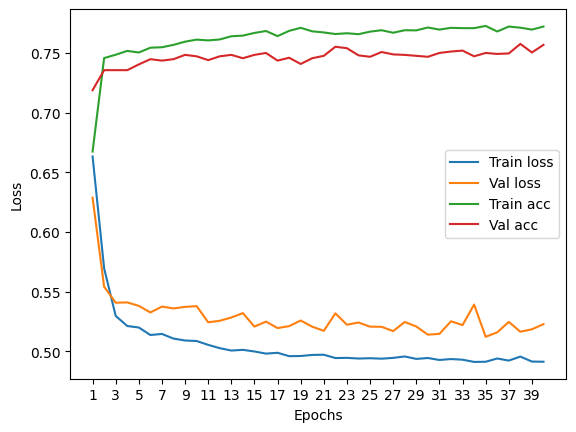

In [107]:
plot_loss(history)

Test accuracy:  78.64


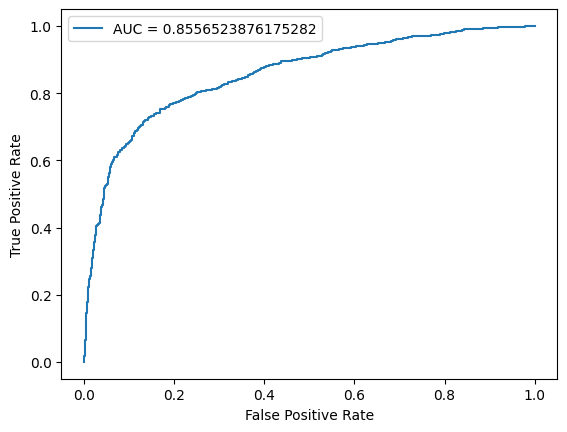

In [111]:
plot_auc(model, test_dataloader)

In [201]:
[p.numel() for p in model.parameters()]

[8, 64, 8, 1]

#### With 2 particles

In [76]:
hidden_dims = [8]
model = GNN(input_dims,hidden_dims,output_dims, activ_fn=ReLU())
model

GNN(
  (layers): ModuleList(
    (0): GCNConv(8, 8)
  )
  (activ_fn): ReLU()
  (classifier): Sequential(
    (0): Linear(in_features=9, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=1, bias=True)
  )
)

In [77]:
epochs = 40
optimizer = Adam(model.parameters(), 1e-2)
lossFn = BCEWithLogitsLoss()
history, best_model = train_model(model, optimizer, lossFn, epochs, lr, train_dataloader, val_dataloader)

118it [00:00, 149.52it/s]


Train Epoch: 0 	Loss: 0.596202, Accuracy: 5254/7500 (70%)
Val Epoch: 0 	Loss: 0.505540, Accuracy: 1916/2500 (77%)



118it [00:00, 165.54it/s]


Train Epoch: 1 	Loss: 0.504763, Accuracy: 5760/7500 (77%)
Val Epoch: 1 	Loss: 0.499268, Accuracy: 1911/2500 (76%)



118it [00:00, 147.63it/s]


Train Epoch: 2 	Loss: 0.498875, Accuracy: 5783/7500 (77%)
Val Epoch: 2 	Loss: 0.497469, Accuracy: 1925/2500 (77%)



118it [00:00, 162.41it/s]


Train Epoch: 3 	Loss: 0.493198, Accuracy: 5824/7500 (78%)
Val Epoch: 3 	Loss: 0.481516, Accuracy: 1926/2500 (77%)



118it [00:00, 151.06it/s]


Train Epoch: 4 	Loss: 0.492164, Accuracy: 5804/7500 (77%)
Val Epoch: 4 	Loss: 0.492733, Accuracy: 1933/2500 (77%)



118it [00:00, 159.97it/s]


Train Epoch: 5 	Loss: 0.487729, Accuracy: 5809/7500 (77%)
Val Epoch: 5 	Loss: 0.488303, Accuracy: 1923/2500 (77%)



118it [00:00, 159.70it/s]


Train Epoch: 6 	Loss: 0.490467, Accuracy: 5824/7500 (78%)
Val Epoch: 6 	Loss: 0.479180, Accuracy: 1926/2500 (77%)



118it [00:00, 138.80it/s]


Train Epoch: 7 	Loss: 0.491628, Accuracy: 5801/7500 (77%)
Val Epoch: 7 	Loss: 0.489043, Accuracy: 1936/2500 (77%)



118it [00:00, 141.47it/s]


Train Epoch: 8 	Loss: 0.490775, Accuracy: 5787/7500 (77%)
Val Epoch: 8 	Loss: 0.498900, Accuracy: 1925/2500 (77%)



118it [00:00, 158.99it/s]


Train Epoch: 9 	Loss: 0.494915, Accuracy: 5793/7500 (77%)
Val Epoch: 9 	Loss: 0.485332, Accuracy: 1929/2500 (77%)



118it [00:00, 157.35it/s]


Train Epoch: 10 	Loss: 0.495207, Accuracy: 5798/7500 (77%)
Val Epoch: 10 	Loss: 0.475378, Accuracy: 1929/2500 (77%)



118it [00:00, 155.21it/s]


Train Epoch: 11 	Loss: 0.490166, Accuracy: 5819/7500 (78%)
Val Epoch: 11 	Loss: 0.495531, Accuracy: 1936/2500 (77%)



118it [00:00, 146.71it/s]


Train Epoch: 12 	Loss: 0.487749, Accuracy: 5812/7500 (77%)
Val Epoch: 12 	Loss: 0.489886, Accuracy: 1926/2500 (77%)



118it [00:00, 198.31it/s]


Train Epoch: 13 	Loss: 0.489411, Accuracy: 5798/7500 (77%)
Val Epoch: 13 	Loss: 0.481597, Accuracy: 1938/2500 (78%)



118it [00:00, 148.82it/s]


Train Epoch: 14 	Loss: 0.490461, Accuracy: 5797/7500 (77%)
Val Epoch: 14 	Loss: 0.487825, Accuracy: 1926/2500 (77%)



118it [00:00, 145.54it/s]


Train Epoch: 15 	Loss: 0.487548, Accuracy: 5810/7500 (77%)
Val Epoch: 15 	Loss: 0.479016, Accuracy: 1916/2500 (77%)



118it [00:00, 154.85it/s]


Train Epoch: 16 	Loss: 0.491813, Accuracy: 5802/7500 (77%)
Val Epoch: 16 	Loss: 0.493733, Accuracy: 1935/2500 (77%)



118it [00:00, 172.39it/s]


Train Epoch: 17 	Loss: 0.487507, Accuracy: 5820/7500 (78%)
Val Epoch: 17 	Loss: 0.480880, Accuracy: 1932/2500 (77%)



118it [00:00, 159.02it/s]


Train Epoch: 18 	Loss: 0.485377, Accuracy: 5821/7500 (78%)
Val Epoch: 18 	Loss: 0.485132, Accuracy: 1928/2500 (77%)



118it [00:00, 177.01it/s]


Train Epoch: 19 	Loss: 0.486549, Accuracy: 5797/7500 (77%)
Val Epoch: 19 	Loss: 0.486509, Accuracy: 1926/2500 (77%)



118it [00:00, 153.63it/s]


Train Epoch: 20 	Loss: 0.487054, Accuracy: 5813/7500 (78%)
Val Epoch: 20 	Loss: 0.485508, Accuracy: 1936/2500 (77%)



118it [00:00, 150.03it/s]


Train Epoch: 21 	Loss: 0.487305, Accuracy: 5808/7500 (77%)
Val Epoch: 21 	Loss: 0.493759, Accuracy: 1927/2500 (77%)



118it [00:00, 162.95it/s]


Train Epoch: 22 	Loss: 0.488714, Accuracy: 5805/7500 (77%)
Val Epoch: 22 	Loss: 0.473125, Accuracy: 1929/2500 (77%)



118it [00:00, 167.50it/s]


Train Epoch: 23 	Loss: 0.485123, Accuracy: 5833/7500 (78%)
Val Epoch: 23 	Loss: 0.477604, Accuracy: 1927/2500 (77%)



118it [00:00, 161.53it/s]


Train Epoch: 24 	Loss: 0.487715, Accuracy: 5841/7500 (78%)
Val Epoch: 24 	Loss: 0.479946, Accuracy: 1916/2500 (77%)



118it [00:00, 161.92it/s]


Train Epoch: 25 	Loss: 0.488052, Accuracy: 5811/7500 (77%)
Val Epoch: 25 	Loss: 0.480751, Accuracy: 1937/2500 (77%)



118it [00:00, 146.45it/s]


Train Epoch: 26 	Loss: 0.488108, Accuracy: 5795/7500 (77%)
Val Epoch: 26 	Loss: 0.477941, Accuracy: 1924/2500 (77%)



118it [00:00, 156.64it/s]


Train Epoch: 27 	Loss: 0.484340, Accuracy: 5830/7500 (78%)
Val Epoch: 27 	Loss: 0.491289, Accuracy: 1925/2500 (77%)



118it [00:00, 143.19it/s]


Train Epoch: 28 	Loss: 0.487648, Accuracy: 5833/7500 (78%)
Val Epoch: 28 	Loss: 0.490727, Accuracy: 1935/2500 (77%)



118it [00:00, 146.58it/s]


Train Epoch: 29 	Loss: 0.488106, Accuracy: 5823/7500 (78%)
Val Epoch: 29 	Loss: 0.486335, Accuracy: 1933/2500 (77%)



118it [00:00, 157.44it/s]


Train Epoch: 30 	Loss: 0.485515, Accuracy: 5801/7500 (77%)
Val Epoch: 30 	Loss: 0.482475, Accuracy: 1926/2500 (77%)



118it [00:00, 172.77it/s]


Train Epoch: 31 	Loss: 0.486234, Accuracy: 5853/7500 (78%)
Val Epoch: 31 	Loss: 0.482968, Accuracy: 1934/2500 (77%)



118it [00:00, 153.71it/s]


Train Epoch: 32 	Loss: 0.486274, Accuracy: 5817/7500 (78%)
Val Epoch: 32 	Loss: 0.477340, Accuracy: 1931/2500 (77%)



118it [00:00, 157.40it/s]


Train Epoch: 33 	Loss: 0.487317, Accuracy: 5830/7500 (78%)
Val Epoch: 33 	Loss: 0.493841, Accuracy: 1922/2500 (77%)



118it [00:00, 148.80it/s]


Train Epoch: 34 	Loss: 0.485002, Accuracy: 5835/7500 (78%)
Val Epoch: 34 	Loss: 0.476550, Accuracy: 1935/2500 (77%)



118it [00:00, 167.04it/s]


Train Epoch: 35 	Loss: 0.485734, Accuracy: 5835/7500 (78%)
Val Epoch: 35 	Loss: 0.492301, Accuracy: 1939/2500 (78%)



118it [00:00, 155.13it/s]


Train Epoch: 36 	Loss: 0.484825, Accuracy: 5833/7500 (78%)
Val Epoch: 36 	Loss: 0.479000, Accuracy: 1929/2500 (77%)



118it [00:00, 140.44it/s]


Train Epoch: 37 	Loss: 0.485990, Accuracy: 5837/7500 (78%)
Val Epoch: 37 	Loss: 0.487000, Accuracy: 1930/2500 (77%)



118it [00:00, 160.67it/s]


Train Epoch: 38 	Loss: 0.486334, Accuracy: 5828/7500 (78%)
Val Epoch: 38 	Loss: 0.478941, Accuracy: 1932/2500 (77%)



118it [00:00, 157.12it/s]


Train Epoch: 39 	Loss: 0.484409, Accuracy: 5816/7500 (78%)
Val Epoch: 39 	Loss: 0.482109, Accuracy: 1934/2500 (77%)



Test accuracy:  77.56


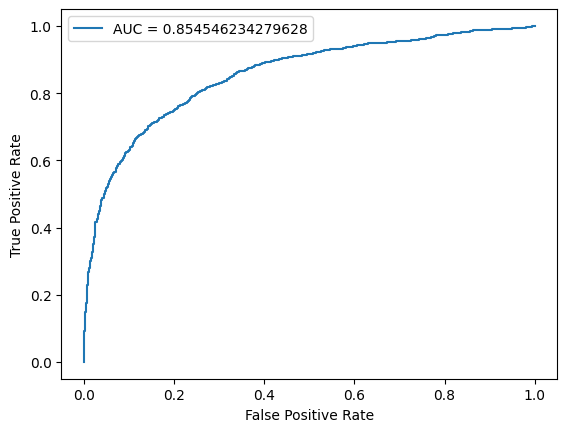

In [78]:
plot_auc(best_model, test_dataloader)

#### With 1 particle

In [86]:
hidden_dims = [8]
model = GNN(input_dims,hidden_dims,output_dims, activ_fn=ReLU())
model

GNN(
  (layers): ModuleList(
    (0): GCNConv(8, 8)
  )
  (activ_fn): ReLU()
  (classifier): Sequential(
    (0): Linear(in_features=9, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=1, bias=True)
  )
)

In [87]:
epochs = 40
optimizer = Adam(model.parameters(), 1e-2)
lossFn = BCEWithLogitsLoss()
history, best_model = train_model(model, optimizer, lossFn, epochs, lr, train_dataloader, val_dataloader)

118it [00:00, 137.70it/s]


Train Epoch: 0 	Loss: 0.596637, Accuracy: 5186/7500 (69%)
Val Epoch: 0 	Loss: 0.549479, Accuracy: 1839/2500 (74%)



118it [00:00, 139.94it/s]


Train Epoch: 1 	Loss: 0.500792, Accuracy: 5780/7500 (77%)
Val Epoch: 1 	Loss: 0.545768, Accuracy: 1901/2500 (76%)



118it [00:00, 140.69it/s]


Train Epoch: 2 	Loss: 0.488657, Accuracy: 5796/7500 (77%)
Val Epoch: 2 	Loss: 0.516374, Accuracy: 1888/2500 (76%)



118it [00:00, 159.39it/s]


Train Epoch: 3 	Loss: 0.483421, Accuracy: 5845/7500 (78%)
Val Epoch: 3 	Loss: 0.519087, Accuracy: 1886/2500 (75%)



118it [00:00, 158.75it/s]


Train Epoch: 4 	Loss: 0.481739, Accuracy: 5819/7500 (78%)
Val Epoch: 4 	Loss: 0.511849, Accuracy: 1898/2500 (76%)



118it [00:00, 160.81it/s]


Train Epoch: 5 	Loss: 0.481182, Accuracy: 5822/7500 (78%)
Val Epoch: 5 	Loss: 0.508665, Accuracy: 1906/2500 (76%)



118it [00:00, 152.67it/s]


Train Epoch: 6 	Loss: 0.481062, Accuracy: 5840/7500 (78%)
Val Epoch: 6 	Loss: 0.522353, Accuracy: 1906/2500 (76%)



118it [00:00, 165.16it/s]


Train Epoch: 7 	Loss: 0.478495, Accuracy: 5836/7500 (78%)
Val Epoch: 7 	Loss: 0.521843, Accuracy: 1904/2500 (76%)



118it [00:00, 136.02it/s]


Train Epoch: 8 	Loss: 0.479358, Accuracy: 5834/7500 (78%)
Val Epoch: 8 	Loss: 0.508226, Accuracy: 1907/2500 (76%)



118it [00:00, 163.03it/s]


Train Epoch: 9 	Loss: 0.480618, Accuracy: 5829/7500 (78%)
Val Epoch: 9 	Loss: 0.509573, Accuracy: 1890/2500 (76%)



118it [00:00, 161.88it/s]


Train Epoch: 10 	Loss: 0.476726, Accuracy: 5846/7500 (78%)
Val Epoch: 10 	Loss: 0.539449, Accuracy: 1870/2500 (75%)



118it [00:00, 153.19it/s]


Train Epoch: 11 	Loss: 0.475786, Accuracy: 5830/7500 (78%)
Val Epoch: 11 	Loss: 0.558643, Accuracy: 1900/2500 (76%)



118it [00:00, 150.68it/s]


Train Epoch: 12 	Loss: 0.476590, Accuracy: 5854/7500 (78%)
Val Epoch: 12 	Loss: 0.502191, Accuracy: 1912/2500 (76%)



118it [00:00, 149.88it/s]


Train Epoch: 13 	Loss: 0.476107, Accuracy: 5820/7500 (78%)
Val Epoch: 13 	Loss: 0.522910, Accuracy: 1886/2500 (75%)



118it [00:00, 170.38it/s]


Train Epoch: 14 	Loss: 0.477281, Accuracy: 5842/7500 (78%)
Val Epoch: 14 	Loss: 0.519414, Accuracy: 1909/2500 (76%)



118it [00:00, 169.95it/s]


Train Epoch: 15 	Loss: 0.477022, Accuracy: 5835/7500 (78%)
Val Epoch: 15 	Loss: 0.512381, Accuracy: 1914/2500 (77%)



118it [00:00, 182.55it/s]


Train Epoch: 16 	Loss: 0.477607, Accuracy: 5842/7500 (78%)
Val Epoch: 16 	Loss: 0.508110, Accuracy: 1904/2500 (76%)



118it [00:00, 169.97it/s]


Train Epoch: 17 	Loss: 0.474818, Accuracy: 5851/7500 (78%)
Val Epoch: 17 	Loss: 0.522605, Accuracy: 1907/2500 (76%)



118it [00:00, 159.47it/s]


Train Epoch: 18 	Loss: 0.479136, Accuracy: 5823/7500 (78%)
Val Epoch: 18 	Loss: 0.503931, Accuracy: 1913/2500 (77%)



118it [00:00, 163.47it/s]


Train Epoch: 19 	Loss: 0.477045, Accuracy: 5837/7500 (78%)
Val Epoch: 19 	Loss: 0.508093, Accuracy: 1903/2500 (76%)



118it [00:00, 176.27it/s]


Train Epoch: 20 	Loss: 0.474872, Accuracy: 5864/7500 (78%)
Val Epoch: 20 	Loss: 0.508009, Accuracy: 1904/2500 (76%)



118it [00:00, 150.50it/s]


Train Epoch: 21 	Loss: 0.476087, Accuracy: 5842/7500 (78%)
Val Epoch: 21 	Loss: 0.517675, Accuracy: 1910/2500 (76%)



118it [00:00, 161.91it/s]


Train Epoch: 22 	Loss: 0.475123, Accuracy: 5852/7500 (78%)
Val Epoch: 22 	Loss: 0.501058, Accuracy: 1918/2500 (77%)



118it [00:00, 170.11it/s]


Train Epoch: 23 	Loss: 0.474737, Accuracy: 5851/7500 (78%)
Val Epoch: 23 	Loss: 0.505783, Accuracy: 1904/2500 (76%)



118it [00:00, 188.73it/s]


Train Epoch: 24 	Loss: 0.475140, Accuracy: 5846/7500 (78%)
Val Epoch: 24 	Loss: 0.505552, Accuracy: 1905/2500 (76%)



118it [00:00, 157.72it/s]


Train Epoch: 25 	Loss: 0.475516, Accuracy: 5850/7500 (78%)
Val Epoch: 25 	Loss: 0.517905, Accuracy: 1889/2500 (76%)



118it [00:00, 139.41it/s]


Train Epoch: 26 	Loss: 0.478324, Accuracy: 5841/7500 (78%)
Val Epoch: 26 	Loss: 0.518234, Accuracy: 1892/2500 (76%)



118it [00:00, 149.78it/s]


Train Epoch: 27 	Loss: 0.475571, Accuracy: 5834/7500 (78%)
Val Epoch: 27 	Loss: 0.512581, Accuracy: 1911/2500 (76%)



118it [00:00, 186.01it/s]


Train Epoch: 28 	Loss: 0.479133, Accuracy: 5845/7500 (78%)
Val Epoch: 28 	Loss: 0.521091, Accuracy: 1910/2500 (76%)



118it [00:00, 154.86it/s]


Train Epoch: 29 	Loss: 0.476875, Accuracy: 5862/7500 (78%)
Val Epoch: 29 	Loss: 0.502462, Accuracy: 1904/2500 (76%)



118it [00:00, 153.13it/s]


Train Epoch: 30 	Loss: 0.476452, Accuracy: 5858/7500 (78%)
Val Epoch: 30 	Loss: 0.509653, Accuracy: 1910/2500 (76%)



118it [00:00, 178.67it/s]


Train Epoch: 31 	Loss: 0.475297, Accuracy: 5841/7500 (78%)
Val Epoch: 31 	Loss: 0.520294, Accuracy: 1912/2500 (76%)



118it [00:00, 171.54it/s]


Train Epoch: 32 	Loss: 0.475747, Accuracy: 5861/7500 (78%)
Val Epoch: 32 	Loss: 0.506187, Accuracy: 1919/2500 (77%)



118it [00:00, 147.68it/s]


Train Epoch: 33 	Loss: 0.475506, Accuracy: 5855/7500 (78%)
Val Epoch: 33 	Loss: 0.510586, Accuracy: 1916/2500 (77%)



118it [00:00, 148.40it/s]


Train Epoch: 34 	Loss: 0.475972, Accuracy: 5842/7500 (78%)
Val Epoch: 34 	Loss: 0.505932, Accuracy: 1909/2500 (76%)



118it [00:00, 124.48it/s]


Train Epoch: 35 	Loss: 0.474590, Accuracy: 5850/7500 (78%)
Val Epoch: 35 	Loss: 0.526864, Accuracy: 1910/2500 (76%)



118it [00:00, 171.38it/s]


Train Epoch: 36 	Loss: 0.478526, Accuracy: 5842/7500 (78%)
Val Epoch: 36 	Loss: 0.511112, Accuracy: 1903/2500 (76%)



118it [00:00, 138.34it/s]


Train Epoch: 37 	Loss: 0.475141, Accuracy: 5865/7500 (78%)
Val Epoch: 37 	Loss: 0.510995, Accuracy: 1915/2500 (77%)



118it [00:00, 158.90it/s]


Train Epoch: 38 	Loss: 0.475873, Accuracy: 5853/7500 (78%)
Val Epoch: 38 	Loss: 0.513944, Accuracy: 1901/2500 (76%)



118it [00:00, 148.88it/s]


Train Epoch: 39 	Loss: 0.476204, Accuracy: 5844/7500 (78%)
Val Epoch: 39 	Loss: 0.508030, Accuracy: 1907/2500 (76%)



Test accuracy:  76.64


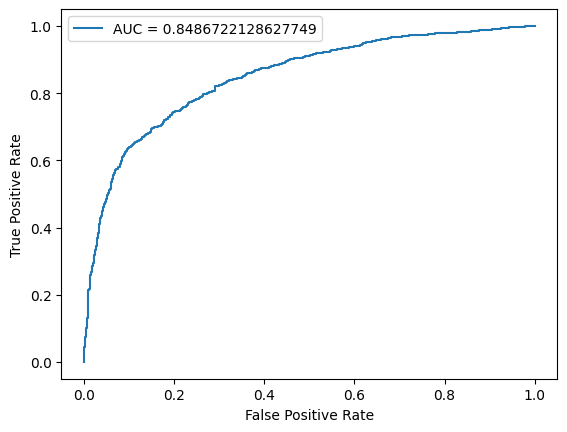

In [88]:
plot_auc(best_model, test_dataloader)

All particles

In [74]:
epochs = 40
optimizer = Adam(model.parameters(), 1e-2)
lossFn = BCEWithLogitsLoss()
history = train_model(model, optimizer, lossFn, epochs, lr, train_dataloader, val_dataloader)

59it [00:12,  4.74it/s]


Train Epoch: 0 	Loss: 0.696536, Accuracy: 31514/60000 (53%)
Val Epoch: 0 	Loss: 0.704295, Accuracy: 10596/20000 (53%)



59it [00:12,  4.61it/s]


Train Epoch: 1 	Loss: 0.685580, Accuracy: 35355/60000 (59%)
Val Epoch: 1 	Loss: 0.687857, Accuracy: 11956/20000 (60%)



59it [00:12,  4.71it/s]


Train Epoch: 2 	Loss: 0.663773, Accuracy: 39391/60000 (66%)
Val Epoch: 2 	Loss: 0.659560, Accuracy: 13819/20000 (69%)



59it [00:12,  4.66it/s]


Train Epoch: 3 	Loss: 0.634126, Accuracy: 43049/60000 (72%)
Val Epoch: 3 	Loss: 0.626571, Accuracy: 14706/20000 (74%)



59it [00:12,  4.61it/s]


Train Epoch: 4 	Loss: 0.601707, Accuracy: 44359/60000 (74%)
Val Epoch: 4 	Loss: 0.593436, Accuracy: 15001/20000 (75%)



59it [00:12,  4.68it/s]


Train Epoch: 5 	Loss: 0.572703, Accuracy: 44934/60000 (75%)
Val Epoch: 5 	Loss: 0.568396, Accuracy: 15131/20000 (76%)



59it [00:12,  4.55it/s]


Train Epoch: 6 	Loss: 0.551854, Accuracy: 45220/60000 (75%)
Val Epoch: 6 	Loss: 0.549481, Accuracy: 15138/20000 (76%)



59it [00:12,  4.58it/s]


Train Epoch: 7 	Loss: 0.537619, Accuracy: 45375/60000 (76%)
Val Epoch: 7 	Loss: 0.539024, Accuracy: 15153/20000 (76%)



59it [00:12,  4.59it/s]


Train Epoch: 8 	Loss: 0.528234, Accuracy: 45442/60000 (76%)
Val Epoch: 8 	Loss: 0.531293, Accuracy: 15223/20000 (76%)



59it [00:12,  4.57it/s]


Train Epoch: 9 	Loss: 0.521590, Accuracy: 45529/60000 (76%)
Val Epoch: 9 	Loss: 0.524632, Accuracy: 15228/20000 (76%)



59it [00:12,  4.64it/s]


Train Epoch: 10 	Loss: 0.517687, Accuracy: 45568/60000 (76%)
Val Epoch: 10 	Loss: 0.520608, Accuracy: 15267/20000 (76%)



59it [00:10,  5.38it/s]


Train Epoch: 11 	Loss: 0.513577, Accuracy: 45714/60000 (76%)
Val Epoch: 11 	Loss: 0.521875, Accuracy: 15106/20000 (76%)



59it [00:06,  9.78it/s]


Train Epoch: 12 	Loss: 0.511120, Accuracy: 45723/60000 (76%)
Val Epoch: 12 	Loss: 0.515825, Accuracy: 15272/20000 (76%)



59it [00:05, 10.53it/s]


Train Epoch: 13 	Loss: 0.510392, Accuracy: 45790/60000 (76%)
Val Epoch: 13 	Loss: 0.514065, Accuracy: 15292/20000 (76%)



59it [00:05, 10.93it/s]


Train Epoch: 14 	Loss: 0.509342, Accuracy: 45779/60000 (76%)
Val Epoch: 14 	Loss: 0.514797, Accuracy: 15200/20000 (76%)



59it [00:05, 11.18it/s]


Train Epoch: 15 	Loss: 0.509133, Accuracy: 45782/60000 (76%)
Val Epoch: 15 	Loss: 0.514156, Accuracy: 15303/20000 (77%)



59it [00:05, 10.54it/s]


Train Epoch: 16 	Loss: 0.507914, Accuracy: 45876/60000 (76%)
Val Epoch: 16 	Loss: 0.512050, Accuracy: 15328/20000 (77%)



59it [00:05, 11.47it/s]


Train Epoch: 17 	Loss: 0.507259, Accuracy: 45844/60000 (76%)
Val Epoch: 17 	Loss: 0.511637, Accuracy: 15302/20000 (77%)



59it [00:05, 11.60it/s]


Train Epoch: 18 	Loss: 0.507165, Accuracy: 45795/60000 (76%)
Val Epoch: 18 	Loss: 0.510969, Accuracy: 15322/20000 (77%)



59it [00:05, 11.27it/s]


Train Epoch: 19 	Loss: 0.506783, Accuracy: 45905/60000 (77%)
Val Epoch: 19 	Loss: 0.511055, Accuracy: 15310/20000 (77%)



59it [00:05, 11.78it/s]


Train Epoch: 20 	Loss: 0.506388, Accuracy: 45898/60000 (76%)
Val Epoch: 20 	Loss: 0.511893, Accuracy: 15233/20000 (76%)



59it [00:05, 11.22it/s]


Train Epoch: 21 	Loss: 0.506920, Accuracy: 45898/60000 (76%)
Val Epoch: 21 	Loss: 0.512124, Accuracy: 15266/20000 (76%)



59it [00:05, 10.71it/s]


Train Epoch: 22 	Loss: 0.506745, Accuracy: 45929/60000 (77%)
Val Epoch: 22 	Loss: 0.512163, Accuracy: 15252/20000 (76%)



59it [00:05, 11.39it/s]


Train Epoch: 23 	Loss: 0.506383, Accuracy: 45892/60000 (76%)
Val Epoch: 23 	Loss: 0.509469, Accuracy: 15324/20000 (77%)



59it [00:05, 11.37it/s]


Train Epoch: 24 	Loss: 0.505812, Accuracy: 45912/60000 (77%)
Val Epoch: 24 	Loss: 0.509451, Accuracy: 15329/20000 (77%)



59it [00:05, 11.68it/s]


Train Epoch: 25 	Loss: 0.505699, Accuracy: 45951/60000 (77%)
Val Epoch: 25 	Loss: 0.508457, Accuracy: 15309/20000 (77%)



59it [00:04, 11.84it/s]


Train Epoch: 26 	Loss: 0.506010, Accuracy: 45969/60000 (77%)
Val Epoch: 26 	Loss: 0.509888, Accuracy: 15323/20000 (77%)



59it [00:05, 11.77it/s]


Train Epoch: 27 	Loss: 0.505091, Accuracy: 45955/60000 (77%)
Val Epoch: 27 	Loss: 0.511406, Accuracy: 15336/20000 (77%)



59it [00:05, 11.20it/s]


Train Epoch: 28 	Loss: 0.506501, Accuracy: 45888/60000 (76%)
Val Epoch: 28 	Loss: 0.509743, Accuracy: 15336/20000 (77%)



59it [00:05, 11.33it/s]


Train Epoch: 29 	Loss: 0.505219, Accuracy: 45950/60000 (77%)
Val Epoch: 29 	Loss: 0.508069, Accuracy: 15321/20000 (77%)



59it [00:05, 11.23it/s]


Train Epoch: 30 	Loss: 0.505024, Accuracy: 46019/60000 (77%)
Val Epoch: 30 	Loss: 0.509493, Accuracy: 15317/20000 (77%)



59it [00:05, 11.74it/s]


Train Epoch: 31 	Loss: 0.504993, Accuracy: 45955/60000 (77%)
Val Epoch: 31 	Loss: 0.510385, Accuracy: 15288/20000 (76%)



59it [00:04, 11.95it/s]


Train Epoch: 32 	Loss: 0.504780, Accuracy: 45980/60000 (77%)
Val Epoch: 32 	Loss: 0.511299, Accuracy: 15315/20000 (77%)



59it [00:05, 11.50it/s]


Train Epoch: 33 	Loss: 0.505456, Accuracy: 45998/60000 (77%)
Val Epoch: 33 	Loss: 0.512209, Accuracy: 15243/20000 (76%)



59it [00:05, 11.71it/s]


Train Epoch: 34 	Loss: 0.505349, Accuracy: 45999/60000 (77%)
Val Epoch: 34 	Loss: 0.509559, Accuracy: 15335/20000 (77%)



59it [00:06,  9.82it/s]


Train Epoch: 35 	Loss: 0.505312, Accuracy: 45989/60000 (77%)
Val Epoch: 35 	Loss: 0.511932, Accuracy: 15241/20000 (76%)



59it [00:06,  9.61it/s]


Train Epoch: 36 	Loss: 0.505027, Accuracy: 46038/60000 (77%)
Val Epoch: 36 	Loss: 0.508716, Accuracy: 15356/20000 (77%)



59it [00:05, 10.46it/s]


Train Epoch: 37 	Loss: 0.505053, Accuracy: 46050/60000 (77%)
Val Epoch: 37 	Loss: 0.511930, Accuracy: 15242/20000 (76%)



59it [00:05, 11.17it/s]


Train Epoch: 38 	Loss: 0.504778, Accuracy: 46048/60000 (77%)
Val Epoch: 38 	Loss: 0.511470, Accuracy: 15278/20000 (76%)



59it [00:05, 11.43it/s]


Train Epoch: 39 	Loss: 0.503946, Accuracy: 46074/60000 (77%)
Val Epoch: 39 	Loss: 0.507980, Accuracy: 15343/20000 (77%)



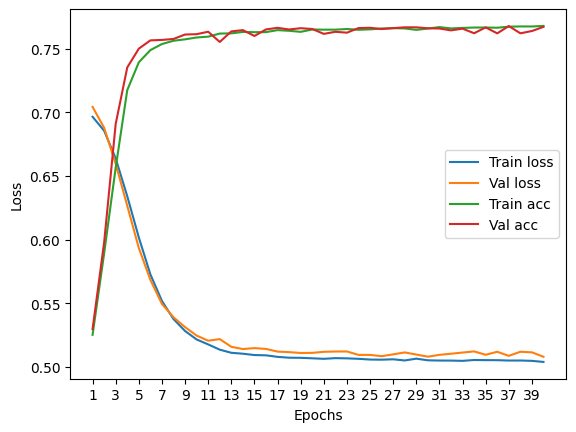

In [75]:
plot_loss(history)

Test accuracy:  76.63499999999999


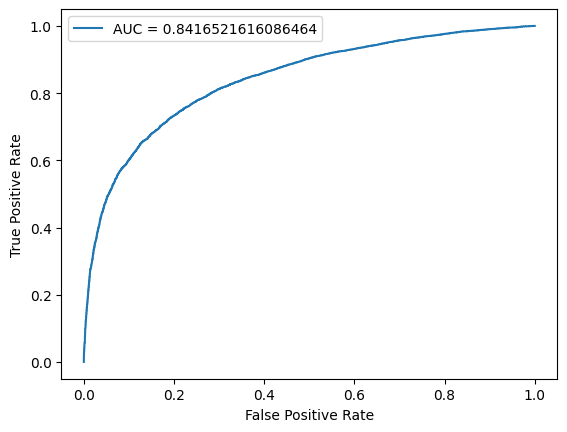

In [76]:
plot_auc(model, test_dataloader)

In [56]:
hidden_dims = [10,16,8]

In [57]:
model = GNN(input_dims,hidden_dims,output_dims, activ_fn=ReLU())
model

GNN(
  (layers): ModuleList(
    (0): GCNConv(8, 10)
    (1): GCNConv(10, 16)
    (2): GCNConv(16, 8)
  )
  (activ_fn): ReLU()
  (classifier): Linear(in_features=8, out_features=1, bias=True)
)

In [58]:
optimizer = Adam(model.parameters(), 1e-3)
lossFn = BCEWithLogitsLoss()
history = train_model(model, optimizer, lossFn, epochs, lr, train_dataloader, val_dataloader)

79it [00:03, 19.87it/s]


Train Epoch: 0 	Loss: 0.698829, Accuracy: 42091/79896 (53%)
Val Epoch: 0 	Loss: 0.702670, Accuracy: 5604/9987 (56%)



79it [00:04, 18.88it/s]


Train Epoch: 1 	Loss: 0.680527, Accuracy: 48441/79896 (61%)
Val Epoch: 1 	Loss: 0.668586, Accuracy: 6558/9987 (66%)



79it [00:04, 18.75it/s]


Train Epoch: 2 	Loss: 0.633803, Accuracy: 54245/79896 (68%)
Val Epoch: 2 	Loss: 0.612920, Accuracy: 6911/9987 (69%)



79it [00:04, 18.90it/s]


Train Epoch: 3 	Loss: 0.598705, Accuracy: 55889/79896 (70%)
Val Epoch: 3 	Loss: 0.601529, Accuracy: 7033/9987 (70%)



79it [00:04, 18.97it/s]


Train Epoch: 4 	Loss: 0.591351, Accuracy: 56448/79896 (71%)
Val Epoch: 4 	Loss: 0.592020, Accuracy: 7121/9987 (71%)



79it [00:04, 18.09it/s]


Train Epoch: 5 	Loss: 0.588481, Accuracy: 56561/79896 (71%)
Val Epoch: 5 	Loss: 0.591146, Accuracy: 7096/9987 (71%)



79it [00:04, 17.34it/s]


Train Epoch: 6 	Loss: 0.587961, Accuracy: 56657/79896 (71%)
Val Epoch: 6 	Loss: 0.589951, Accuracy: 7103/9987 (71%)



79it [00:04, 17.04it/s]


Train Epoch: 7 	Loss: 0.584895, Accuracy: 56693/79896 (71%)
Val Epoch: 7 	Loss: 0.589498, Accuracy: 7124/9987 (71%)



79it [00:04, 19.57it/s]


Train Epoch: 8 	Loss: 0.585628, Accuracy: 56832/79896 (71%)
Val Epoch: 8 	Loss: 0.589170, Accuracy: 7146/9987 (72%)



79it [00:04, 16.63it/s]


Train Epoch: 9 	Loss: 0.583251, Accuracy: 56872/79896 (71%)
Val Epoch: 9 	Loss: 0.588685, Accuracy: 7141/9987 (72%)



79it [00:04, 18.78it/s]


Train Epoch: 10 	Loss: 0.587796, Accuracy: 56859/79896 (71%)
Val Epoch: 10 	Loss: 0.589522, Accuracy: 7155/9987 (72%)



79it [00:04, 19.26it/s]


Train Epoch: 11 	Loss: 0.585725, Accuracy: 56953/79896 (71%)
Val Epoch: 11 	Loss: 0.591743, Accuracy: 7124/9987 (71%)



79it [00:04, 17.24it/s]


Train Epoch: 12 	Loss: 0.584016, Accuracy: 56927/79896 (71%)
Val Epoch: 12 	Loss: 0.588487, Accuracy: 7145/9987 (72%)



79it [00:04, 18.52it/s]


Train Epoch: 13 	Loss: 0.583364, Accuracy: 56953/79896 (71%)
Val Epoch: 13 	Loss: 0.588656, Accuracy: 7140/9987 (71%)



79it [00:04, 19.13it/s]


Train Epoch: 14 	Loss: 0.586346, Accuracy: 57033/79896 (71%)
Val Epoch: 14 	Loss: 0.589230, Accuracy: 7129/9987 (71%)



79it [00:04, 18.89it/s]


Train Epoch: 15 	Loss: 0.582779, Accuracy: 56947/79896 (71%)
Val Epoch: 15 	Loss: 0.587191, Accuracy: 7168/9987 (72%)



79it [00:04, 17.44it/s]


Train Epoch: 16 	Loss: 0.582458, Accuracy: 57061/79896 (71%)
Val Epoch: 16 	Loss: 0.588331, Accuracy: 7170/9987 (72%)



79it [00:04, 17.10it/s]


Train Epoch: 17 	Loss: 0.582356, Accuracy: 57119/79896 (71%)
Val Epoch: 17 	Loss: 0.589423, Accuracy: 7158/9987 (72%)



79it [00:04, 18.63it/s]


Train Epoch: 18 	Loss: 0.584527, Accuracy: 57035/79896 (71%)
Val Epoch: 18 	Loss: 0.587681, Accuracy: 7154/9987 (72%)



79it [00:04, 16.81it/s]


Train Epoch: 19 	Loss: 0.582889, Accuracy: 57037/79896 (71%)
Val Epoch: 19 	Loss: 0.586277, Accuracy: 7182/9987 (72%)



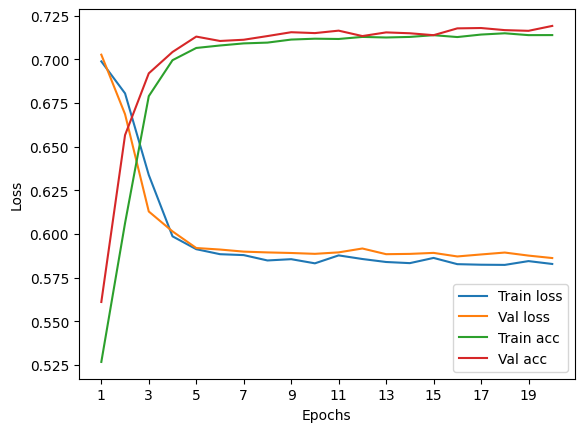

In [59]:
plot_loss(history)

Test accuracy:  72.03364373685791


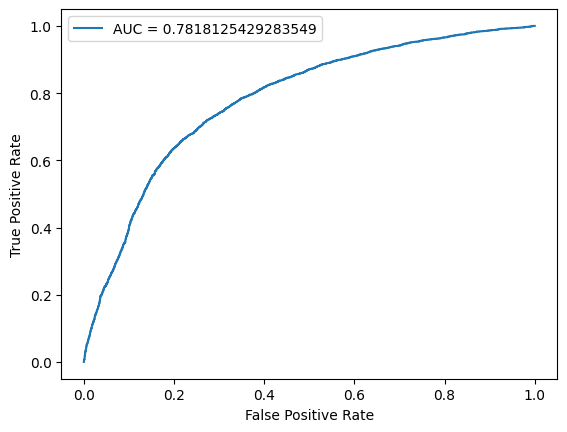

In [60]:
plot_auc(model, test_dataloader)

### Classical GAT - Custom Graph Attention Layer

In [64]:
class GATConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super().__init__(aggr='add')  # "Add" aggregation (Step 5).
#         self.heads = heads
#         seld.concat = concat
        self.lin = Linear(in_channels, out_channels, bias=False)
        self.attn = nn.Sequential(Linear(out_channels*2, 8),
                                  ReLU(),
                                  Linear(8,1),
                                  LeakyReLU(0.2)
                                 )
        total_out_channels = out_channels
        self.bias = nn.Parameter(torch.empty(total_out_channels))
        self.reset_parameters()

    def reset_parameters(self):
        super().reset_parameters()
        self.lin.reset_parameters()
        
        for layer in self.attn:
            if hasattr(layer, 'reset_parameters'):
                layer.reset_parameters()
        
        self.bias.data.zero_()

    def forward(self, x, edge_index, edge_attr):
        # x has shape [N, in_channels]
        # edge_index has shape [2, E]
        
        # H, C = self.heads, self.out_channels
        
        x = self.lin(x)    #.view(-1, H, C)

        # Step 1: Add self-loops to the adjacency matrix.
        edge_index, edge_attr = remove_self_loops(edge_index, edge_attr)
        edge_index, edge_attr = add_self_loops(edge_index, edge_attr, num_nodes=x.size(0))

        # alpha = self.edge_update(x_i, x_j, edge_attr=edge_attr)

        # propagate_type: (x: OptPairTensor, alpha: Tensor)
        out = self.propagate(edge_index, x=x)

        # out = out.mean(dim=1)

        # Step 6: Apply a final bias vector.
        out = out + self.bias

        return out


    def message(self, x_i, x_j):
        x_edge = torch.cat((x_i,x_j),dim=1)
        x_edge = self.attn(x_edge)
        return x_edge.view(-1,1) * x_j

In [49]:
class GAT(nn.Module):

    def __init__(self, input_dims, hidden_dims, output_dims, activ_fn = LeakyReLU(0.2)):
        
        super().__init__()
        layers = []
        layers.append(GATConv(input_dims, hidden_dims[0]))
    
        for i in range(len(hidden_dims)-1):
            layers.append(GATConv(hidden_dims[i], hidden_dims[i+1]))
            
        self.layers = ModuleList(layers)
        self.activ_fn = activ_fn
        self.classifier = Sequential(
                            Linear(hidden_dims[-1]+5, 8),
                            ReLU(),
                            Linear(8,1)
                          )

    def forward(self, x, edge_index, edge_attr, batch, graph_features):
        """
        Defining how tensors are supposed to move through the *dressed* quantum
        net.
        """
        
        h = x
        for i in range(len(self.layers)):
            h = self.layers[i](h, edge_index, edge_attr)
            h = self.activ_fn(h)
            
        h = global_mean_pool(h, batch)   # readout layer to get the embedding for each graph in batch
        h = torch.cat((h, graph_features.float().reshape(-1,5)), dim=1)
        h = self.classifier(h)
        return h

### Classical GCN - Custom GraphConv Layer

In [39]:
class GCNConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super().__init__(aggr='add')  # "Add" aggregation (Step 5).
        self.lin = Linear(in_channels, out_channels, bias=False)
        self.bias = nn.Parameter(torch.empty(out_channels))
        self.reset_parameters()

    def reset_parameters(self):
        self.bias.data.zero_()

    def forward(self, x, edge_index, edge_weight):
        # x has shape [N, in_channels]
        # edge_index has shape [2, E]

        # Step 1: Add self-loops to the adjacency matrix.
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))

        # Step 2: Linearly transform node feature matrix.
        # Apply the quantum circuit to each element of the batch and append to q_out
#         q_out = torch.Tensor(0, self.n_qubits)
        
#         for xi in x:
#             q_out_elem = self.qc(xi).float().unsqueeze(0)
#             q_out = torch.cat((q_out, q_out_elem))
        out = self.lin(x)

        # Step 3: Compute normalization.
        row, col = edge_index
        deg = degree(col, out.size(0), dtype=out.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

        # Step 4-5: Start propagating messages.
        out = self.propagate(edge_index, x=edge_weight*out, norm=norm)

        # Step 6: Apply a final bias vector.
        out = out + self.bias

        return out

    def message(self, x_j, norm):
        # x_j has shape [E, out_channels]

        # Step 4: Normalize node features.
        return norm.view(-1, 1) * x_j

In [40]:
class GCN(nn.Module):

    def __init__(self, input_dims, hidden_dims, output_dims, activ_fn = LeakyReLU(0.2)):
        
        super().__init__()
        layers = [GCNConv(input_dims, hidden_dims)]
        self.layers = ModuleList(layers)
        self.activ_fn = activ_fn
        self.classifier = nn.Linear(hidden_dims, output_dims)

    def forward(self, x, edge_index, edge_attr, batch):
        """
        Defining how tensors are supposed to move through the *dressed* quantum
        net.
        """
        
        h = x
        for i in range(len(self.layers)):
            h = self.layers[i](h, edge_index, edge_attr)
            h = self.activ_fn(h)
         
        h = global_mean_pool(h, batch)   # readout layer to get the embedding for each graph in batch
        h = self.classifier(h)

        # return the two-dimensional prediction from the postprocessing layer
        return h

#### LeakyReLU

#### Learning rate = 1e-3

In [41]:
epochs = 20

In [42]:
model = GCN(input_dims, hidden_dims, output_dims)
model

GCN(
  (layers): ModuleList(
    (0): GCNConv()
  )
  (activ_fn): LeakyReLU(negative_slope=0.2)
  (classifier): Linear(in_features=8, out_features=1, bias=True)
)

In [43]:
[p.numel() for p in model.parameters()]

[8, 64, 8, 1]

In [44]:
optimizer = Adam(model.parameters(), 1e-3)
lossFn = BCEWithLogitsLoss()
history = train_model(model, optimizer, lossFn, epochs, lr, train_dataloader, val_dataloader)

313it [00:05, 54.91it/s]


Train Epoch: 0 	Loss: 0.693805, Accuracy: 42392/79896 (53%)
Val Epoch: 0 	Loss: 0.704668, Accuracy: 5942/9987 (59%)



313it [00:05, 54.29it/s]


Train Epoch: 1 	Loss: 0.674605, Accuracy: 51810/79896 (65%)
Val Epoch: 1 	Loss: 0.673573, Accuracy: 6709/9987 (67%)



313it [00:05, 61.50it/s]


Train Epoch: 2 	Loss: 0.631430, Accuracy: 56481/79896 (71%)
Val Epoch: 2 	Loss: 0.626953, Accuracy: 7094/9987 (71%)



313it [00:05, 54.91it/s]


Train Epoch: 3 	Loss: 0.587096, Accuracy: 58244/79896 (73%)
Val Epoch: 3 	Loss: 0.589732, Accuracy: 7206/9987 (72%)



313it [00:04, 67.84it/s]


Train Epoch: 4 	Loss: 0.559864, Accuracy: 58477/79896 (73%)
Val Epoch: 4 	Loss: 0.583429, Accuracy: 7237/9987 (72%)



313it [00:04, 68.19it/s]


Train Epoch: 5 	Loss: 0.548089, Accuracy: 58533/79896 (73%)
Val Epoch: 5 	Loss: 0.561869, Accuracy: 7235/9987 (72%)



313it [00:05, 61.77it/s]


Train Epoch: 6 	Loss: 0.543680, Accuracy: 58582/79896 (73%)
Val Epoch: 6 	Loss: 0.558994, Accuracy: 7244/9987 (73%)



313it [00:03, 78.61it/s]


Train Epoch: 7 	Loss: 0.541998, Accuracy: 58658/79896 (73%)
Val Epoch: 7 	Loss: 0.555486, Accuracy: 7251/9987 (73%)



313it [00:04, 75.35it/s]


Train Epoch: 8 	Loss: 0.541440, Accuracy: 58652/79896 (73%)
Val Epoch: 8 	Loss: 0.562391, Accuracy: 7247/9987 (73%)



313it [00:05, 59.97it/s]


Train Epoch: 9 	Loss: 0.541143, Accuracy: 58654/79896 (73%)
Val Epoch: 9 	Loss: 0.564819, Accuracy: 7244/9987 (73%)



313it [00:04, 68.11it/s]


Train Epoch: 10 	Loss: 0.541368, Accuracy: 58624/79896 (73%)
Val Epoch: 10 	Loss: 0.560119, Accuracy: 7233/9987 (72%)



313it [00:04, 71.12it/s]


Train Epoch: 11 	Loss: 0.541371, Accuracy: 58638/79896 (73%)
Val Epoch: 11 	Loss: 0.576256, Accuracy: 7264/9987 (73%)



313it [00:05, 59.52it/s]


Train Epoch: 12 	Loss: 0.540592, Accuracy: 58723/79896 (73%)
Val Epoch: 12 	Loss: 0.557498, Accuracy: 7255/9987 (73%)



313it [00:04, 64.86it/s]


Train Epoch: 13 	Loss: 0.541635, Accuracy: 58681/79896 (73%)
Val Epoch: 13 	Loss: 0.557697, Accuracy: 7236/9987 (72%)



313it [00:04, 65.28it/s]


Train Epoch: 14 	Loss: 0.541067, Accuracy: 58656/79896 (73%)
Val Epoch: 14 	Loss: 0.570041, Accuracy: 7237/9987 (72%)



313it [00:05, 62.00it/s]


Train Epoch: 15 	Loss: 0.541147, Accuracy: 58704/79896 (73%)
Val Epoch: 15 	Loss: 0.559660, Accuracy: 7250/9987 (73%)



313it [00:04, 66.21it/s]


Train Epoch: 16 	Loss: 0.540685, Accuracy: 58688/79896 (73%)
Val Epoch: 16 	Loss: 0.587646, Accuracy: 7232/9987 (72%)



313it [00:04, 65.48it/s]


Train Epoch: 17 	Loss: 0.540233, Accuracy: 58683/79896 (73%)
Val Epoch: 17 	Loss: 0.569665, Accuracy: 7247/9987 (73%)



313it [00:05, 61.48it/s]


Train Epoch: 18 	Loss: 0.540529, Accuracy: 58695/79896 (73%)
Val Epoch: 18 	Loss: 0.554261, Accuracy: 7250/9987 (73%)



313it [00:04, 63.51it/s]


Train Epoch: 19 	Loss: 0.540712, Accuracy: 58689/79896 (73%)
Val Epoch: 19 	Loss: 0.563262, Accuracy: 7246/9987 (73%)



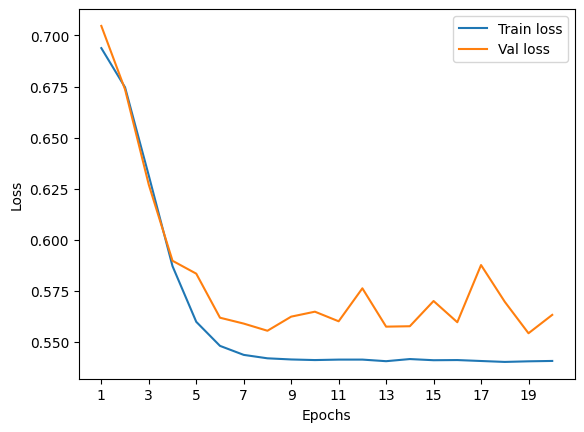

In [45]:
plot_loss(history)

In [ ]:
plot_auc(model, test_dataloader)

#### Learning rate = 1e-2

In [46]:
model = GCN(input_dims, hidden_dims, output_dims)
model

GCN(
  (layers): ModuleList(
    (0): GCNConv()
  )
  (activ_fn): LeakyReLU(negative_slope=0.2)
  (classifier): Linear(in_features=8, out_features=1, bias=True)
)

In [47]:
optimizer = Adam(model.parameters(), 1e-2)
lossFn = BCEWithLogitsLoss()
history = train_model(model, optimizer, lossFn, epochs, lr, train_dataloader, val_dataloader)

313it [00:04, 72.87it/s]


Train Epoch: 0 	Loss: 0.591562, Accuracy: 55687/79896 (70%)
Val Epoch: 0 	Loss: 0.566350, Accuracy: 7247/9987 (73%)



313it [00:05, 57.74it/s]


Train Epoch: 1 	Loss: 0.543589, Accuracy: 58524/79896 (73%)
Val Epoch: 1 	Loss: 0.556473, Accuracy: 7240/9987 (72%)



313it [00:04, 65.70it/s]


Train Epoch: 2 	Loss: 0.542377, Accuracy: 58539/79896 (73%)
Val Epoch: 2 	Loss: 0.577740, Accuracy: 7164/9987 (72%)



313it [00:05, 61.66it/s]


Train Epoch: 3 	Loss: 0.542888, Accuracy: 58596/79896 (73%)
Val Epoch: 3 	Loss: 0.566179, Accuracy: 7219/9987 (72%)



313it [00:05, 56.84it/s]


Train Epoch: 4 	Loss: 0.541849, Accuracy: 58608/79896 (73%)
Val Epoch: 4 	Loss: 0.561560, Accuracy: 7246/9987 (73%)



313it [00:04, 64.43it/s]


Train Epoch: 5 	Loss: 0.541463, Accuracy: 58529/79896 (73%)
Val Epoch: 5 	Loss: 0.573925, Accuracy: 7266/9987 (73%)



313it [00:05, 61.65it/s]


Train Epoch: 6 	Loss: 0.541272, Accuracy: 58616/79896 (73%)
Val Epoch: 6 	Loss: 0.562651, Accuracy: 7222/9987 (72%)



313it [00:04, 62.82it/s]


Train Epoch: 7 	Loss: 0.541825, Accuracy: 58632/79896 (73%)
Val Epoch: 7 	Loss: 0.564409, Accuracy: 7243/9987 (73%)



313it [00:04, 71.24it/s]


Train Epoch: 8 	Loss: 0.540485, Accuracy: 58653/79896 (73%)
Val Epoch: 8 	Loss: 0.567350, Accuracy: 7197/9987 (72%)



313it [00:04, 71.98it/s]


Train Epoch: 9 	Loss: 0.541982, Accuracy: 58692/79896 (73%)
Val Epoch: 9 	Loss: 0.571983, Accuracy: 7255/9987 (73%)



313it [00:04, 66.91it/s]


Train Epoch: 10 	Loss: 0.541198, Accuracy: 58623/79896 (73%)
Val Epoch: 10 	Loss: 0.569605, Accuracy: 7206/9987 (72%)



313it [00:04, 74.12it/s]


Train Epoch: 11 	Loss: 0.542159, Accuracy: 58697/79896 (73%)
Val Epoch: 11 	Loss: 0.575789, Accuracy: 7220/9987 (72%)



313it [00:04, 75.13it/s]


Train Epoch: 12 	Loss: 0.540572, Accuracy: 58647/79896 (73%)
Val Epoch: 12 	Loss: 0.572487, Accuracy: 7252/9987 (73%)



313it [00:04, 71.29it/s]


Train Epoch: 13 	Loss: 0.541387, Accuracy: 58670/79896 (73%)
Val Epoch: 13 	Loss: 0.578671, Accuracy: 7212/9987 (72%)



313it [00:04, 70.27it/s]


Train Epoch: 14 	Loss: 0.540994, Accuracy: 58639/79896 (73%)
Val Epoch: 14 	Loss: 0.568360, Accuracy: 7256/9987 (73%)



313it [00:04, 71.28it/s]


Train Epoch: 15 	Loss: 0.541670, Accuracy: 58623/79896 (73%)
Val Epoch: 15 	Loss: 0.563437, Accuracy: 7241/9987 (73%)



313it [00:04, 70.51it/s]


Train Epoch: 16 	Loss: 0.540917, Accuracy: 58670/79896 (73%)
Val Epoch: 16 	Loss: 0.571511, Accuracy: 7232/9987 (72%)



313it [00:05, 58.94it/s]


Train Epoch: 17 	Loss: 0.541137, Accuracy: 58622/79896 (73%)
Val Epoch: 17 	Loss: 0.568275, Accuracy: 7231/9987 (72%)



313it [00:04, 71.95it/s]


Train Epoch: 18 	Loss: 0.540733, Accuracy: 58646/79896 (73%)
Val Epoch: 18 	Loss: 0.572353, Accuracy: 7258/9987 (73%)



313it [00:04, 70.99it/s]


Train Epoch: 19 	Loss: 0.541019, Accuracy: 58663/79896 (73%)
Val Epoch: 19 	Loss: 0.560723, Accuracy: 7250/9987 (73%)



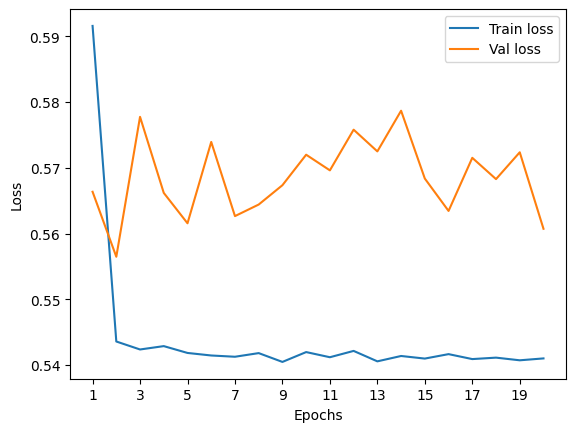

In [48]:
plot_loss(history)

#### ReLU

#### Learning rate = 1e-3

#### GAT - 10 particles, 100K jets

In [65]:
model = GAT(input_dims, [16,64,32,8], output_dims, activ_fn = ReLU())
model

GAT(
  (layers): ModuleList(
    (0-3): 4 x GATConv()
  )
  (activ_fn): ReLU()
  (classifier): Sequential(
    (0): Linear(in_features=13, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=1, bias=True)
  )
)

In [66]:
params = [p.numel() for p in model.parameters()]
sum(params)

5685

In [68]:
epochs=40
optimizer = Adam(model.parameters(), 1e-3)
lossFn = BCEWithLogitsLoss()
history, best_model = train_model(model, optimizer, lossFn, epochs, lr, train_dataloader, val_dataloader)

118it [00:26,  4.39it/s]


Train Epoch: 0 	Loss: 0.667449, Accuracy: 35487/59922 (59%)
Val Epoch: 0 	Loss: 0.603639, Accuracy: 14506/19974 (73%)



118it [00:14,  8.07it/s]


Train Epoch: 1 	Loss: 0.547561, Accuracy: 44696/59922 (75%)
Val Epoch: 1 	Loss: 0.566227, Accuracy: 14313/19974 (72%)



118it [00:14,  8.05it/s]


Train Epoch: 2 	Loss: 0.520572, Accuracy: 45315/59922 (76%)
Val Epoch: 2 	Loss: 0.518335, Accuracy: 15130/19974 (76%)



118it [00:14,  8.14it/s]


Train Epoch: 3 	Loss: 0.507188, Accuracy: 45621/59922 (76%)
Val Epoch: 3 	Loss: 0.510732, Accuracy: 15130/19974 (76%)



118it [00:14,  8.15it/s]


Train Epoch: 4 	Loss: 0.507305, Accuracy: 45630/59922 (76%)
Val Epoch: 4 	Loss: 0.517316, Accuracy: 15189/19974 (76%)



118it [00:14,  8.16it/s]


Train Epoch: 5 	Loss: 0.504659, Accuracy: 45689/59922 (76%)
Val Epoch: 5 	Loss: 0.544935, Accuracy: 15046/19974 (75%)



118it [00:14,  8.14it/s]


Train Epoch: 6 	Loss: 0.500577, Accuracy: 45832/59922 (76%)
Val Epoch: 6 	Loss: 0.512888, Accuracy: 15244/19974 (76%)



118it [00:19,  6.19it/s]


Train Epoch: 7 	Loss: 0.500842, Accuracy: 45832/59922 (76%)
Val Epoch: 7 	Loss: 0.521648, Accuracy: 15060/19974 (75%)



118it [00:15,  7.70it/s]


Train Epoch: 8 	Loss: 0.497766, Accuracy: 45894/59922 (77%)
Val Epoch: 8 	Loss: 0.507320, Accuracy: 15273/19974 (76%)



118it [00:15,  7.47it/s]


Train Epoch: 9 	Loss: 0.494654, Accuracy: 46009/59922 (77%)
Val Epoch: 9 	Loss: 0.516129, Accuracy: 15296/19974 (77%)



118it [00:17,  6.88it/s]


Train Epoch: 10 	Loss: 0.496014, Accuracy: 45930/59922 (77%)
Val Epoch: 10 	Loss: 0.513497, Accuracy: 15340/19974 (77%)



118it [00:15,  7.45it/s]


Train Epoch: 11 	Loss: 0.494212, Accuracy: 46043/59922 (77%)
Val Epoch: 11 	Loss: 0.500330, Accuracy: 15330/19974 (77%)



118it [00:16,  7.24it/s]


Train Epoch: 12 	Loss: 0.493705, Accuracy: 46029/59922 (77%)
Val Epoch: 12 	Loss: 0.507305, Accuracy: 15211/19974 (76%)



118it [00:16,  7.17it/s]


Train Epoch: 13 	Loss: 0.491530, Accuracy: 46066/59922 (77%)
Val Epoch: 13 	Loss: 0.502019, Accuracy: 15359/19974 (77%)



118it [00:16,  7.17it/s]


Train Epoch: 14 	Loss: 0.493808, Accuracy: 46183/59922 (77%)
Val Epoch: 14 	Loss: 0.503899, Accuracy: 15395/19974 (77%)



118it [00:17,  6.61it/s]


Train Epoch: 15 	Loss: 0.494013, Accuracy: 46170/59922 (77%)
Val Epoch: 15 	Loss: 0.506023, Accuracy: 15359/19974 (77%)



118it [00:18,  6.33it/s]


Train Epoch: 16 	Loss: 0.489281, Accuracy: 46247/59922 (77%)
Val Epoch: 16 	Loss: 0.515008, Accuracy: 15175/19974 (76%)



118it [00:17,  6.86it/s]


Train Epoch: 17 	Loss: 0.491410, Accuracy: 46247/59922 (77%)
Val Epoch: 17 	Loss: 0.497316, Accuracy: 15373/19974 (77%)



118it [00:17,  6.75it/s]


Train Epoch: 18 	Loss: 0.488726, Accuracy: 46227/59922 (77%)
Val Epoch: 18 	Loss: 0.500057, Accuracy: 15360/19974 (77%)



118it [00:18,  6.34it/s]


Train Epoch: 19 	Loss: 0.491723, Accuracy: 46217/59922 (77%)
Val Epoch: 19 	Loss: 0.511402, Accuracy: 15367/19974 (77%)



118it [00:19,  6.15it/s]


Train Epoch: 20 	Loss: 0.490917, Accuracy: 46256/59922 (77%)
Val Epoch: 20 	Loss: 0.522280, Accuracy: 15060/19974 (75%)



118it [00:18,  6.45it/s]


Train Epoch: 21 	Loss: 0.490325, Accuracy: 46272/59922 (77%)
Val Epoch: 21 	Loss: 0.503332, Accuracy: 15379/19974 (77%)



118it [00:19,  6.18it/s]


Train Epoch: 22 	Loss: 0.488057, Accuracy: 46300/59922 (77%)
Val Epoch: 22 	Loss: 0.495416, Accuracy: 15394/19974 (77%)



118it [00:19,  6.02it/s]


Train Epoch: 23 	Loss: 0.487097, Accuracy: 46319/59922 (77%)
Val Epoch: 23 	Loss: 0.491629, Accuracy: 15366/19974 (77%)



118it [00:19,  6.08it/s]


Train Epoch: 24 	Loss: 0.486466, Accuracy: 46346/59922 (77%)
Val Epoch: 24 	Loss: 0.509145, Accuracy: 15359/19974 (77%)



118it [00:18,  6.31it/s]


Train Epoch: 25 	Loss: 0.488892, Accuracy: 46291/59922 (77%)
Val Epoch: 25 	Loss: 0.500297, Accuracy: 15427/19974 (77%)



118it [00:18,  6.27it/s]


Train Epoch: 26 	Loss: 0.488643, Accuracy: 46341/59922 (77%)
Val Epoch: 26 	Loss: 0.514147, Accuracy: 15124/19974 (76%)



118it [00:19,  6.18it/s]


Train Epoch: 27 	Loss: 0.487196, Accuracy: 46364/59922 (77%)
Val Epoch: 27 	Loss: 0.499564, Accuracy: 15394/19974 (77%)



118it [00:18,  6.26it/s]


Train Epoch: 28 	Loss: 0.489688, Accuracy: 46304/59922 (77%)
Val Epoch: 28 	Loss: 0.507836, Accuracy: 15407/19974 (77%)



118it [00:19,  6.05it/s]


Train Epoch: 29 	Loss: 0.485409, Accuracy: 46375/59922 (77%)
Val Epoch: 29 	Loss: 0.502866, Accuracy: 15386/19974 (77%)



118it [00:19,  6.01it/s]


Train Epoch: 30 	Loss: 0.486820, Accuracy: 46380/59922 (77%)
Val Epoch: 30 	Loss: 0.491076, Accuracy: 15388/19974 (77%)



118it [00:18,  6.21it/s]


Train Epoch: 31 	Loss: 0.486551, Accuracy: 46369/59922 (77%)
Val Epoch: 31 	Loss: 0.502887, Accuracy: 15379/19974 (77%)



118it [00:19,  6.01it/s]


Train Epoch: 32 	Loss: 0.486972, Accuracy: 46371/59922 (77%)
Val Epoch: 32 	Loss: 0.499841, Accuracy: 15436/19974 (77%)



118it [00:18,  6.26it/s]


Train Epoch: 33 	Loss: 0.486891, Accuracy: 46456/59922 (78%)
Val Epoch: 33 	Loss: 0.494429, Accuracy: 15436/19974 (77%)



118it [00:19,  6.07it/s]


Train Epoch: 34 	Loss: 0.486079, Accuracy: 46398/59922 (77%)
Val Epoch: 34 	Loss: 0.505342, Accuracy: 15435/19974 (77%)



118it [00:19,  6.21it/s]


Train Epoch: 35 	Loss: 0.485376, Accuracy: 46416/59922 (77%)
Val Epoch: 35 	Loss: 0.508934, Accuracy: 15465/19974 (77%)



118it [00:19,  6.20it/s]


Train Epoch: 36 	Loss: 0.488396, Accuracy: 46359/59922 (77%)
Val Epoch: 36 	Loss: 0.492843, Accuracy: 15420/19974 (77%)



118it [00:19,  6.14it/s]


Train Epoch: 37 	Loss: 0.487004, Accuracy: 46486/59922 (78%)
Val Epoch: 37 	Loss: 0.505298, Accuracy: 15401/19974 (77%)



118it [00:19,  6.19it/s]


Train Epoch: 38 	Loss: 0.484638, Accuracy: 46419/59922 (77%)
Val Epoch: 38 	Loss: 0.494623, Accuracy: 15432/19974 (77%)



118it [00:19,  6.06it/s]


Train Epoch: 39 	Loss: 0.483922, Accuracy: 46455/59922 (78%)
Val Epoch: 39 	Loss: 0.519864, Accuracy: 15426/19974 (77%)



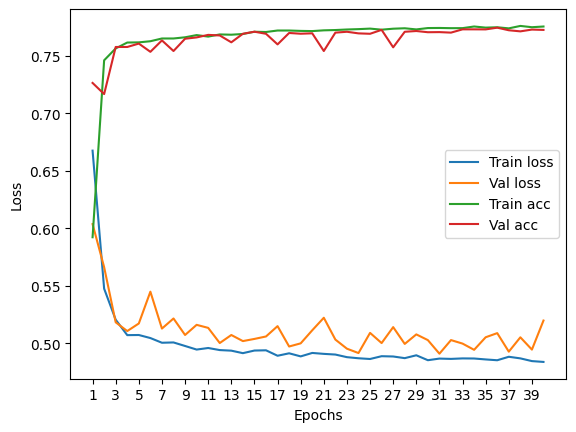

In [69]:
plot_loss(history)

Test accuracy:  77.35055572243917


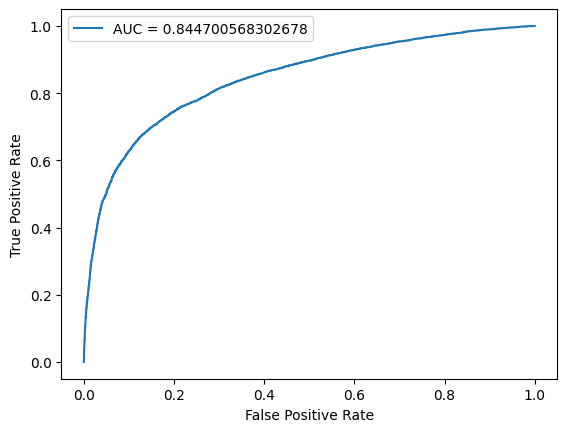

In [70]:
plot_auc(best_model, test_dataloader)

#### GAT - 5 particles, 100K jets

In [201]:
model = GAT(input_dims, hidden_dims, output_dims, activ_fn = ReLU())
model

GAT(
  (layers): ModuleList(
    (0-1): 2 x GATConv()
  )
  (activ_fn): ReLU()
  (classifier): Sequential(
    (0): Linear(in_features=13, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=1, bias=True)
  )
)

In [202]:
optimizer = Adam(model.parameters(), 1e-3)
lossFn = BCEWithLogitsLoss()
history, best_model = train_model(model, optimizer, lossFn, epochs, lr, train_dataloader, val_dataloader)

469it [00:15, 30.14it/s]


Train Epoch: 0 	Loss: 0.593454, Accuracy: 41036/59922 (68%)
Val Epoch: 0 	Loss: 0.511918, Accuracy: 15249/19974 (76%)



469it [00:11, 39.24it/s]


Train Epoch: 1 	Loss: 0.501457, Accuracy: 45643/59922 (76%)
Val Epoch: 1 	Loss: 0.494741, Accuracy: 15386/19974 (77%)



469it [00:12, 36.59it/s]


Train Epoch: 2 	Loss: 0.492025, Accuracy: 46074/59922 (77%)
Val Epoch: 2 	Loss: 0.488706, Accuracy: 15381/19974 (77%)



469it [00:10, 43.30it/s]


Train Epoch: 3 	Loss: 0.489537, Accuracy: 46223/59922 (77%)
Val Epoch: 3 	Loss: 0.486814, Accuracy: 15482/19974 (78%)



469it [00:10, 45.87it/s]


Train Epoch: 4 	Loss: 0.488109, Accuracy: 46315/59922 (77%)
Val Epoch: 4 	Loss: 0.486803, Accuracy: 15513/19974 (78%)



469it [00:10, 44.45it/s]


Train Epoch: 5 	Loss: 0.485624, Accuracy: 46377/59922 (77%)
Val Epoch: 5 	Loss: 0.483945, Accuracy: 15531/19974 (78%)



469it [00:11, 40.43it/s]


Train Epoch: 6 	Loss: 0.485114, Accuracy: 46389/59922 (77%)
Val Epoch: 6 	Loss: 0.484783, Accuracy: 15474/19974 (77%)



469it [00:11, 41.37it/s]


Train Epoch: 7 	Loss: 0.484587, Accuracy: 46398/59922 (77%)
Val Epoch: 7 	Loss: 0.480830, Accuracy: 15526/19974 (78%)



469it [00:13, 35.97it/s]


Train Epoch: 8 	Loss: 0.483739, Accuracy: 46445/59922 (78%)
Val Epoch: 8 	Loss: 0.487649, Accuracy: 15469/19974 (77%)



469it [00:11, 41.76it/s]


Train Epoch: 9 	Loss: 0.483959, Accuracy: 46436/59922 (77%)
Val Epoch: 9 	Loss: 0.484038, Accuracy: 15530/19974 (78%)



469it [00:10, 46.21it/s]


Train Epoch: 10 	Loss: 0.483400, Accuracy: 46422/59922 (77%)
Val Epoch: 10 	Loss: 0.482129, Accuracy: 15547/19974 (78%)



469it [00:10, 44.80it/s]


Train Epoch: 11 	Loss: 0.483329, Accuracy: 46442/59922 (78%)
Val Epoch: 11 	Loss: 0.484519, Accuracy: 15520/19974 (78%)



469it [00:10, 42.85it/s]


Train Epoch: 12 	Loss: 0.483296, Accuracy: 46431/59922 (77%)
Val Epoch: 12 	Loss: 0.481695, Accuracy: 15528/19974 (78%)



469it [00:11, 40.35it/s]


Train Epoch: 13 	Loss: 0.482620, Accuracy: 46468/59922 (78%)
Val Epoch: 13 	Loss: 0.480197, Accuracy: 15554/19974 (78%)



469it [00:10, 43.12it/s]


Train Epoch: 14 	Loss: 0.482641, Accuracy: 46492/59922 (78%)
Val Epoch: 14 	Loss: 0.482147, Accuracy: 15554/19974 (78%)



469it [00:12, 36.54it/s]


Train Epoch: 15 	Loss: 0.482518, Accuracy: 46477/59922 (78%)
Val Epoch: 15 	Loss: 0.481192, Accuracy: 15514/19974 (78%)



469it [00:11, 40.96it/s]


Train Epoch: 16 	Loss: 0.481907, Accuracy: 46481/59922 (78%)
Val Epoch: 16 	Loss: 0.479777, Accuracy: 15575/19974 (78%)



469it [00:09, 51.09it/s]


Train Epoch: 17 	Loss: 0.481973, Accuracy: 46442/59922 (78%)
Val Epoch: 17 	Loss: 0.479437, Accuracy: 15564/19974 (78%)



469it [00:10, 44.16it/s]


Train Epoch: 18 	Loss: 0.482329, Accuracy: 46474/59922 (78%)
Val Epoch: 18 	Loss: 0.479981, Accuracy: 15561/19974 (78%)



469it [00:10, 45.09it/s]


Train Epoch: 19 	Loss: 0.480947, Accuracy: 46510/59922 (78%)
Val Epoch: 19 	Loss: 0.479584, Accuracy: 15579/19974 (78%)



469it [00:11, 40.90it/s]


Train Epoch: 20 	Loss: 0.481531, Accuracy: 46488/59922 (78%)
Val Epoch: 20 	Loss: 0.478880, Accuracy: 15560/19974 (78%)



469it [00:10, 45.78it/s]


Train Epoch: 21 	Loss: 0.481424, Accuracy: 46484/59922 (78%)
Val Epoch: 21 	Loss: 0.478792, Accuracy: 15574/19974 (78%)



469it [00:09, 49.34it/s]


Train Epoch: 22 	Loss: 0.480882, Accuracy: 46527/59922 (78%)
Val Epoch: 22 	Loss: 0.479212, Accuracy: 15567/19974 (78%)



469it [00:10, 46.61it/s]


Train Epoch: 23 	Loss: 0.480637, Accuracy: 46506/59922 (78%)
Val Epoch: 23 	Loss: 0.481734, Accuracy: 15547/19974 (78%)



469it [00:11, 41.55it/s]


Train Epoch: 24 	Loss: 0.480069, Accuracy: 46504/59922 (78%)
Val Epoch: 24 	Loss: 0.480132, Accuracy: 15492/19974 (78%)



469it [00:11, 42.40it/s]


Train Epoch: 25 	Loss: 0.480067, Accuracy: 46548/59922 (78%)
Val Epoch: 25 	Loss: 0.488053, Accuracy: 15480/19974 (78%)



469it [00:10, 43.52it/s]


Train Epoch: 26 	Loss: 0.479883, Accuracy: 46573/59922 (78%)
Val Epoch: 26 	Loss: 0.482287, Accuracy: 15555/19974 (78%)



469it [00:09, 49.10it/s]


Train Epoch: 27 	Loss: 0.479721, Accuracy: 46604/59922 (78%)
Val Epoch: 27 	Loss: 0.478550, Accuracy: 15582/19974 (78%)



469it [00:09, 47.96it/s]


Train Epoch: 28 	Loss: 0.479028, Accuracy: 46597/59922 (78%)
Val Epoch: 28 	Loss: 0.478029, Accuracy: 15577/19974 (78%)



469it [00:10, 42.70it/s]


Train Epoch: 29 	Loss: 0.479850, Accuracy: 46633/59922 (78%)
Val Epoch: 29 	Loss: 0.478646, Accuracy: 15580/19974 (78%)



469it [00:10, 45.15it/s]


Train Epoch: 30 	Loss: 0.479176, Accuracy: 46581/59922 (78%)
Val Epoch: 30 	Loss: 0.477587, Accuracy: 15587/19974 (78%)



469it [00:09, 47.03it/s]


Train Epoch: 31 	Loss: 0.479106, Accuracy: 46594/59922 (78%)
Val Epoch: 31 	Loss: 0.481188, Accuracy: 15605/19974 (78%)



469it [00:09, 49.86it/s]


Train Epoch: 32 	Loss: 0.479598, Accuracy: 46624/59922 (78%)
Val Epoch: 32 	Loss: 0.478496, Accuracy: 15571/19974 (78%)



469it [00:11, 42.13it/s]


Train Epoch: 33 	Loss: 0.478820, Accuracy: 46593/59922 (78%)
Val Epoch: 33 	Loss: 0.478664, Accuracy: 15598/19974 (78%)



469it [00:10, 44.59it/s]


Train Epoch: 34 	Loss: 0.478447, Accuracy: 46628/59922 (78%)
Val Epoch: 34 	Loss: 0.476547, Accuracy: 15604/19974 (78%)



469it [00:12, 37.50it/s]


Train Epoch: 35 	Loss: 0.478249, Accuracy: 46655/59922 (78%)
Val Epoch: 35 	Loss: 0.476389, Accuracy: 15607/19974 (78%)



469it [00:10, 43.82it/s]


Train Epoch: 36 	Loss: 0.478262, Accuracy: 46619/59922 (78%)
Val Epoch: 36 	Loss: 0.477230, Accuracy: 15564/19974 (78%)



469it [00:09, 50.47it/s]


Train Epoch: 37 	Loss: 0.477781, Accuracy: 46646/59922 (78%)
Val Epoch: 37 	Loss: 0.478665, Accuracy: 15597/19974 (78%)



469it [00:09, 50.22it/s]


Train Epoch: 38 	Loss: 0.477608, Accuracy: 46648/59922 (78%)
Val Epoch: 38 	Loss: 0.478088, Accuracy: 15603/19974 (78%)



469it [00:10, 43.48it/s]


Train Epoch: 39 	Loss: 0.477868, Accuracy: 46656/59922 (78%)
Val Epoch: 39 	Loss: 0.484371, Accuracy: 15583/19974 (78%)



469it [00:10, 45.18it/s]


Train Epoch: 40 	Loss: 0.477929, Accuracy: 46656/59922 (78%)
Val Epoch: 40 	Loss: 0.475588, Accuracy: 15598/19974 (78%)



469it [00:09, 47.80it/s]


Train Epoch: 41 	Loss: 0.477631, Accuracy: 46653/59922 (78%)
Val Epoch: 41 	Loss: 0.479266, Accuracy: 15587/19974 (78%)



469it [00:11, 40.33it/s]


Train Epoch: 42 	Loss: 0.477321, Accuracy: 46675/59922 (78%)
Val Epoch: 42 	Loss: 0.476177, Accuracy: 15611/19974 (78%)



469it [00:09, 49.68it/s]


Train Epoch: 43 	Loss: 0.477305, Accuracy: 46680/59922 (78%)
Val Epoch: 43 	Loss: 0.476288, Accuracy: 15599/19974 (78%)



469it [00:10, 44.60it/s]


Train Epoch: 44 	Loss: 0.476925, Accuracy: 46707/59922 (78%)
Val Epoch: 44 	Loss: 0.476707, Accuracy: 15601/19974 (78%)



469it [00:10, 45.79it/s]


Train Epoch: 45 	Loss: 0.476983, Accuracy: 46693/59922 (78%)
Val Epoch: 45 	Loss: 0.478389, Accuracy: 15613/19974 (78%)



469it [00:10, 46.39it/s]


Train Epoch: 46 	Loss: 0.476958, Accuracy: 46698/59922 (78%)
Val Epoch: 46 	Loss: 0.476618, Accuracy: 15602/19974 (78%)



469it [00:09, 49.39it/s]


Train Epoch: 47 	Loss: 0.476263, Accuracy: 46707/59922 (78%)
Val Epoch: 47 	Loss: 0.476734, Accuracy: 15613/19974 (78%)



469it [00:10, 43.75it/s]


Train Epoch: 48 	Loss: 0.476682, Accuracy: 46689/59922 (78%)
Val Epoch: 48 	Loss: 0.478507, Accuracy: 15631/19974 (78%)



469it [00:11, 39.94it/s]


Train Epoch: 49 	Loss: 0.476237, Accuracy: 46738/59922 (78%)
Val Epoch: 49 	Loss: 0.473805, Accuracy: 15630/19974 (78%)



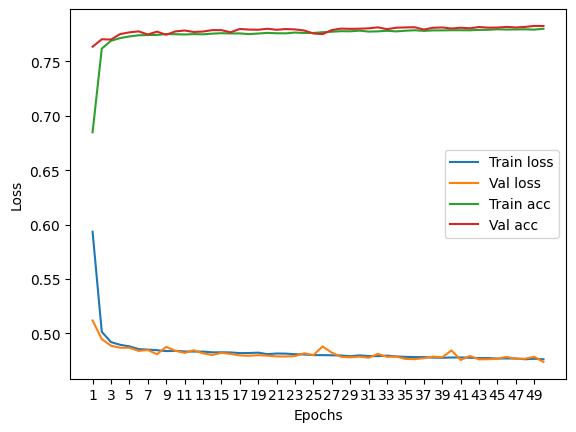

In [203]:
plot_loss(history)

Test accuracy:  77.1102433163112


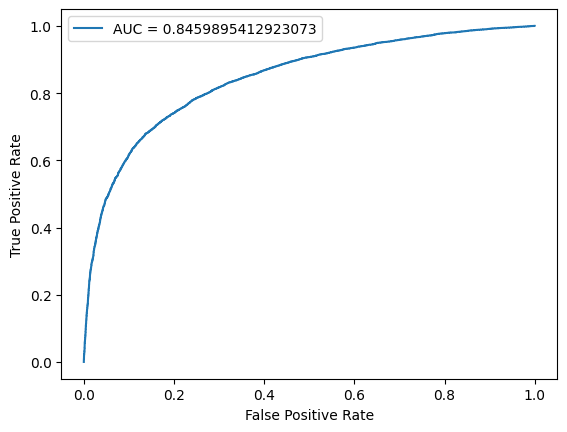

In [204]:
plot_auc(best_model, test_dataloader)

### 12500 jets

#### GAT - 10 particles

In [124]:
model = GAT(input_dims, hidden_dims, output_dims, activ_fn = ReLU())
model

GAT(
  (layers): ModuleList(
    (0-1): 2 x GATConv(8, 8, heads=1)
  )
  (activ_fn): ReLU()
  (classifier): Sequential(
    (0): Linear(in_features=13, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=1, bias=True)
  )
)

In [125]:
optimizer = Adam(model.parameters(), 1e-3)
lossFn = BCEWithLogitsLoss()
history, best_model = train_model(model, optimizer, lossFn, epochs, lr, train_dataloader, val_dataloader)

118it [00:04, 28.24it/s]


Train Epoch: 0 	Loss: 0.688426, Accuracy: 4032/7500 (54%)
Val Epoch: 0 	Loss: 0.687524, Accuracy: 1782/2500 (71%)



118it [00:03, 32.20it/s]


Train Epoch: 1 	Loss: 0.656635, Accuracy: 5499/7500 (73%)
Val Epoch: 1 	Loss: 0.646667, Accuracy: 1865/2500 (75%)



118it [00:03, 36.55it/s]


Train Epoch: 2 	Loss: 0.610672, Accuracy: 5572/7500 (74%)
Val Epoch: 2 	Loss: 0.595499, Accuracy: 1888/2500 (76%)



118it [00:02, 43.36it/s]


Train Epoch: 3 	Loss: 0.564910, Accuracy: 5652/7500 (75%)
Val Epoch: 3 	Loss: 0.553105, Accuracy: 1909/2500 (76%)



118it [00:02, 49.49it/s]


Train Epoch: 4 	Loss: 0.526771, Accuracy: 5697/7500 (76%)
Val Epoch: 4 	Loss: 0.531003, Accuracy: 1871/2500 (75%)



118it [00:02, 51.29it/s]


Train Epoch: 5 	Loss: 0.504602, Accuracy: 5745/7500 (77%)
Val Epoch: 5 	Loss: 0.510561, Accuracy: 1923/2500 (77%)



118it [00:02, 53.04it/s]


Train Epoch: 6 	Loss: 0.492232, Accuracy: 5770/7500 (77%)
Val Epoch: 6 	Loss: 0.496162, Accuracy: 1931/2500 (77%)



118it [00:02, 52.95it/s]


Train Epoch: 7 	Loss: 0.489387, Accuracy: 5807/7500 (77%)
Val Epoch: 7 	Loss: 0.500207, Accuracy: 1939/2500 (78%)



118it [00:03, 33.10it/s]


Train Epoch: 8 	Loss: 0.487921, Accuracy: 5819/7500 (78%)
Val Epoch: 8 	Loss: 0.503614, Accuracy: 1935/2500 (77%)



118it [00:02, 52.85it/s]


Train Epoch: 9 	Loss: 0.487927, Accuracy: 5815/7500 (78%)
Val Epoch: 9 	Loss: 0.500783, Accuracy: 1932/2500 (77%)



118it [00:02, 58.24it/s]


Train Epoch: 10 	Loss: 0.485481, Accuracy: 5824/7500 (78%)
Val Epoch: 10 	Loss: 0.493018, Accuracy: 1950/2500 (78%)



118it [00:02, 56.73it/s]


Train Epoch: 11 	Loss: 0.488424, Accuracy: 5823/7500 (78%)
Val Epoch: 11 	Loss: 0.503358, Accuracy: 1935/2500 (77%)



118it [00:02, 57.42it/s]


Train Epoch: 12 	Loss: 0.486215, Accuracy: 5834/7500 (78%)
Val Epoch: 12 	Loss: 0.501049, Accuracy: 1945/2500 (78%)



118it [00:03, 34.88it/s]


Train Epoch: 13 	Loss: 0.483019, Accuracy: 5844/7500 (78%)
Val Epoch: 13 	Loss: 0.492601, Accuracy: 1949/2500 (78%)



118it [00:03, 39.06it/s]


Train Epoch: 14 	Loss: 0.485027, Accuracy: 5842/7500 (78%)
Val Epoch: 14 	Loss: 0.503969, Accuracy: 1938/2500 (78%)



118it [00:03, 37.91it/s]


Train Epoch: 15 	Loss: 0.485592, Accuracy: 5832/7500 (78%)
Val Epoch: 15 	Loss: 0.496838, Accuracy: 1943/2500 (78%)



118it [00:02, 42.93it/s]


Train Epoch: 16 	Loss: 0.482507, Accuracy: 5836/7500 (78%)
Val Epoch: 16 	Loss: 0.491012, Accuracy: 1940/2500 (78%)



118it [00:02, 42.14it/s]


Train Epoch: 17 	Loss: 0.487678, Accuracy: 5842/7500 (78%)
Val Epoch: 17 	Loss: 0.505556, Accuracy: 1942/2500 (78%)



118it [00:03, 31.97it/s]


Train Epoch: 18 	Loss: 0.482615, Accuracy: 5836/7500 (78%)
Val Epoch: 18 	Loss: 0.504993, Accuracy: 1942/2500 (78%)



118it [00:03, 33.76it/s]


Train Epoch: 19 	Loss: 0.483824, Accuracy: 5838/7500 (78%)
Val Epoch: 19 	Loss: 0.489206, Accuracy: 1937/2500 (77%)



118it [00:03, 35.62it/s]


Train Epoch: 20 	Loss: 0.480966, Accuracy: 5861/7500 (78%)
Val Epoch: 20 	Loss: 0.492935, Accuracy: 1937/2500 (77%)



118it [00:03, 31.64it/s]


Train Epoch: 21 	Loss: 0.482022, Accuracy: 5844/7500 (78%)
Val Epoch: 21 	Loss: 0.501686, Accuracy: 1937/2500 (77%)



118it [00:03, 36.24it/s]


Train Epoch: 22 	Loss: 0.481535, Accuracy: 5837/7500 (78%)
Val Epoch: 22 	Loss: 0.492529, Accuracy: 1953/2500 (78%)



118it [00:03, 35.38it/s]


Train Epoch: 23 	Loss: 0.482526, Accuracy: 5848/7500 (78%)
Val Epoch: 23 	Loss: 0.501781, Accuracy: 1944/2500 (78%)



118it [00:02, 44.93it/s]


Train Epoch: 24 	Loss: 0.481925, Accuracy: 5859/7500 (78%)
Val Epoch: 24 	Loss: 0.506641, Accuracy: 1940/2500 (78%)



118it [00:02, 46.48it/s]


Train Epoch: 25 	Loss: 0.480609, Accuracy: 5853/7500 (78%)
Val Epoch: 25 	Loss: 0.503260, Accuracy: 1939/2500 (78%)



118it [00:03, 36.31it/s]


Train Epoch: 26 	Loss: 0.481553, Accuracy: 5857/7500 (78%)
Val Epoch: 26 	Loss: 0.494752, Accuracy: 1942/2500 (78%)



118it [00:03, 38.21it/s]


Train Epoch: 27 	Loss: 0.480701, Accuracy: 5852/7500 (78%)
Val Epoch: 27 	Loss: 0.487926, Accuracy: 1940/2500 (78%)



118it [00:02, 40.29it/s]


Train Epoch: 28 	Loss: 0.482475, Accuracy: 5851/7500 (78%)
Val Epoch: 28 	Loss: 0.495372, Accuracy: 1939/2500 (78%)



118it [00:02, 55.07it/s]


Train Epoch: 29 	Loss: 0.480450, Accuracy: 5853/7500 (78%)
Val Epoch: 29 	Loss: 0.493961, Accuracy: 1944/2500 (78%)



118it [00:03, 35.85it/s]


Train Epoch: 30 	Loss: 0.479839, Accuracy: 5854/7500 (78%)
Val Epoch: 30 	Loss: 0.501342, Accuracy: 1940/2500 (78%)



118it [00:02, 44.28it/s]


Train Epoch: 31 	Loss: 0.480699, Accuracy: 5861/7500 (78%)
Val Epoch: 31 	Loss: 0.496668, Accuracy: 1952/2500 (78%)



118it [00:02, 50.46it/s]


Train Epoch: 32 	Loss: 0.480084, Accuracy: 5845/7500 (78%)
Val Epoch: 32 	Loss: 0.489553, Accuracy: 1942/2500 (78%)



118it [00:02, 43.05it/s]


Train Epoch: 33 	Loss: 0.482369, Accuracy: 5844/7500 (78%)
Val Epoch: 33 	Loss: 0.505461, Accuracy: 1941/2500 (78%)



118it [00:03, 35.83it/s]


Train Epoch: 34 	Loss: 0.481519, Accuracy: 5862/7500 (78%)
Val Epoch: 34 	Loss: 0.492582, Accuracy: 1938/2500 (78%)



118it [00:03, 37.03it/s]


Train Epoch: 35 	Loss: 0.481051, Accuracy: 5869/7500 (78%)
Val Epoch: 35 	Loss: 0.497970, Accuracy: 1945/2500 (78%)



118it [00:02, 52.48it/s]


Train Epoch: 36 	Loss: 0.480538, Accuracy: 5861/7500 (78%)
Val Epoch: 36 	Loss: 0.500720, Accuracy: 1956/2500 (78%)



118it [00:02, 48.72it/s]


Train Epoch: 37 	Loss: 0.480469, Accuracy: 5857/7500 (78%)
Val Epoch: 37 	Loss: 0.491676, Accuracy: 1942/2500 (78%)



118it [00:02, 47.18it/s]


Train Epoch: 38 	Loss: 0.480359, Accuracy: 5850/7500 (78%)
Val Epoch: 38 	Loss: 0.488986, Accuracy: 1944/2500 (78%)



118it [00:04, 28.55it/s]


Train Epoch: 39 	Loss: 0.478283, Accuracy: 5854/7500 (78%)
Val Epoch: 39 	Loss: 0.494422, Accuracy: 1940/2500 (78%)



118it [00:03, 36.68it/s]


Train Epoch: 40 	Loss: 0.479908, Accuracy: 5870/7500 (78%)
Val Epoch: 40 	Loss: 0.505174, Accuracy: 1948/2500 (78%)



118it [00:03, 38.62it/s]


Train Epoch: 41 	Loss: 0.482103, Accuracy: 5853/7500 (78%)
Val Epoch: 41 	Loss: 0.502032, Accuracy: 1941/2500 (78%)



118it [00:02, 45.28it/s]


Train Epoch: 42 	Loss: 0.480707, Accuracy: 5841/7500 (78%)
Val Epoch: 42 	Loss: 0.488177, Accuracy: 1940/2500 (78%)



118it [00:02, 46.24it/s]


Train Epoch: 43 	Loss: 0.479599, Accuracy: 5862/7500 (78%)
Val Epoch: 43 	Loss: 0.506202, Accuracy: 1940/2500 (78%)



118it [00:02, 42.93it/s]


Train Epoch: 44 	Loss: 0.478715, Accuracy: 5851/7500 (78%)
Val Epoch: 44 	Loss: 0.489676, Accuracy: 1949/2500 (78%)



118it [00:02, 39.75it/s]


Train Epoch: 45 	Loss: 0.478007, Accuracy: 5850/7500 (78%)
Val Epoch: 45 	Loss: 0.489885, Accuracy: 1937/2500 (77%)



118it [00:03, 35.15it/s]


Train Epoch: 46 	Loss: 0.480013, Accuracy: 5867/7500 (78%)
Val Epoch: 46 	Loss: 0.499516, Accuracy: 1945/2500 (78%)



118it [00:03, 35.92it/s]


Train Epoch: 47 	Loss: 0.481666, Accuracy: 5858/7500 (78%)
Val Epoch: 47 	Loss: 0.487498, Accuracy: 1947/2500 (78%)



118it [00:03, 29.93it/s]


Train Epoch: 48 	Loss: 0.478758, Accuracy: 5858/7500 (78%)
Val Epoch: 48 	Loss: 0.487396, Accuracy: 1949/2500 (78%)



118it [00:03, 31.34it/s]


Train Epoch: 49 	Loss: 0.479468, Accuracy: 5852/7500 (78%)
Val Epoch: 49 	Loss: 0.490164, Accuracy: 1940/2500 (78%)



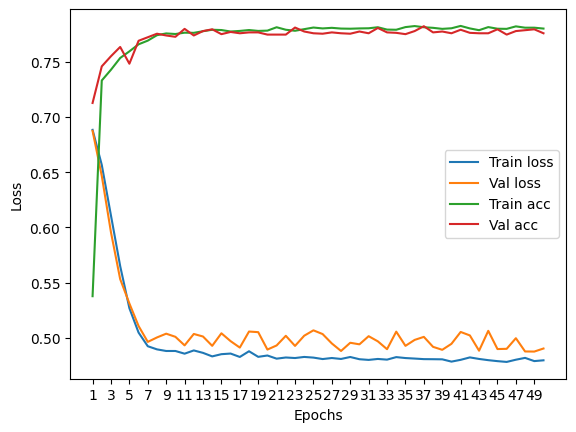

In [126]:
plot_loss(history)

Test accuracy:  77.44


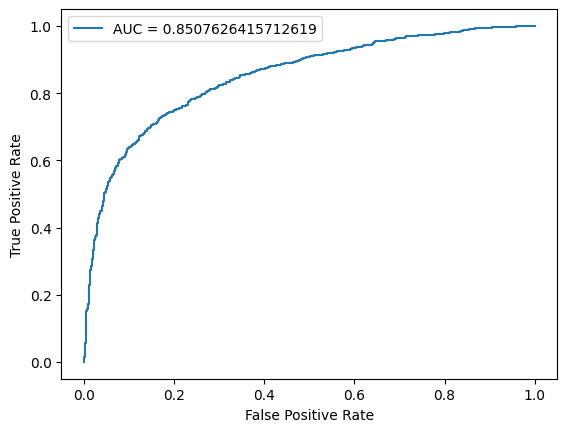

In [127]:
plot_auc(best_model, test_dataloader)

#### GAT  - 5 particles

In [183]:
model = GAT(input_dims, hidden_dims, output_dims, activ_fn = ReLU())
model

GAT(
  (layers): ModuleList(
    (0-1): 2 x GATConv()
  )
  (activ_fn): ReLU()
  (classifier): Sequential(
    (0): Linear(in_features=13, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=1, bias=True)
  )
)

In [192]:
a = [p.numel() for p in model.parameters()]
a, sum(a)

([8, 64, 128, 8, 8, 1, 8, 64, 128, 8, 8, 1, 104, 8, 8, 1], 555)

In [184]:
optimizer = Adam(model.parameters(), 1e-3)
lossFn = BCEWithLogitsLoss()
history, best_model = train_model(model, optimizer, lossFn, epochs, lr, train_dataloader, val_dataloader)

118it [00:03, 32.00it/s]


Train Epoch: 0 	Loss: 0.689170, Accuracy: 4112/7500 (55%)
Val Epoch: 0 	Loss: 0.685667, Accuracy: 1700/2500 (68%)



118it [00:03, 34.47it/s]


Train Epoch: 1 	Loss: 0.646882, Accuracy: 5291/7500 (71%)
Val Epoch: 1 	Loss: 0.614530, Accuracy: 1821/2500 (73%)



118it [00:03, 35.22it/s]


Train Epoch: 2 	Loss: 0.568522, Accuracy: 5503/7500 (73%)
Val Epoch: 2 	Loss: 0.539608, Accuracy: 1886/2500 (75%)



118it [00:03, 35.02it/s]


Train Epoch: 3 	Loss: 0.517663, Accuracy: 5698/7500 (76%)
Val Epoch: 3 	Loss: 0.505540, Accuracy: 1911/2500 (76%)



118it [00:03, 34.60it/s]


Train Epoch: 4 	Loss: 0.507442, Accuracy: 5749/7500 (77%)
Val Epoch: 4 	Loss: 0.514318, Accuracy: 1913/2500 (77%)



118it [00:03, 34.60it/s]


Train Epoch: 5 	Loss: 0.502780, Accuracy: 5739/7500 (77%)
Val Epoch: 5 	Loss: 0.495243, Accuracy: 1945/2500 (78%)



118it [00:03, 36.85it/s]


Train Epoch: 6 	Loss: 0.499381, Accuracy: 5759/7500 (77%)
Val Epoch: 6 	Loss: 0.492394, Accuracy: 1950/2500 (78%)



118it [00:03, 34.16it/s]


Train Epoch: 7 	Loss: 0.495404, Accuracy: 5783/7500 (77%)
Val Epoch: 7 	Loss: 0.493514, Accuracy: 1948/2500 (78%)



118it [00:03, 34.66it/s]


Train Epoch: 8 	Loss: 0.496721, Accuracy: 5793/7500 (77%)
Val Epoch: 8 	Loss: 0.493759, Accuracy: 1944/2500 (78%)



118it [00:03, 34.34it/s]


Train Epoch: 9 	Loss: 0.494793, Accuracy: 5802/7500 (77%)
Val Epoch: 9 	Loss: 0.483226, Accuracy: 1948/2500 (78%)



118it [00:03, 37.47it/s]


Train Epoch: 10 	Loss: 0.491938, Accuracy: 5820/7500 (78%)
Val Epoch: 10 	Loss: 0.488105, Accuracy: 1939/2500 (78%)



118it [00:03, 35.09it/s]


Train Epoch: 11 	Loss: 0.493290, Accuracy: 5787/7500 (77%)
Val Epoch: 11 	Loss: 0.488451, Accuracy: 1955/2500 (78%)



118it [00:03, 34.77it/s]


Train Epoch: 12 	Loss: 0.491176, Accuracy: 5783/7500 (77%)
Val Epoch: 12 	Loss: 0.487962, Accuracy: 1949/2500 (78%)



118it [00:03, 35.72it/s]


Train Epoch: 13 	Loss: 0.493185, Accuracy: 5807/7500 (77%)
Val Epoch: 13 	Loss: 0.489678, Accuracy: 1945/2500 (78%)



118it [00:03, 36.63it/s]


Train Epoch: 14 	Loss: 0.493545, Accuracy: 5791/7500 (77%)
Val Epoch: 14 	Loss: 0.481368, Accuracy: 1957/2500 (78%)



118it [00:03, 34.26it/s]


Train Epoch: 15 	Loss: 0.492376, Accuracy: 5803/7500 (77%)
Val Epoch: 15 	Loss: 0.500625, Accuracy: 1919/2500 (77%)



118it [00:03, 31.83it/s]


Train Epoch: 16 	Loss: 0.493185, Accuracy: 5781/7500 (77%)
Val Epoch: 16 	Loss: 0.492298, Accuracy: 1938/2500 (78%)



118it [00:03, 37.16it/s]


Train Epoch: 17 	Loss: 0.488112, Accuracy: 5822/7500 (78%)
Val Epoch: 17 	Loss: 0.483361, Accuracy: 1954/2500 (78%)



118it [00:03, 36.60it/s]


Train Epoch: 18 	Loss: 0.488647, Accuracy: 5810/7500 (77%)
Val Epoch: 18 	Loss: 0.485180, Accuracy: 1954/2500 (78%)



118it [00:03, 35.11it/s]


Train Epoch: 19 	Loss: 0.487701, Accuracy: 5827/7500 (78%)
Val Epoch: 19 	Loss: 0.477356, Accuracy: 1953/2500 (78%)



118it [00:03, 34.84it/s]


Train Epoch: 20 	Loss: 0.488873, Accuracy: 5806/7500 (77%)
Val Epoch: 20 	Loss: 0.480046, Accuracy: 1960/2500 (78%)



118it [00:03, 34.45it/s]


Train Epoch: 21 	Loss: 0.488319, Accuracy: 5818/7500 (78%)
Val Epoch: 21 	Loss: 0.479239, Accuracy: 1955/2500 (78%)



118it [00:03, 38.13it/s]


Train Epoch: 22 	Loss: 0.486681, Accuracy: 5806/7500 (77%)
Val Epoch: 22 	Loss: 0.489913, Accuracy: 1946/2500 (78%)



118it [00:03, 35.54it/s]


Train Epoch: 23 	Loss: 0.489032, Accuracy: 5826/7500 (78%)
Val Epoch: 23 	Loss: 0.490409, Accuracy: 1957/2500 (78%)



118it [00:03, 35.35it/s]


Train Epoch: 24 	Loss: 0.486277, Accuracy: 5807/7500 (77%)
Val Epoch: 24 	Loss: 0.481037, Accuracy: 1953/2500 (78%)



118it [00:03, 35.28it/s]


Train Epoch: 25 	Loss: 0.486414, Accuracy: 5825/7500 (78%)
Val Epoch: 25 	Loss: 0.483361, Accuracy: 1959/2500 (78%)



118it [00:03, 38.07it/s]


Train Epoch: 26 	Loss: 0.488369, Accuracy: 5827/7500 (78%)
Val Epoch: 26 	Loss: 0.476525, Accuracy: 1953/2500 (78%)



118it [00:03, 35.76it/s]


Train Epoch: 27 	Loss: 0.484563, Accuracy: 5825/7500 (78%)
Val Epoch: 27 	Loss: 0.481018, Accuracy: 1945/2500 (78%)



118it [00:03, 35.53it/s]


Train Epoch: 28 	Loss: 0.486545, Accuracy: 5831/7500 (78%)
Val Epoch: 28 	Loss: 0.486239, Accuracy: 1961/2500 (78%)



118it [00:03, 36.32it/s]


Train Epoch: 29 	Loss: 0.484192, Accuracy: 5844/7500 (78%)
Val Epoch: 29 	Loss: 0.482958, Accuracy: 1949/2500 (78%)



118it [00:03, 37.09it/s]


Train Epoch: 30 	Loss: 0.484345, Accuracy: 5860/7500 (78%)
Val Epoch: 30 	Loss: 0.483469, Accuracy: 1959/2500 (78%)



118it [00:03, 33.72it/s]


Train Epoch: 31 	Loss: 0.484213, Accuracy: 5818/7500 (78%)
Val Epoch: 31 	Loss: 0.479332, Accuracy: 1958/2500 (78%)



118it [00:03, 34.35it/s]


Train Epoch: 32 	Loss: 0.484752, Accuracy: 5824/7500 (78%)
Val Epoch: 32 	Loss: 0.477012, Accuracy: 1952/2500 (78%)



118it [00:03, 34.95it/s]


Train Epoch: 33 	Loss: 0.482090, Accuracy: 5833/7500 (78%)
Val Epoch: 33 	Loss: 0.481076, Accuracy: 1959/2500 (78%)



118it [00:03, 36.61it/s]


Train Epoch: 34 	Loss: 0.482197, Accuracy: 5831/7500 (78%)
Val Epoch: 34 	Loss: 0.479018, Accuracy: 1956/2500 (78%)



118it [00:03, 34.33it/s]


Train Epoch: 35 	Loss: 0.482550, Accuracy: 5838/7500 (78%)
Val Epoch: 35 	Loss: 0.475977, Accuracy: 1958/2500 (78%)



118it [00:03, 35.40it/s]


Train Epoch: 36 	Loss: 0.485274, Accuracy: 5848/7500 (78%)
Val Epoch: 36 	Loss: 0.476509, Accuracy: 1959/2500 (78%)



118it [00:03, 35.34it/s]


Train Epoch: 37 	Loss: 0.482224, Accuracy: 5829/7500 (78%)
Val Epoch: 37 	Loss: 0.479090, Accuracy: 1957/2500 (78%)



118it [00:03, 36.41it/s]


Train Epoch: 38 	Loss: 0.481539, Accuracy: 5852/7500 (78%)
Val Epoch: 38 	Loss: 0.479214, Accuracy: 1943/2500 (78%)



118it [00:03, 35.63it/s]


Train Epoch: 39 	Loss: 0.481976, Accuracy: 5843/7500 (78%)
Val Epoch: 39 	Loss: 0.472808, Accuracy: 1964/2500 (79%)



118it [00:03, 35.69it/s]


Train Epoch: 40 	Loss: 0.482561, Accuracy: 5846/7500 (78%)
Val Epoch: 40 	Loss: 0.473582, Accuracy: 1958/2500 (78%)



118it [00:03, 34.79it/s]


Train Epoch: 41 	Loss: 0.485332, Accuracy: 5852/7500 (78%)
Val Epoch: 41 	Loss: 0.476218, Accuracy: 1962/2500 (78%)



118it [00:03, 35.55it/s]


Train Epoch: 42 	Loss: 0.482580, Accuracy: 5861/7500 (78%)
Val Epoch: 42 	Loss: 0.487176, Accuracy: 1962/2500 (78%)



118it [00:03, 34.52it/s]


Train Epoch: 43 	Loss: 0.481143, Accuracy: 5871/7500 (78%)
Val Epoch: 43 	Loss: 0.484549, Accuracy: 1958/2500 (78%)



118it [00:03, 36.60it/s]


Train Epoch: 44 	Loss: 0.485051, Accuracy: 5827/7500 (78%)
Val Epoch: 44 	Loss: 0.481189, Accuracy: 1953/2500 (78%)



118it [00:03, 35.93it/s]


Train Epoch: 45 	Loss: 0.482211, Accuracy: 5849/7500 (78%)
Val Epoch: 45 	Loss: 0.474329, Accuracy: 1958/2500 (78%)



118it [00:03, 37.20it/s]


Train Epoch: 46 	Loss: 0.482928, Accuracy: 5864/7500 (78%)
Val Epoch: 46 	Loss: 0.504609, Accuracy: 1953/2500 (78%)



118it [00:03, 35.53it/s]


Train Epoch: 47 	Loss: 0.481007, Accuracy: 5862/7500 (78%)
Val Epoch: 47 	Loss: 0.476738, Accuracy: 1959/2500 (78%)



118it [00:03, 35.61it/s]


Train Epoch: 48 	Loss: 0.481460, Accuracy: 5839/7500 (78%)
Val Epoch: 48 	Loss: 0.482380, Accuracy: 1956/2500 (78%)



118it [00:03, 35.34it/s]


Train Epoch: 49 	Loss: 0.480834, Accuracy: 5847/7500 (78%)
Val Epoch: 49 	Loss: 0.476947, Accuracy: 1953/2500 (78%)



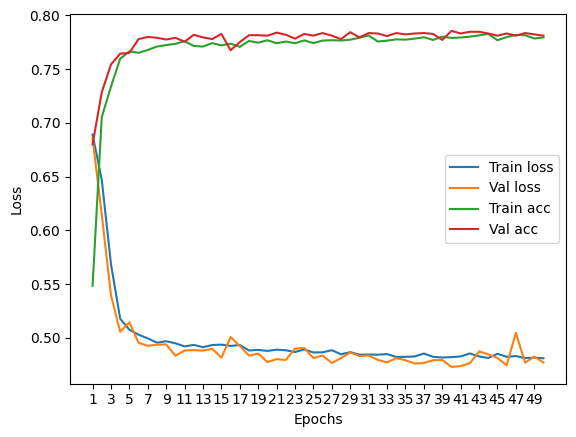

In [185]:
plot_loss(history)

Test accuracy:  77.24


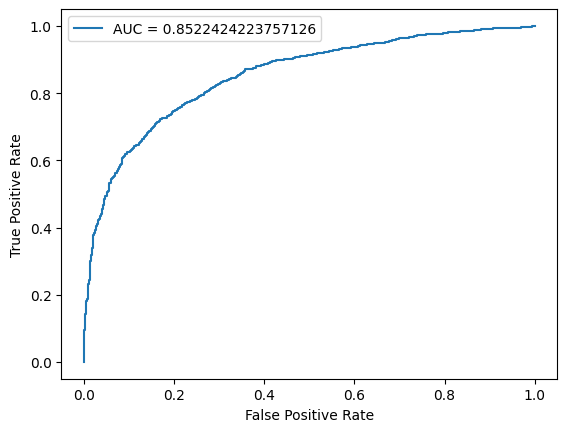

In [187]:
plot_auc(model, test_dataloader)

#### GAT

In [101]:
model = GAT(input_dims, hidden_dims, output_dims, activ_fn = ReLU())
model

GAT(
  (layers): ModuleList(
    (0-1): 2 x GATConv(8, 8, heads=1)
  )
  (activ_fn): ReLU()
  (classifier): Sequential(
    (0): Linear(in_features=13, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=1, bias=True)
  )
)

In [102]:
optimizer = Adam(model.parameters(), 1e-3)
lossFn = BCEWithLogitsLoss()
history, best_model = train_model(model, optimizer, lossFn, epochs, lr, train_dataloader, val_dataloader)

118it [00:01, 89.23it/s]


Train Epoch: 0 	Loss: 0.694854, Accuracy: 4108/7500 (55%)
Val Epoch: 0 	Loss: 0.700013, Accuracy: 1745/2500 (70%)



118it [00:01, 100.72it/s]


Train Epoch: 1 	Loss: 0.680932, Accuracy: 4951/7500 (66%)
Val Epoch: 1 	Loss: 0.680215, Accuracy: 1750/2500 (70%)



118it [00:01, 69.07it/s]


Train Epoch: 2 	Loss: 0.652327, Accuracy: 5571/7500 (74%)
Val Epoch: 2 	Loss: 0.635716, Accuracy: 1907/2500 (76%)



118it [00:02, 57.24it/s]


Train Epoch: 3 	Loss: 0.587853, Accuracy: 5635/7500 (75%)
Val Epoch: 3 	Loss: 0.554624, Accuracy: 1924/2500 (77%)



118it [00:02, 43.22it/s]


Train Epoch: 4 	Loss: 0.532965, Accuracy: 5684/7500 (76%)
Val Epoch: 4 	Loss: 0.512941, Accuracy: 1929/2500 (77%)



118it [00:02, 51.84it/s]


Train Epoch: 5 	Loss: 0.514898, Accuracy: 5722/7500 (76%)
Val Epoch: 5 	Loss: 0.495772, Accuracy: 1937/2500 (77%)



118it [00:02, 55.17it/s]


Train Epoch: 6 	Loss: 0.504895, Accuracy: 5741/7500 (77%)
Val Epoch: 6 	Loss: 0.493015, Accuracy: 1943/2500 (78%)



118it [00:01, 75.96it/s]


Train Epoch: 7 	Loss: 0.502077, Accuracy: 5759/7500 (77%)
Val Epoch: 7 	Loss: 0.493200, Accuracy: 1944/2500 (78%)



118it [00:01, 97.36it/s] 


Train Epoch: 8 	Loss: 0.501740, Accuracy: 5769/7500 (77%)
Val Epoch: 8 	Loss: 0.497475, Accuracy: 1956/2500 (78%)



118it [00:01, 98.42it/s]


Train Epoch: 9 	Loss: 0.497680, Accuracy: 5750/7500 (77%)
Val Epoch: 9 	Loss: 0.489677, Accuracy: 1953/2500 (78%)



118it [00:01, 106.15it/s]


Train Epoch: 10 	Loss: 0.497575, Accuracy: 5767/7500 (77%)
Val Epoch: 10 	Loss: 0.484688, Accuracy: 1957/2500 (78%)



118it [00:01, 102.05it/s]


Train Epoch: 11 	Loss: 0.497239, Accuracy: 5771/7500 (77%)
Val Epoch: 11 	Loss: 0.497587, Accuracy: 1947/2500 (78%)



118it [00:01, 81.98it/s]


Train Epoch: 12 	Loss: 0.493874, Accuracy: 5768/7500 (77%)
Val Epoch: 12 	Loss: 0.491447, Accuracy: 1954/2500 (78%)



118it [00:01, 85.65it/s]


Train Epoch: 13 	Loss: 0.494079, Accuracy: 5770/7500 (77%)
Val Epoch: 13 	Loss: 0.482453, Accuracy: 1947/2500 (78%)



118it [00:01, 93.11it/s]


Train Epoch: 14 	Loss: 0.493984, Accuracy: 5770/7500 (77%)
Val Epoch: 14 	Loss: 0.482843, Accuracy: 1952/2500 (78%)



118it [00:01, 82.96it/s]


Train Epoch: 15 	Loss: 0.492755, Accuracy: 5776/7500 (77%)
Val Epoch: 15 	Loss: 0.480630, Accuracy: 1952/2500 (78%)



118it [00:01, 100.48it/s]


Train Epoch: 16 	Loss: 0.495341, Accuracy: 5779/7500 (77%)
Val Epoch: 16 	Loss: 0.485307, Accuracy: 1949/2500 (78%)



118it [00:01, 100.53it/s]


Train Epoch: 17 	Loss: 0.492683, Accuracy: 5776/7500 (77%)
Val Epoch: 17 	Loss: 0.490005, Accuracy: 1954/2500 (78%)



118it [00:01, 105.92it/s]


Train Epoch: 18 	Loss: 0.492476, Accuracy: 5796/7500 (77%)
Val Epoch: 18 	Loss: 0.504176, Accuracy: 1963/2500 (79%)



118it [00:01, 102.42it/s]


Train Epoch: 19 	Loss: 0.491299, Accuracy: 5778/7500 (77%)
Val Epoch: 19 	Loss: 0.480502, Accuracy: 1951/2500 (78%)



118it [00:01, 94.37it/s]


Train Epoch: 20 	Loss: 0.491174, Accuracy: 5785/7500 (77%)
Val Epoch: 20 	Loss: 0.486366, Accuracy: 1952/2500 (78%)



118it [00:01, 107.23it/s]


Train Epoch: 21 	Loss: 0.491747, Accuracy: 5793/7500 (77%)
Val Epoch: 21 	Loss: 0.486370, Accuracy: 1954/2500 (78%)



118it [00:01, 101.24it/s]


Train Epoch: 22 	Loss: 0.491768, Accuracy: 5797/7500 (77%)
Val Epoch: 22 	Loss: 0.489576, Accuracy: 1964/2500 (79%)



118it [00:01, 101.71it/s]


Train Epoch: 23 	Loss: 0.491650, Accuracy: 5798/7500 (77%)
Val Epoch: 23 	Loss: 0.489735, Accuracy: 1964/2500 (79%)



118it [00:01, 103.55it/s]


Train Epoch: 24 	Loss: 0.491705, Accuracy: 5790/7500 (77%)
Val Epoch: 24 	Loss: 0.479133, Accuracy: 1954/2500 (78%)



118it [00:01, 95.98it/s] 


Train Epoch: 25 	Loss: 0.491655, Accuracy: 5791/7500 (77%)
Val Epoch: 25 	Loss: 0.480676, Accuracy: 1960/2500 (78%)



118it [00:01, 112.65it/s]


Train Epoch: 26 	Loss: 0.489630, Accuracy: 5804/7500 (77%)
Val Epoch: 26 	Loss: 0.483815, Accuracy: 1954/2500 (78%)



118it [00:01, 99.14it/s]


Train Epoch: 27 	Loss: 0.491259, Accuracy: 5792/7500 (77%)
Val Epoch: 27 	Loss: 0.489534, Accuracy: 1960/2500 (78%)



118it [00:01, 106.55it/s]


Train Epoch: 28 	Loss: 0.489959, Accuracy: 5805/7500 (77%)
Val Epoch: 28 	Loss: 0.478826, Accuracy: 1958/2500 (78%)



118it [00:01, 103.26it/s]


Train Epoch: 29 	Loss: 0.489729, Accuracy: 5799/7500 (77%)
Val Epoch: 29 	Loss: 0.485177, Accuracy: 1961/2500 (78%)



118it [00:01, 99.80it/s] 


Train Epoch: 30 	Loss: 0.489307, Accuracy: 5805/7500 (77%)
Val Epoch: 30 	Loss: 0.492109, Accuracy: 1953/2500 (78%)



118it [00:01, 100.12it/s]


Train Epoch: 31 	Loss: 0.488821, Accuracy: 5807/7500 (77%)
Val Epoch: 31 	Loss: 0.478396, Accuracy: 1957/2500 (78%)



118it [00:01, 105.36it/s]


Train Epoch: 32 	Loss: 0.489743, Accuracy: 5796/7500 (77%)
Val Epoch: 32 	Loss: 0.480457, Accuracy: 1959/2500 (78%)



118it [00:01, 93.98it/s]


Train Epoch: 33 	Loss: 0.488598, Accuracy: 5802/7500 (77%)
Val Epoch: 33 	Loss: 0.482796, Accuracy: 1961/2500 (78%)



118it [00:01, 106.67it/s]


Train Epoch: 34 	Loss: 0.487721, Accuracy: 5798/7500 (77%)
Val Epoch: 34 	Loss: 0.484300, Accuracy: 1957/2500 (78%)



118it [00:01, 93.33it/s]


Train Epoch: 35 	Loss: 0.490573, Accuracy: 5804/7500 (77%)
Val Epoch: 35 	Loss: 0.478920, Accuracy: 1960/2500 (78%)



118it [00:01, 99.67it/s]


Train Epoch: 36 	Loss: 0.488315, Accuracy: 5803/7500 (77%)
Val Epoch: 36 	Loss: 0.476437, Accuracy: 1964/2500 (79%)



118it [00:01, 99.76it/s]


Train Epoch: 37 	Loss: 0.488001, Accuracy: 5816/7500 (78%)
Val Epoch: 37 	Loss: 0.493665, Accuracy: 1963/2500 (79%)



118it [00:01, 108.30it/s]


Train Epoch: 38 	Loss: 0.488568, Accuracy: 5821/7500 (78%)
Val Epoch: 38 	Loss: 0.482302, Accuracy: 1961/2500 (78%)



118it [00:01, 90.92it/s]


Train Epoch: 39 	Loss: 0.489061, Accuracy: 5818/7500 (78%)
Val Epoch: 39 	Loss: 0.483618, Accuracy: 1964/2500 (79%)



118it [00:01, 99.93it/s] 


Train Epoch: 40 	Loss: 0.489499, Accuracy: 5813/7500 (78%)
Val Epoch: 40 	Loss: 0.486523, Accuracy: 1960/2500 (78%)



118it [00:01, 89.10it/s]


Train Epoch: 41 	Loss: 0.488010, Accuracy: 5824/7500 (78%)
Val Epoch: 41 	Loss: 0.484939, Accuracy: 1963/2500 (79%)



118it [00:01, 94.64it/s]


Train Epoch: 42 	Loss: 0.488123, Accuracy: 5802/7500 (77%)
Val Epoch: 42 	Loss: 0.479398, Accuracy: 1958/2500 (78%)



118it [00:01, 101.80it/s]


Train Epoch: 43 	Loss: 0.486258, Accuracy: 5813/7500 (78%)
Val Epoch: 43 	Loss: 0.478761, Accuracy: 1958/2500 (78%)



118it [00:01, 104.39it/s]


Train Epoch: 44 	Loss: 0.487969, Accuracy: 5823/7500 (78%)
Val Epoch: 44 	Loss: 0.484339, Accuracy: 1960/2500 (78%)



118it [00:01, 102.26it/s]


Train Epoch: 45 	Loss: 0.485844, Accuracy: 5809/7500 (77%)
Val Epoch: 45 	Loss: 0.494015, Accuracy: 1960/2500 (78%)



118it [00:01, 110.41it/s]


Train Epoch: 46 	Loss: 0.488223, Accuracy: 5828/7500 (78%)
Val Epoch: 46 	Loss: 0.482805, Accuracy: 1960/2500 (78%)



118it [00:01, 108.16it/s]


Train Epoch: 47 	Loss: 0.487456, Accuracy: 5822/7500 (78%)
Val Epoch: 47 	Loss: 0.480335, Accuracy: 1959/2500 (78%)



118it [00:01, 103.14it/s]


Train Epoch: 48 	Loss: 0.487570, Accuracy: 5823/7500 (78%)
Val Epoch: 48 	Loss: 0.488425, Accuracy: 1961/2500 (78%)



118it [00:01, 93.79it/s] 


Train Epoch: 49 	Loss: 0.488843, Accuracy: 5806/7500 (77%)
Val Epoch: 49 	Loss: 0.483404, Accuracy: 1959/2500 (78%)



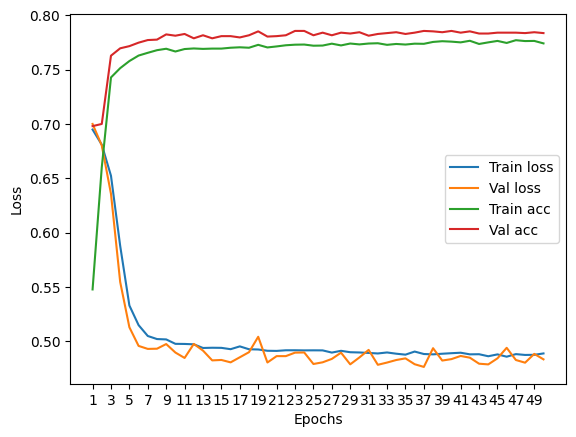

In [103]:
plot_loss(history)

Test accuracy:  77.16


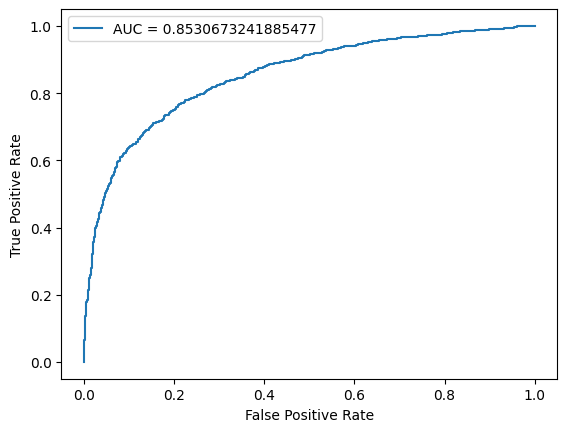

In [104]:
plot_auc(best_model, test_dataloader)

#### GCN

In [49]:
model = GCN(input_dims, hidden_dims, output_dims, activ_fn = ReLU())
model

GCN(
  (layers): ModuleList(
    (0): GCNConv()
  )
  (activ_fn): ReLU()
  (classifier): Linear(in_features=8, out_features=1, bias=True)
)

In [50]:
optimizer = Adam(model.parameters(), 1e-3)
lossFn = BCEWithLogitsLoss()
history = train_model(model, optimizer, lossFn, epochs, lr, train_dataloader, val_dataloader)

313it [00:04, 66.08it/s]


Train Epoch: 0 	Loss: 0.691258, Accuracy: 44913/79896 (56%)
Val Epoch: 0 	Loss: 0.698176, Accuracy: 6398/9987 (64%)



313it [00:04, 70.83it/s]


Train Epoch: 1 	Loss: 0.663202, Accuracy: 55216/79896 (69%)
Val Epoch: 1 	Loss: 0.656054, Accuracy: 7111/9987 (71%)



313it [00:04, 69.93it/s]


Train Epoch: 2 	Loss: 0.618083, Accuracy: 57923/79896 (72%)
Val Epoch: 2 	Loss: 0.618773, Accuracy: 7179/9987 (72%)



313it [00:07, 44.02it/s]


Train Epoch: 3 	Loss: 0.580112, Accuracy: 58275/79896 (73%)
Val Epoch: 3 	Loss: 0.581786, Accuracy: 7212/9987 (72%)



313it [00:07, 42.87it/s]


Train Epoch: 4 	Loss: 0.558145, Accuracy: 58468/79896 (73%)
Val Epoch: 4 	Loss: 0.565816, Accuracy: 7238/9987 (72%)



313it [00:07, 44.53it/s]


Train Epoch: 5 	Loss: 0.548458, Accuracy: 58495/79896 (73%)
Val Epoch: 5 	Loss: 0.561470, Accuracy: 7245/9987 (73%)



313it [00:04, 62.78it/s]


Train Epoch: 6 	Loss: 0.544776, Accuracy: 58580/79896 (73%)
Val Epoch: 6 	Loss: 0.562299, Accuracy: 7249/9987 (73%)



313it [00:04, 70.56it/s]


Train Epoch: 7 	Loss: 0.542799, Accuracy: 58615/79896 (73%)
Val Epoch: 7 	Loss: 0.559654, Accuracy: 7244/9987 (73%)



313it [00:05, 62.15it/s]


Train Epoch: 8 	Loss: 0.542252, Accuracy: 58628/79896 (73%)
Val Epoch: 8 	Loss: 0.564513, Accuracy: 7248/9987 (73%)



313it [00:05, 54.90it/s]


Train Epoch: 9 	Loss: 0.541618, Accuracy: 58595/79896 (73%)
Val Epoch: 9 	Loss: 0.576891, Accuracy: 7243/9987 (73%)



313it [00:05, 56.04it/s]


Train Epoch: 10 	Loss: 0.541468, Accuracy: 58638/79896 (73%)
Val Epoch: 10 	Loss: 0.564160, Accuracy: 7250/9987 (73%)



313it [00:05, 61.43it/s]


Train Epoch: 11 	Loss: 0.541851, Accuracy: 58632/79896 (73%)
Val Epoch: 11 	Loss: 0.573164, Accuracy: 7235/9987 (72%)



313it [00:04, 62.87it/s]


Train Epoch: 12 	Loss: 0.540906, Accuracy: 58659/79896 (73%)
Val Epoch: 12 	Loss: 0.558714, Accuracy: 7251/9987 (73%)



313it [00:05, 58.84it/s]


Train Epoch: 13 	Loss: 0.540677, Accuracy: 58674/79896 (73%)
Val Epoch: 13 	Loss: 0.565257, Accuracy: 7251/9987 (73%)



313it [00:05, 60.51it/s]


Train Epoch: 14 	Loss: 0.540512, Accuracy: 58707/79896 (73%)
Val Epoch: 14 	Loss: 0.570757, Accuracy: 7252/9987 (73%)



313it [00:05, 62.56it/s]


Train Epoch: 15 	Loss: 0.540062, Accuracy: 58698/79896 (73%)
Val Epoch: 15 	Loss: 0.572560, Accuracy: 7254/9987 (73%)



313it [00:05, 59.01it/s]


Train Epoch: 16 	Loss: 0.540879, Accuracy: 58703/79896 (73%)
Val Epoch: 16 	Loss: 0.564741, Accuracy: 7240/9987 (72%)



313it [00:04, 64.57it/s]


Train Epoch: 17 	Loss: 0.540570, Accuracy: 58700/79896 (73%)
Val Epoch: 17 	Loss: 0.569590, Accuracy: 7245/9987 (73%)



313it [00:04, 64.00it/s]


Train Epoch: 18 	Loss: 0.540337, Accuracy: 58744/79896 (74%)
Val Epoch: 18 	Loss: 0.561171, Accuracy: 7250/9987 (73%)



313it [00:06, 50.34it/s]


Train Epoch: 19 	Loss: 0.540237, Accuracy: 58650/79896 (73%)
Val Epoch: 19 	Loss: 0.560497, Accuracy: 7258/9987 (73%)



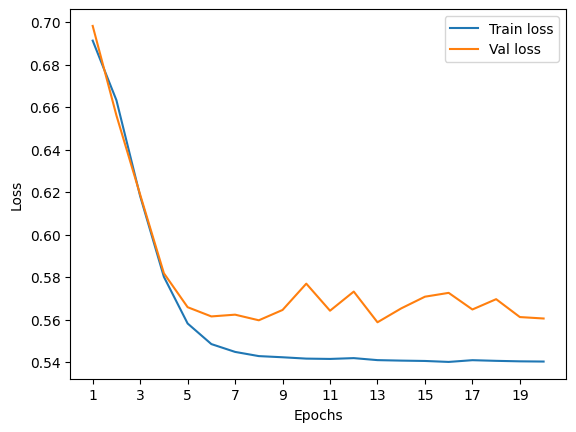

In [51]:
plot_loss(history)

#### Learning rate = 1e-2

In [52]:
model = GCN(input_dims, hidden_dims, output_dims, activ_fn = ReLU())
model

GCN(
  (layers): ModuleList(
    (0): GCNConv()
  )
  (activ_fn): ReLU()
  (classifier): Linear(in_features=8, out_features=1, bias=True)
)

In [53]:
optimizer = Adam(model.parameters(), 1e-2)
lossFn = BCEWithLogitsLoss()
history = train_model(model, optimizer, lossFn, epochs, lr, train_dataloader, val_dataloader)

313it [00:04, 63.17it/s]


Train Epoch: 0 	Loss: 0.595037, Accuracy: 55305/79896 (69%)
Val Epoch: 0 	Loss: 0.565550, Accuracy: 7233/9987 (72%)



313it [00:04, 67.61it/s]


Train Epoch: 1 	Loss: 0.542881, Accuracy: 58552/79896 (73%)
Val Epoch: 1 	Loss: 0.577155, Accuracy: 7250/9987 (73%)



313it [00:05, 57.89it/s]


Train Epoch: 2 	Loss: 0.542160, Accuracy: 58522/79896 (73%)
Val Epoch: 2 	Loss: 0.560936, Accuracy: 7248/9987 (73%)



313it [00:04, 70.39it/s]


Train Epoch: 3 	Loss: 0.541983, Accuracy: 58577/79896 (73%)
Val Epoch: 3 	Loss: 0.560007, Accuracy: 7242/9987 (73%)



313it [00:04, 68.47it/s]


Train Epoch: 4 	Loss: 0.542275, Accuracy: 58580/79896 (73%)
Val Epoch: 4 	Loss: 0.571907, Accuracy: 7224/9987 (72%)



313it [00:04, 66.91it/s]


Train Epoch: 5 	Loss: 0.541160, Accuracy: 58585/79896 (73%)
Val Epoch: 5 	Loss: 0.561459, Accuracy: 7256/9987 (73%)



313it [00:04, 73.01it/s]


Train Epoch: 6 	Loss: 0.541676, Accuracy: 58651/79896 (73%)
Val Epoch: 6 	Loss: 0.562092, Accuracy: 7239/9987 (72%)



313it [00:04, 72.98it/s]


Train Epoch: 7 	Loss: 0.541741, Accuracy: 58686/79896 (73%)
Val Epoch: 7 	Loss: 0.558041, Accuracy: 7234/9987 (72%)



313it [00:04, 66.57it/s]


Train Epoch: 8 	Loss: 0.541664, Accuracy: 58586/79896 (73%)
Val Epoch: 8 	Loss: 0.577004, Accuracy: 7246/9987 (73%)



313it [00:04, 71.08it/s]


Train Epoch: 9 	Loss: 0.541246, Accuracy: 58609/79896 (73%)
Val Epoch: 9 	Loss: 0.568409, Accuracy: 7216/9987 (72%)



313it [00:04, 72.68it/s]


Train Epoch: 10 	Loss: 0.541735, Accuracy: 58620/79896 (73%)
Val Epoch: 10 	Loss: 0.559913, Accuracy: 7253/9987 (73%)



313it [00:04, 68.15it/s]


Train Epoch: 11 	Loss: 0.540774, Accuracy: 58667/79896 (73%)
Val Epoch: 11 	Loss: 0.567683, Accuracy: 7219/9987 (72%)



313it [00:04, 71.93it/s]


Train Epoch: 12 	Loss: 0.541144, Accuracy: 58681/79896 (73%)
Val Epoch: 12 	Loss: 0.560397, Accuracy: 7237/9987 (72%)



313it [00:04, 73.23it/s]


Train Epoch: 13 	Loss: 0.541790, Accuracy: 58619/79896 (73%)
Val Epoch: 13 	Loss: 0.564516, Accuracy: 7149/9987 (72%)



313it [00:04, 70.63it/s]


Train Epoch: 14 	Loss: 0.541562, Accuracy: 58554/79896 (73%)
Val Epoch: 14 	Loss: 0.572395, Accuracy: 7202/9987 (72%)



313it [00:04, 68.67it/s]


Train Epoch: 15 	Loss: 0.541923, Accuracy: 58594/79896 (73%)
Val Epoch: 15 	Loss: 0.567778, Accuracy: 7264/9987 (73%)



313it [00:04, 72.70it/s]


Train Epoch: 16 	Loss: 0.540964, Accuracy: 58685/79896 (73%)
Val Epoch: 16 	Loss: 0.560973, Accuracy: 7230/9987 (72%)



313it [00:04, 73.24it/s]


Train Epoch: 17 	Loss: 0.542003, Accuracy: 58602/79896 (73%)
Val Epoch: 17 	Loss: 0.558957, Accuracy: 7248/9987 (73%)



313it [00:04, 66.18it/s]


Train Epoch: 18 	Loss: 0.541065, Accuracy: 58604/79896 (73%)
Val Epoch: 18 	Loss: 0.555789, Accuracy: 7232/9987 (72%)



313it [00:04, 72.20it/s]


Train Epoch: 19 	Loss: 0.541169, Accuracy: 58626/79896 (73%)
Val Epoch: 19 	Loss: 0.561742, Accuracy: 7254/9987 (73%)



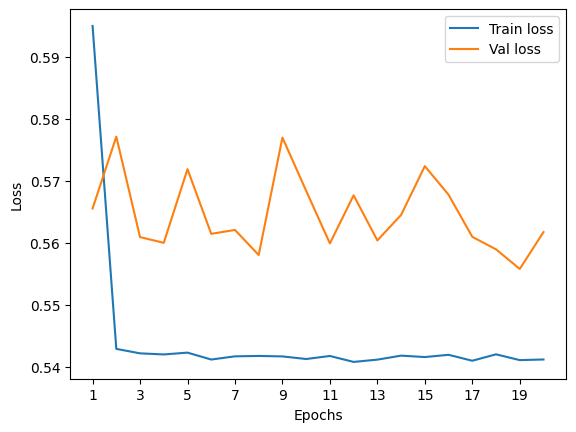

In [54]:
plot_loss(history)

### Parameterized quantum circuit - Node Embedding QNN

In [51]:
def H_layer(nqubits):
    """Layer of single-qubit Hadamard gates.
    """
    for idx in range(nqubits):
        qml.Hadamard(wires=idx)

def encoder(w):
    """Layer of parametrized qubit rotations around the x axis.
    """
    for idx, element in enumerate(w):
        qml.RY(element, wires=idx)

def Rot_layer(gate, w):
    """Layer of parametrized qubit rotations around the y axis.
    """
    for idx, element in enumerate(w):
        gate(element, wires=idx)


def entangling_layer(nqubits):
    """Layers of CZ and RY gates.
    """
    for i in range(0, nqubits - 1):  # Loop over even indices: i=0,2,...N-2
        qml.CNOT(wires=[i, i + 1])
        
    qml.CNOT(wires=[nqubits-1, 0])

In [52]:
def quantum_net(n_qubits, q_depth):
    
    dev = qml.device("default.qubit", wires=n_qubits)
    
    @qml.qnode(dev, interface='torch')
    def quantum_circuit(inputs, q_weights_flat):
        """
        The variational quantum circuit.
        """

        # Reshape weights
        q_weights = q_weights_flat.reshape(q_depth, 2, n_qubits)

        # Embed features in the quantum node
        qml.AngleEmbedding(inputs, wires = range(n_qubits), rotation="Y")

        # Sequence of trainable variational layers
        for k in range(q_depth):
            Rot_layer(qml.RY, q_weights[k][0])
            entangling_layer(n_qubits)
            Rot_layer(qml.RZ, q_weights[k][1])

        # Expectation values in the Z basis
        exp_vals = [qml.expval(qml.PauliZ(position)) for position in range(n_qubits)]
        return exp_vals
    
    return qml.qnn.TorchLayer(quantum_circuit, {"q_weights_flat": (2*q_depth*n_qubits)}), quantum_circuit

### Visualizing the quantum layer

In [128]:
_, qc = quantum_net(8,1)
inputs = torch.randn(8)
params = torch.randn(2*8)
print(qml.draw(qc)(inputs, params))

0: ─╭AngleEmbedding(M0)──RY(-1.31)─╭●───────────────────╭X──RZ(-0.43)─┤  <Z>
1: ─├AngleEmbedding(M0)──RY(-0.27)─╰X─╭●────────────────│───RZ(1.93)──┤  <Z>
2: ─├AngleEmbedding(M0)──RY(-1.13)────╰X─╭●─────────────│───RZ(-0.02)─┤  <Z>
3: ─├AngleEmbedding(M0)──RY(-0.93)───────╰X─╭●──────────│───RZ(0.65)──┤  <Z>
4: ─├AngleEmbedding(M0)──RY(-0.43)──────────╰X─╭●───────│───RZ(-0.41)─┤  <Z>
5: ─├AngleEmbedding(M0)──RY(-0.77)─────────────╰X─╭●────│───RZ(1.10)──┤  <Z>
6: ─├AngleEmbedding(M0)──RY(-0.97)────────────────╰X─╭●─│───RZ(0.19)──┤  <Z>
7: ─╰AngleEmbedding(M0)──RY(-0.28)───────────────────╰X─╰●──RZ(1.33)──┤  <Z>

M0 = 
tensor([ 0.1431, -0.6187, -0.4107, -1.5951,  1.0618,  0.0777,  0.8359,  0.3899])


In [120]:
batch_dim = 5
x = torch.zeros((batch_dim, 3))
qlayer, _ = quantum_net(3,1)
qlayer(x).shape

torch.Size([5, 3])

### Quantum Classifier

### 1. Matrix Product State Classifier

In [53]:
def MPS(n_qubits):
    dev = qml.device("default.qubit", wires=n_qubits)
    
    @qml.qnode(dev, interface='torch')
    def quantum_circuit(inputs, q_weights_flat):
        """
        The variational quantum classifier.
        """
        
        # Reshape weights
        q_weights = q_weights_flat[:-1].reshape(n_qubits-1, 2)

        # Embed features in the quantum node
        qml.AngleEmbedding(inputs, wires = range(n_qubits), rotation="Y")

        # Sequence of trainable variational layers
        for k in range(n_qubits-1):
            qml.RY(q_weights[k][0], wires=k)
            qml.RY(q_weights[k][1], wires=k+1)
            qml.CZ(wires=[k,k+1])
            
        qml.RY(q_weights_flat[-1], wires=n_qubits-1)

        # Expectation values in the Z basis
        return [qml.expval(qml.PauliZ(n_qubits - 1))]
        # return [qml.expval(qml.operation.CVObservable(q_weights_flat[-1], qml.PauliZ(n_qubits - 1)))]
    
    return qml.qnn.TorchLayer(quantum_circuit, {"q_weights_flat": (2*n_qubits - 1)}), quantum_circuit

In [131]:
_, qc = MPS(6)
inputs = torch.randn(6)
params = torch.randn(2*6-1)
print(qml.draw(qc)(inputs, params))

0: ─╭AngleEmbedding(M0)──RY(-1.04)─╭●─────────────────────────────────────────────────────
1: ─├AngleEmbedding(M0)──RY(0.44)──╰Z──RY(-0.70)─╭●───────────────────────────────────────
2: ─├AngleEmbedding(M0)──RY(-1.47)───────────────╰Z──RY(1.09)─╭●──────────────────────────
3: ─├AngleEmbedding(M0)──RY(-1.54)────────────────────────────╰Z──RY(2.23)─╭●─────────────
4: ─├AngleEmbedding(M0)──RY(-0.50)─────────────────────────────────────────╰Z──RY(0.39)─╭●
5: ─╰AngleEmbedding(M0)──RY(0.04)───────────────────────────────────────────────────────╰Z

─────────────┤     
─────────────┤     
─────────────┤     
─────────────┤     
─────────────┤     
───RY(-0.52)─┤  <Z>

M0 = 
tensor([-0.6462,  0.8152, -1.1428,  1.2935,  1.2888, -0.5991])


None

### 2. Tensor Tree Network Classifier

In [54]:
def TTN(n_qubits):
    
    dev = qml.device("default.qubit", wires=n_qubits)
    
    @qml.qnode(dev, interface='torch')
    def quantum_circuit(inputs, q_weights_flat):
        """
        The variational quantum classifier.
        """
        
        # Embed features in the quantum node
        qml.AngleEmbedding(inputs, wires = range(n_qubits), rotation="Y")
        
        n_layers = int(np.log2(n_qubits))
        i = 0
        n_params = int(2**(np.log2(n_qubits)+1)-2 +1) 
        
        for layer in range(n_layers):
            n_gates = n_qubits//(2**(layer+1))
            for j in range(n_gates):
                qubit0 = j * (n_qubits//(2**(n_layers-layer-1))) + 2**layer - 1
                qubit1 = j * (n_qubits//(2**(n_layers-layer-1))) + 2**(layer+1) - 1
                qml.RY(q_weights_flat[i], wires=qubit0)
                qml.RY(q_weights_flat[i+1], wires=qubit1)
                qml.CZ(wires=[qubit0,qubit1])
                i += 2
        
        qml.RY(q_weights_flat[-1], wires=n_qubits-1)

        # Expectation values in the Z basis
        return [qml.expval(qml.PauliZ(n_qubits - 1))]
    
    return qml.qnn.TorchLayer(quantum_circuit, {"q_weights_flat": int(2**(np.log2(n_qubits)+1)-2 +1)}), quantum_circuit

In [124]:
_, qc = TTN(8)
inputs = torch.randn(8)
params = torch.randn(int(2**(np.log2(8)+1)-2 +1))
print(qml.draw(qc)(inputs, params))

0: ─╭AngleEmbedding(M0)──RY(-0.64)─╭●───────────────────────────────────────┤     
1: ─├AngleEmbedding(M0)──RY(-0.54)─╰Z──RY(-0.19)─╭●─────────────────────────┤     
2: ─├AngleEmbedding(M0)──RY(-1.17)─╭●────────────│──────────────────────────┤     
3: ─├AngleEmbedding(M0)──RY(-0.03)─╰Z──RY(0.86)──╰Z──RY(-1.11)─╭●───────────┤     
4: ─├AngleEmbedding(M0)──RY(-0.74)─╭●──────────────────────────│────────────┤     
5: ─├AngleEmbedding(M0)──RY(0.00)──╰Z──RY(0.71)──╭●────────────│────────────┤     
6: ─├AngleEmbedding(M0)──RY(-0.93)─╭●────────────│─────────────│────────────┤     
7: ─╰AngleEmbedding(M0)──RY(-0.30)─╰Z──RY(-0.68)─╰Z──RY(1.45)──╰Z──RY(0.52)─┤  <Z>

M0 = 
tensor([ 0.1954,  0.5870,  0.3240,  0.6788, -1.5293, -0.0176,  0.9008,  0.2362])


### Quantum Enhanced GAT

In [63]:
class QGATConv(MessagePassing):
    def __init__(self, in_channels, depth, attn_model):
        super().__init__(aggr='add')  # "Add" aggregation (Step 5).
        self.bias = nn.Parameter(torch.empty(in_channels))
        self.reset_parameters()
        self.n_qubits = in_channels
        self.qc, _ = quantum_net(self.n_qubits, depth)
        
        if attn_model == "MPS":
            self.attn, _ = MPS(in_channels*2)
        else:
            self.attn, _ = TTN(in_channels*2)
            
        self.readout = Linear(1, 1)
        self.attn = Linear(in_channels*2, 1)
            

    def reset_parameters(self):
        self.bias.data.zero_()

    def forward(self, x, edge_index, edge_attr):
        # x has shape [N, in_channels]
        # edge_index has shape [2, E]
        
        # Step 1: Add self-loops to the adjacency matrix.
        edge_index, edge_attr = remove_self_loops(edge_index, edge_attr)
        edge_index, edge_attr = add_self_loops(edge_index, edge_attr, num_nodes=x.size(0))

        # Step 2: Linearly transform node feature matrix
        
        q_out = self.qc(x).float()

        # Step 3: Compute normalization.
#         row, col = edge_index
#         deg = degree(col, q_out.size(0), dtype=q_out.dtype)
#         deg_inv_sqrt = deg.pow(-0.5)
#         deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
#         norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

        # Step 4-5: Start propagating messages.
        out = self.propagate(edge_index, x=q_out)

        # Step 6: Apply a final bias vector.
        out = out + self.bias

        return out

    def message(self, x_i, x_j):
        # x_j has shape [E, out_channels]

        x_edge = torch.cat((x_i,x_j),dim=1)
        x_edge = self.attn(x_edge)
        x_edge = self.readout(x_edge)
        return x_edge.view(-1, 1) * x_j

In [64]:
class QGAT(nn.Module):

    def __init__(self, input_dims, depth, n_layers, activ_fn = LeakyReLU(0.2), classifier="MPS", attn_model="MPS"):
        
        super().__init__()
        layers = []
    
        for i in range(n_layers):
            layers.append(QGATConv(input_dims, depth, attn_model))
            
        self.layers = ModuleList(layers)
        self.activ_fn = activ_fn
        if classifier == "MPS" :
            self.classifier, _ = MPS(input_dims+5)
        elif classifier == "TTN":
            self.classifier, _ = TTN(input_dims+5)
            
        self.readout = Linear(1,1)

    def forward(self, x, edge_index, edge_attr, batch, graph_features):
        """
        Defining how tensors are supposed to move through the *dressed* quantum
        net.
        """
        
        h = x
        for i in range(len(self.layers)):
            h = self.layers[i](h, edge_index, edge_attr)
            h = self.activ_fn(h)
            
        h = global_mean_pool(h, batch)   # readout layer to get the embedding for each graph in batch
        h = torch.cat((h, graph_features.float().reshape(-1,5)), dim=1)
        h = self.classifier(h)
        h = self.readout(h)
        return h

### Quantum-enhanced GCN

In [121]:
class QGCNConv(MessagePassing):
    def __init__(self, in_channels):
        super().__init__(aggr='add')  # "Add" aggregation (Step 5).
        self.bias = nn.Parameter(torch.empty(in_channels))
        self.reset_parameters()
        self.n_qubits = in_channels
        self.qc, _ = quantum_net(self.n_qubits, q_depth)

    def reset_parameters(self):
        self.bias.data.zero_()

    def forward(self, x, edge_index, edge_weights):
        # x has shape [N, in_channels]
        # edge_index has shape [2, E]

        # Step 1: Add self-loops to the adjacency matrix.
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))

        # Step 2: Linearly transform node feature matrix
        
        q_out = self.qc(x).float()

        # Step 3: Compute normalization.
        row, col = edge_index
        deg = degree(col, q_out.size(0), dtype=q_out.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

        # Step 4-5: Start propagating messages.
        out = self.propagate(edge_index, x=q_out, weights=edge_weights, norm=norm)

        # Step 6: Apply a final bias vector.
        out = out + self.bias

        return out

    def message(self, x_j, weights, norm):
        # x_j has shape [E, out_channels]

        # Step 4: Normalize node features.
        return norm.view(-1, 1) * x_j

In [122]:
class QGCN(nn.Module):

    def __init__(self, input_dims, output_dims, activ_fn = LeakyReLU(0.2), classifier = None, readout = False):
        
        super().__init__()
        layers = [QGCNConv(input_dims)]
        self.layers = ModuleList(layers)
        self.activ_fn = activ_fn
        
        if readout:
            self.readout = Linear(1, 1)
        else:
            self.readout = None
            
        if classifier == "MPS" :
            assert output_dims == 1
            self.classifier, _ = MPS(input_dims+5)
        elif classifier == "TTN":
            assert output_dims == 1
            self.classifier, _ = TTN(input_dims+5)
        else:
            self.classifier = nn.Linear(input_dims+5, output_dims)

    def forward(self, x, edge_index, edge_weights, batch, graph_features):
        """
        Defining how tensors are supposed to move through the *dressed* quantum
        net.
        """
        
        h = x
        for i in range(len(self.layers)):
            h = self.layers[i](h, edge_index, edge_weights)
            h = self.activ_fn(h)
         
        h = global_mean_pool(h, batch)   # readout layer to get the embedding for each graph in batch
        
        h = torch.cat((h, graph_features.reshape(-1,5)), dim=1)
        h = self.classifier(h)
        
        if self.readout is not None:
            h = self.readout(h)

        # return the two-dimensional prediction from the postprocessing layer
        return h

### QGCN with classical classifier

#### Leaky ReLU

#### Learning rate = 1e-3

In [69]:
epochs = 20

In [70]:
model = QGCN(input_dims, output_dims)
model

QGCN(
  (layers): ModuleList(
    (0): QGCNConv()
  )
  (activ_fn): LeakyReLU(negative_slope=0.2)
  (classifier): Linear(in_features=8, out_features=1, bias=True)
)

In [71]:
[p.numel() for p in model.parameters()]

[8, 16, 8, 1]

In [72]:
optimizer = Adam(model.parameters(), 1e-3)
lossFn = BCEWithLogitsLoss()
history = train_model(model, optimizer, lossFn, epochs, lr, train_dataloader, val_dataloader)

313it [01:15,  4.15it/s]


Train Epoch: 0 	Loss: 0.695361, Accuracy: 40269/79896 (50%)
Val Epoch: 0 	Loss: 0.710435, Accuracy: 5138/9987 (51%)



313it [01:08,  4.54it/s]


Train Epoch: 1 	Loss: 0.694552, Accuracy: 41769/79896 (52%)
Val Epoch: 1 	Loss: 0.709177, Accuracy: 5362/9987 (54%)



313it [01:09,  4.48it/s]


Train Epoch: 2 	Loss: 0.692177, Accuracy: 44468/79896 (56%)
Val Epoch: 2 	Loss: 0.704949, Accuracy: 5908/9987 (59%)



313it [01:16,  4.07it/s]


Train Epoch: 3 	Loss: 0.682474, Accuracy: 51352/79896 (64%)
Val Epoch: 3 	Loss: 0.688486, Accuracy: 6822/9987 (68%)



313it [01:17,  4.04it/s]


Train Epoch: 4 	Loss: 0.657795, Accuracy: 55352/79896 (69%)
Val Epoch: 4 	Loss: 0.659469, Accuracy: 6922/9987 (69%)



313it [01:16,  4.07it/s]


Train Epoch: 5 	Loss: 0.630579, Accuracy: 56058/79896 (70%)
Val Epoch: 5 	Loss: 0.631465, Accuracy: 7022/9987 (70%)



313it [01:10,  4.47it/s]


Train Epoch: 6 	Loss: 0.610910, Accuracy: 57063/79896 (71%)
Val Epoch: 6 	Loss: 0.621220, Accuracy: 7106/9987 (71%)



313it [01:05,  4.74it/s]


Train Epoch: 7 	Loss: 0.597900, Accuracy: 57591/79896 (72%)
Val Epoch: 7 	Loss: 0.614443, Accuracy: 7146/9987 (72%)



313it [01:01,  5.08it/s]


Train Epoch: 8 	Loss: 0.587835, Accuracy: 57887/79896 (72%)
Val Epoch: 8 	Loss: 0.604762, Accuracy: 7189/9987 (72%)



313it [01:00,  5.21it/s]


Train Epoch: 9 	Loss: 0.579909, Accuracy: 58136/79896 (73%)
Val Epoch: 9 	Loss: 0.597862, Accuracy: 7224/9987 (72%)



313it [01:04,  4.88it/s]


Train Epoch: 10 	Loss: 0.573172, Accuracy: 58204/79896 (73%)
Val Epoch: 10 	Loss: 0.586356, Accuracy: 7240/9987 (72%)



313it [01:09,  4.51it/s]


Train Epoch: 11 	Loss: 0.568160, Accuracy: 58203/79896 (73%)
Val Epoch: 11 	Loss: 0.581701, Accuracy: 7239/9987 (72%)



313it [01:08,  4.59it/s]


Train Epoch: 12 	Loss: 0.563978, Accuracy: 58322/79896 (73%)
Val Epoch: 12 	Loss: 0.575831, Accuracy: 7242/9987 (73%)



313it [01:05,  4.77it/s]


Train Epoch: 13 	Loss: 0.561009, Accuracy: 58275/79896 (73%)
Val Epoch: 13 	Loss: 0.586465, Accuracy: 7240/9987 (72%)



313it [01:03,  4.94it/s]


Train Epoch: 14 	Loss: 0.558245, Accuracy: 58331/79896 (73%)
Val Epoch: 14 	Loss: 0.579308, Accuracy: 7219/9987 (72%)



313it [01:01,  5.13it/s]


Train Epoch: 15 	Loss: 0.555750, Accuracy: 58356/79896 (73%)
Val Epoch: 15 	Loss: 0.572884, Accuracy: 7230/9987 (72%)



313it [01:02,  4.97it/s]


Train Epoch: 16 	Loss: 0.553991, Accuracy: 58341/79896 (73%)
Val Epoch: 16 	Loss: 0.577180, Accuracy: 7228/9987 (72%)



313it [00:58,  5.38it/s]


Train Epoch: 17 	Loss: 0.552797, Accuracy: 58346/79896 (73%)
Val Epoch: 17 	Loss: 0.571935, Accuracy: 7197/9987 (72%)



313it [01:00,  5.17it/s]


Train Epoch: 18 	Loss: 0.551446, Accuracy: 58330/79896 (73%)
Val Epoch: 18 	Loss: 0.567999, Accuracy: 7227/9987 (72%)



313it [01:00,  5.16it/s]


Train Epoch: 19 	Loss: 0.550683, Accuracy: 58350/79896 (73%)
Val Epoch: 19 	Loss: 0.577886, Accuracy: 7227/9987 (72%)



313it [00:59,  5.25it/s]


Train Epoch: 20 	Loss: 0.549451, Accuracy: 58380/79896 (73%)
Val Epoch: 20 	Loss: 0.561432, Accuracy: 7225/9987 (72%)



313it [01:00,  5.17it/s]


Train Epoch: 21 	Loss: 0.549053, Accuracy: 58323/79896 (73%)
Val Epoch: 21 	Loss: 0.571432, Accuracy: 7238/9987 (72%)



313it [00:59,  5.27it/s]


Train Epoch: 22 	Loss: 0.548114, Accuracy: 58391/79896 (73%)
Val Epoch: 22 	Loss: 0.566905, Accuracy: 7217/9987 (72%)



313it [00:46,  6.69it/s]


Train Epoch: 23 	Loss: 0.548183, Accuracy: 58383/79896 (73%)
Val Epoch: 23 	Loss: 0.564539, Accuracy: 7232/9987 (72%)



313it [00:50,  6.23it/s]


Train Epoch: 24 	Loss: 0.547540, Accuracy: 58364/79896 (73%)
Val Epoch: 24 	Loss: 0.562457, Accuracy: 7230/9987 (72%)



313it [00:50,  6.15it/s]


Train Epoch: 25 	Loss: 0.547715, Accuracy: 58362/79896 (73%)
Val Epoch: 25 	Loss: 0.561972, Accuracy: 7238/9987 (72%)



313it [00:52,  5.96it/s]


Train Epoch: 26 	Loss: 0.547368, Accuracy: 58347/79896 (73%)
Val Epoch: 26 	Loss: 0.571377, Accuracy: 7231/9987 (72%)



313it [00:53,  5.81it/s]


Train Epoch: 27 	Loss: 0.546970, Accuracy: 58342/79896 (73%)
Val Epoch: 27 	Loss: 0.579671, Accuracy: 7226/9987 (72%)



313it [00:57,  5.41it/s]


Train Epoch: 28 	Loss: 0.547003, Accuracy: 58365/79896 (73%)
Val Epoch: 28 	Loss: 0.577450, Accuracy: 7217/9987 (72%)



313it [00:58,  5.38it/s]


Train Epoch: 29 	Loss: 0.546652, Accuracy: 58327/79896 (73%)
Val Epoch: 29 	Loss: 0.559124, Accuracy: 7238/9987 (72%)



313it [01:00,  5.17it/s]


Train Epoch: 30 	Loss: 0.547368, Accuracy: 58324/79896 (73%)
Val Epoch: 30 	Loss: 0.561990, Accuracy: 7198/9987 (72%)



313it [01:00,  5.17it/s]


Train Epoch: 31 	Loss: 0.547058, Accuracy: 58342/79896 (73%)
Val Epoch: 31 	Loss: 0.566332, Accuracy: 7238/9987 (72%)



313it [00:59,  5.24it/s]


Train Epoch: 32 	Loss: 0.546747, Accuracy: 58378/79896 (73%)
Val Epoch: 32 	Loss: 0.569443, Accuracy: 7219/9987 (72%)



313it [00:59,  5.22it/s]


Train Epoch: 33 	Loss: 0.546683, Accuracy: 58337/79896 (73%)
Val Epoch: 33 	Loss: 0.579489, Accuracy: 7219/9987 (72%)



313it [00:59,  5.22it/s]


Train Epoch: 34 	Loss: 0.546447, Accuracy: 58429/79896 (73%)
Val Epoch: 34 	Loss: 0.558793, Accuracy: 7233/9987 (72%)



313it [01:01,  5.10it/s]


Train Epoch: 35 	Loss: 0.546394, Accuracy: 58366/79896 (73%)
Val Epoch: 35 	Loss: 0.561584, Accuracy: 7233/9987 (72%)



313it [01:00,  5.14it/s]


Train Epoch: 36 	Loss: 0.546913, Accuracy: 58377/79896 (73%)
Val Epoch: 36 	Loss: 0.559189, Accuracy: 7202/9987 (72%)



313it [01:00,  5.16it/s]


Train Epoch: 37 	Loss: 0.546419, Accuracy: 58384/79896 (73%)
Val Epoch: 37 	Loss: 0.558153, Accuracy: 7233/9987 (72%)



313it [01:04,  4.83it/s]


Train Epoch: 38 	Loss: 0.546596, Accuracy: 58410/79896 (73%)
Val Epoch: 38 	Loss: 0.583460, Accuracy: 7227/9987 (72%)



313it [01:01,  5.08it/s]


Train Epoch: 39 	Loss: 0.546252, Accuracy: 58364/79896 (73%)
Val Epoch: 39 	Loss: 0.572163, Accuracy: 7240/9987 (72%)



313it [01:00,  5.17it/s]


Train Epoch: 40 	Loss: 0.546630, Accuracy: 58369/79896 (73%)
Val Epoch: 40 	Loss: 0.565926, Accuracy: 7180/9987 (72%)



313it [01:00,  5.19it/s]


Train Epoch: 41 	Loss: 0.546398, Accuracy: 58353/79896 (73%)
Val Epoch: 41 	Loss: 0.562420, Accuracy: 7217/9987 (72%)



313it [01:04,  4.82it/s]


Train Epoch: 42 	Loss: 0.546834, Accuracy: 58373/79896 (73%)
Val Epoch: 42 	Loss: 0.564027, Accuracy: 7235/9987 (72%)



313it [01:06,  4.73it/s]


Train Epoch: 43 	Loss: 0.546298, Accuracy: 58404/79896 (73%)
Val Epoch: 43 	Loss: 0.565801, Accuracy: 7209/9987 (72%)



313it [01:00,  5.17it/s]


Train Epoch: 44 	Loss: 0.546455, Accuracy: 58375/79896 (73%)
Val Epoch: 44 	Loss: 0.569257, Accuracy: 7245/9987 (73%)



313it [01:16,  4.09it/s]


Train Epoch: 45 	Loss: 0.546225, Accuracy: 58351/79896 (73%)
Val Epoch: 45 	Loss: 0.557775, Accuracy: 7222/9987 (72%)



313it [01:19,  3.96it/s]


Train Epoch: 46 	Loss: 0.547006, Accuracy: 58410/79896 (73%)
Val Epoch: 46 	Loss: 0.573467, Accuracy: 7206/9987 (72%)



313it [01:34,  3.30it/s]


Train Epoch: 47 	Loss: 0.546410, Accuracy: 58398/79896 (73%)
Val Epoch: 47 	Loss: 0.565280, Accuracy: 7201/9987 (72%)



313it [01:05,  4.81it/s]


Train Epoch: 48 	Loss: 0.546191, Accuracy: 58396/79896 (73%)
Val Epoch: 48 	Loss: 0.563323, Accuracy: 7240/9987 (72%)



313it [00:59,  5.25it/s]


Train Epoch: 49 	Loss: 0.546371, Accuracy: 58418/79896 (73%)
Val Epoch: 49 	Loss: 0.587335, Accuracy: 7234/9987 (72%)



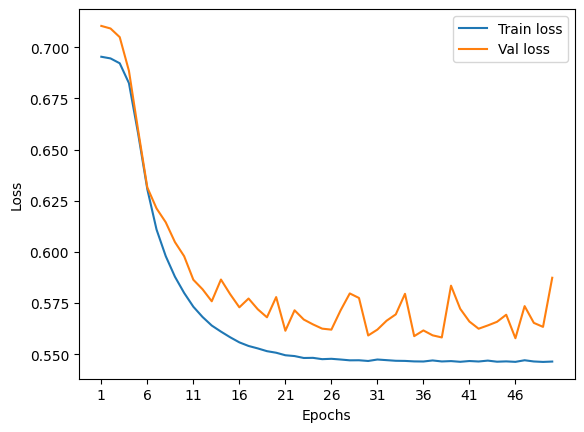

In [73]:
plot_loss(history, step = 5)

In [ ]:
plot_auc(model, test_dataloader)

#### Learning rate = 1e-2

In [99]:
q_depth = 1
model = QGCN(input_dims, output_dims)
model

QGCN(
  (layers): ModuleList(
    (0): QGCNConv()
  )
  (activ_fn): LeakyReLU(negative_slope=0.2)
  (classifier): Linear(in_features=8, out_features=1, bias=True)
)

In [100]:
optimizer = Adam(model.parameters(), 1e-2)
lossFn = BCEWithLogitsLoss()
history = train_model(model, optimizer, lossFn, epochs, lr, train_dataloader, val_dataloader)

235it [07:40,  1.96s/it]


Train Epoch: 0 	Loss: 0.687883, Accuracy: 34386/60000 (57%)
Val Epoch: 0 	Loss: 0.684034, Accuracy: 11081/20000 (55%)



235it [08:42,  2.22s/it]


Train Epoch: 1 	Loss: 0.669939, Accuracy: 38664/60000 (64%)
Val Epoch: 1 	Loss: 0.667542, Accuracy: 12823/20000 (64%)



235it [07:55,  2.02s/it]


Train Epoch: 2 	Loss: 0.654657, Accuracy: 40437/60000 (67%)
Val Epoch: 2 	Loss: 0.652152, Accuracy: 13909/20000 (70%)



235it [07:55,  2.02s/it]


Train Epoch: 3 	Loss: 0.643365, Accuracy: 40850/60000 (68%)
Val Epoch: 3 	Loss: 0.649373, Accuracy: 12643/20000 (63%)



235it [08:32,  2.18s/it]


Train Epoch: 4 	Loss: 0.633750, Accuracy: 41467/60000 (69%)
Val Epoch: 4 	Loss: 0.631803, Accuracy: 14203/20000 (71%)



235it [07:42,  1.97s/it]


Train Epoch: 5 	Loss: 0.624157, Accuracy: 42353/60000 (71%)
Val Epoch: 5 	Loss: 0.623892, Accuracy: 14457/20000 (72%)



235it [07:46,  1.99s/it]


Train Epoch: 6 	Loss: 0.614691, Accuracy: 43169/60000 (72%)
Val Epoch: 6 	Loss: 0.615123, Accuracy: 14842/20000 (74%)



235it [07:50,  2.00s/it]


Train Epoch: 7 	Loss: 0.607336, Accuracy: 43460/60000 (72%)
Val Epoch: 7 	Loss: 0.609520, Accuracy: 14098/20000 (70%)



235it [09:16,  2.37s/it]


Train Epoch: 8 	Loss: 0.602581, Accuracy: 43118/60000 (72%)
Val Epoch: 8 	Loss: 0.601147, Accuracy: 14956/20000 (75%)



235it [09:33,  2.44s/it]


Train Epoch: 9 	Loss: 0.593874, Accuracy: 44079/60000 (73%)
Val Epoch: 9 	Loss: 0.593624, Accuracy: 14731/20000 (74%)



235it [06:55,  1.77s/it]


Train Epoch: 10 	Loss: 0.591374, Accuracy: 43331/60000 (72%)
Val Epoch: 10 	Loss: 0.596127, Accuracy: 14445/20000 (72%)



235it [06:31,  1.67s/it]


Train Epoch: 11 	Loss: 0.582459, Accuracy: 44366/60000 (74%)
Val Epoch: 11 	Loss: 0.612058, Accuracy: 12326/20000 (62%)



235it [06:32,  1.67s/it]


Train Epoch: 12 	Loss: 0.578600, Accuracy: 44090/60000 (73%)
Val Epoch: 12 	Loss: 0.585679, Accuracy: 14545/20000 (73%)



235it [06:30,  1.66s/it]


Train Epoch: 13 	Loss: 0.571984, Accuracy: 44849/60000 (75%)
Val Epoch: 13 	Loss: 0.569971, Accuracy: 15179/20000 (76%)



235it [06:29,  1.66s/it]


Train Epoch: 14 	Loss: 0.567542, Accuracy: 44842/60000 (75%)
Val Epoch: 14 	Loss: 0.580786, Accuracy: 14429/20000 (72%)



235it [06:38,  1.70s/it]


Train Epoch: 15 	Loss: 0.566959, Accuracy: 44445/60000 (74%)
Val Epoch: 15 	Loss: 0.564647, Accuracy: 15165/20000 (76%)



235it [06:28,  1.65s/it]


Train Epoch: 16 	Loss: 0.560620, Accuracy: 44776/60000 (75%)
Val Epoch: 16 	Loss: 0.563148, Accuracy: 14754/20000 (74%)



235it [06:33,  1.68s/it]


Train Epoch: 17 	Loss: 0.556974, Accuracy: 44852/60000 (75%)
Val Epoch: 17 	Loss: 0.577534, Accuracy: 14204/20000 (71%)



235it [06:34,  1.68s/it]


Train Epoch: 18 	Loss: 0.553842, Accuracy: 44830/60000 (75%)
Val Epoch: 18 	Loss: 0.551712, Accuracy: 15268/20000 (76%)



235it [06:27,  1.65s/it]


Train Epoch: 19 	Loss: 0.550670, Accuracy: 44949/60000 (75%)
Val Epoch: 19 	Loss: 0.547820, Accuracy: 15194/20000 (76%)



In [101]:
history_2 = train_model(model, optimizer, lossFn, epochs, lr, train_dataloader, val_dataloader)

235it [05:39,  1.44s/it]


Train Epoch: 0 	Loss: 0.550503, Accuracy: 44640/60000 (74%)
Val Epoch: 0 	Loss: 0.547356, Accuracy: 15202/20000 (76%)



235it [06:32,  1.67s/it]


Train Epoch: 1 	Loss: 0.545885, Accuracy: 44919/60000 (75%)
Val Epoch: 1 	Loss: 0.550179, Accuracy: 15022/20000 (75%)



235it [06:41,  1.71s/it]


Train Epoch: 2 	Loss: 0.546324, Accuracy: 44659/60000 (74%)
Val Epoch: 2 	Loss: 0.554220, Accuracy: 14570/20000 (73%)



235it [06:39,  1.70s/it]


Train Epoch: 3 	Loss: 0.542907, Accuracy: 44919/60000 (75%)
Val Epoch: 3 	Loss: 0.541640, Accuracy: 15022/20000 (75%)



235it [06:40,  1.71s/it]


Train Epoch: 4 	Loss: 0.538560, Accuracy: 45014/60000 (75%)
Val Epoch: 4 	Loss: 0.535946, Accuracy: 15240/20000 (76%)



235it [06:29,  1.66s/it]


Train Epoch: 5 	Loss: 0.537158, Accuracy: 45120/60000 (75%)
Val Epoch: 5 	Loss: 0.535672, Accuracy: 15217/20000 (76%)



235it [06:33,  1.67s/it]


Train Epoch: 6 	Loss: 0.535820, Accuracy: 45048/60000 (75%)
Val Epoch: 6 	Loss: 0.534406, Accuracy: 15273/20000 (76%)



235it [06:46,  1.73s/it]


Train Epoch: 7 	Loss: 0.533036, Accuracy: 44974/60000 (75%)
Val Epoch: 7 	Loss: 0.544678, Accuracy: 14978/20000 (75%)



235it [06:33,  1.67s/it]


Train Epoch: 8 	Loss: 0.532110, Accuracy: 45122/60000 (75%)
Val Epoch: 8 	Loss: 0.531890, Accuracy: 15294/20000 (76%)



235it [06:31,  1.67s/it]


Train Epoch: 9 	Loss: 0.530604, Accuracy: 45191/60000 (75%)
Val Epoch: 9 	Loss: 0.532612, Accuracy: 15133/20000 (76%)



235it [06:34,  1.68s/it]


Train Epoch: 10 	Loss: 0.531583, Accuracy: 45046/60000 (75%)
Val Epoch: 10 	Loss: 0.531970, Accuracy: 15022/20000 (75%)



235it [06:31,  1.66s/it]


Train Epoch: 11 	Loss: 0.532265, Accuracy: 45005/60000 (75%)
Val Epoch: 11 	Loss: 0.523930, Accuracy: 15281/20000 (76%)



235it [06:32,  1.67s/it]


Train Epoch: 12 	Loss: 0.524386, Accuracy: 45399/60000 (76%)
Val Epoch: 12 	Loss: 0.523083, Accuracy: 15271/20000 (76%)



235it [07:21,  1.88s/it]


Train Epoch: 13 	Loss: 0.527179, Accuracy: 45157/60000 (75%)
Val Epoch: 13 	Loss: 0.523998, Accuracy: 15290/20000 (76%)



235it [09:44,  2.49s/it]


Train Epoch: 14 	Loss: 0.526081, Accuracy: 45216/60000 (75%)
Val Epoch: 14 	Loss: 0.524916, Accuracy: 15095/20000 (75%)



235it [08:10,  2.09s/it]


Train Epoch: 15 	Loss: 0.526730, Accuracy: 45128/60000 (75%)
Val Epoch: 15 	Loss: 0.537180, Accuracy: 14795/20000 (74%)



235it [09:50,  2.51s/it]


Train Epoch: 16 	Loss: 0.527324, Accuracy: 45011/60000 (75%)
Val Epoch: 16 	Loss: 0.529647, Accuracy: 14902/20000 (75%)



235it [11:15,  2.87s/it]


Train Epoch: 17 	Loss: 0.519526, Accuracy: 45386/60000 (76%)
Val Epoch: 17 	Loss: 0.540271, Accuracy: 14851/20000 (74%)



235it [11:04,  2.83s/it]


Train Epoch: 18 	Loss: 0.520059, Accuracy: 45374/60000 (76%)
Val Epoch: 18 	Loss: 0.526201, Accuracy: 15099/20000 (75%)



235it [07:33,  1.93s/it]


Train Epoch: 19 	Loss: 0.520524, Accuracy: 45278/60000 (75%)
Val Epoch: 19 	Loss: 0.522538, Accuracy: 15101/20000 (76%)



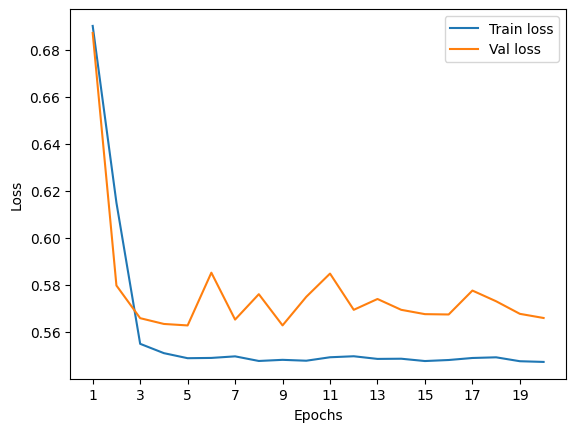

In [77]:
plot_loss(history)

In [ ]:
plot_auc(model, test_dataloader)

### QGAT with quantum classifier (MPS)

#### Leaky ReLU

#### Learning rate = 1e-2, classical attention

In [65]:
model = QGAT(input_dims, depth=q_depth, n_layers=2)
model

QGAT(
  (layers): ModuleList(
    (0-1): 2 x QGATConv()
  )
  (activ_fn): LeakyReLU(negative_slope=0.2)
  (classifier): <Quantum Torch Layer: func=quantum_circuit>
  (readout): Linear(in_features=1, out_features=1, bias=True)
)

In [66]:
optimizer = Adam(model.parameters(), 1e-2)
lossFn = BCEWithLogitsLoss()
history, best_model = train_model(model, optimizer, lossFn, epochs, lr, train_dataloader, val_dataloader)

118it [02:24,  1.22s/it]


Train Epoch: 0 	Loss: 0.706133, Accuracy: 4388/7500 (59%)
Val Epoch: 0 	Loss: 0.684059, Accuracy: 1854/2500 (74%)



118it [02:12,  1.13s/it]


Train Epoch: 1 	Loss: 0.650728, Accuracy: 5492/7500 (73%)
Val Epoch: 1 	Loss: 0.639503, Accuracy: 1835/2500 (73%)



118it [01:57,  1.00it/s]


Train Epoch: 2 	Loss: 0.604274, Accuracy: 5628/7500 (75%)
Val Epoch: 2 	Loss: 0.593460, Accuracy: 1907/2500 (76%)



118it [01:56,  1.01it/s]


Train Epoch: 3 	Loss: 0.571879, Accuracy: 5659/7500 (75%)
Val Epoch: 3 	Loss: 0.563494, Accuracy: 1887/2500 (75%)



118it [01:53,  1.04it/s]


Train Epoch: 4 	Loss: 0.549178, Accuracy: 5682/7500 (76%)
Val Epoch: 4 	Loss: 0.566522, Accuracy: 1811/2500 (72%)



118it [01:46,  1.11it/s]


Train Epoch: 5 	Loss: 0.537833, Accuracy: 5707/7500 (76%)
Val Epoch: 5 	Loss: 0.537069, Accuracy: 1936/2500 (77%)



118it [01:41,  1.16it/s]


Train Epoch: 6 	Loss: 0.526351, Accuracy: 5710/7500 (76%)
Val Epoch: 6 	Loss: 0.527252, Accuracy: 1885/2500 (75%)



118it [01:44,  1.13it/s]


Train Epoch: 7 	Loss: 0.518946, Accuracy: 5708/7500 (76%)
Val Epoch: 7 	Loss: 0.517876, Accuracy: 1910/2500 (76%)



118it [01:46,  1.11it/s]


Train Epoch: 8 	Loss: 0.512341, Accuracy: 5720/7500 (76%)
Val Epoch: 8 	Loss: 0.517217, Accuracy: 1886/2500 (75%)



118it [01:39,  1.19it/s]


Train Epoch: 9 	Loss: 0.510910, Accuracy: 5688/7500 (76%)
Val Epoch: 9 	Loss: 0.504646, Accuracy: 1906/2500 (76%)



118it [01:36,  1.23it/s]


Train Epoch: 10 	Loss: 0.509071, Accuracy: 5731/7500 (76%)
Val Epoch: 10 	Loss: 0.508335, Accuracy: 1913/2500 (77%)



118it [01:42,  1.16it/s]


Train Epoch: 11 	Loss: 0.507410, Accuracy: 5757/7500 (77%)
Val Epoch: 11 	Loss: 0.526653, Accuracy: 1930/2500 (77%)



118it [02:40,  1.36s/it]


Train Epoch: 12 	Loss: 0.507193, Accuracy: 5725/7500 (76%)
Val Epoch: 12 	Loss: 0.502430, Accuracy: 1925/2500 (77%)



118it [01:24,  1.40it/s]


Train Epoch: 13 	Loss: 0.506078, Accuracy: 5702/7500 (76%)
Val Epoch: 13 	Loss: 0.503152, Accuracy: 1894/2500 (76%)



118it [01:22,  1.43it/s]


Train Epoch: 14 	Loss: 0.502977, Accuracy: 5704/7500 (76%)
Val Epoch: 14 	Loss: 0.502716, Accuracy: 1938/2500 (78%)



118it [01:29,  1.32it/s]


Train Epoch: 15 	Loss: 0.504458, Accuracy: 5683/7500 (76%)
Val Epoch: 15 	Loss: 0.498492, Accuracy: 1937/2500 (77%)



118it [01:40,  1.18it/s]


Train Epoch: 16 	Loss: 0.502890, Accuracy: 5706/7500 (76%)
Val Epoch: 16 	Loss: 0.504470, Accuracy: 1924/2500 (77%)



118it [01:48,  1.08it/s]


Train Epoch: 17 	Loss: 0.504377, Accuracy: 5738/7500 (77%)
Val Epoch: 17 	Loss: 0.500849, Accuracy: 1905/2500 (76%)



118it [01:37,  1.21it/s]


Train Epoch: 18 	Loss: 0.502369, Accuracy: 5690/7500 (76%)
Val Epoch: 18 	Loss: 0.501103, Accuracy: 1934/2500 (77%)



118it [01:44,  1.13it/s]


Train Epoch: 19 	Loss: 0.503506, Accuracy: 5736/7500 (76%)
Val Epoch: 19 	Loss: 0.494049, Accuracy: 1922/2500 (77%)



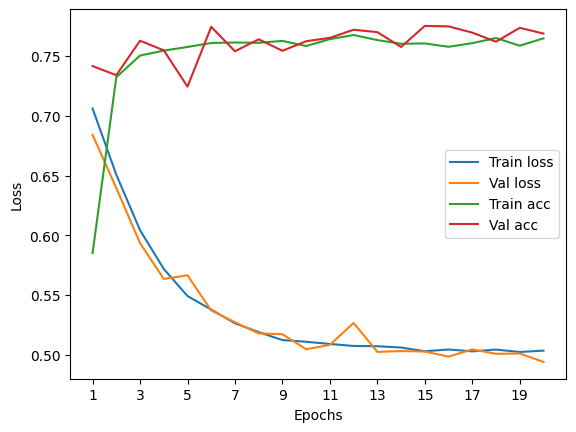

In [67]:
plot_loss(history)

Test accuracy:  76.36


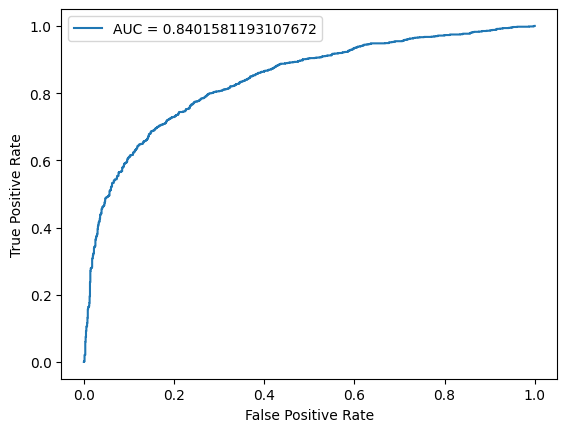

In [68]:
plot_auc(best_model, test_dataloader)

### QGCN with quantum classifier (MPS)

#### Leaky ReLU

#### Learning rate = 1e-2

#### With 3 particles, edge_weights, (total particles, photon, charged hadron, neutral hadron, net positive charge of jet) count

In [123]:
model = QGCN(input_dims, output_dims, classifier = "MPS", readout = True)
model

QGCN(
  (layers): ModuleList(
    (0): QGCNConv()
  )
  (activ_fn): LeakyReLU(negative_slope=0.2)
  (readout): Linear(in_features=1, out_features=1, bias=True)
  (classifier): <Quantum Torch Layer: func=quantum_circuit>
)

In [124]:
optimizer = Adam(model.parameters(), 1e-2)
lossFn = BCEWithLogitsLoss()
history, best_model = train_model(model, optimizer, lossFn, epochs, lr, train_dataloader, val_dataloader)

118it [02:21,  1.20s/it]


Train Epoch: 0 	Loss: 0.702171, Accuracy: 3834/7500 (51%)
Val Epoch: 0 	Loss: 0.708694, Accuracy: 1281/2500 (51%)



118it [02:23,  1.21s/it]


Train Epoch: 1 	Loss: 0.668724, Accuracy: 4922/7500 (66%)
Val Epoch: 1 	Loss: 0.638702, Accuracy: 1818/2500 (73%)



118it [02:22,  1.20s/it]


Train Epoch: 2 	Loss: 0.597284, Accuracy: 5537/7500 (74%)
Val Epoch: 2 	Loss: 0.584908, Accuracy: 1867/2500 (75%)



118it [01:04,  1.83it/s]


Train Epoch: 3 	Loss: 0.554188, Accuracy: 5648/7500 (75%)
Val Epoch: 3 	Loss: 0.549518, Accuracy: 1874/2500 (75%)



118it [00:59,  1.97it/s]


Train Epoch: 4 	Loss: 0.533610, Accuracy: 5693/7500 (76%)
Val Epoch: 4 	Loss: 0.532124, Accuracy: 1879/2500 (75%)



118it [01:17,  1.51it/s]


Train Epoch: 5 	Loss: 0.521222, Accuracy: 5676/7500 (76%)
Val Epoch: 5 	Loss: 0.545356, Accuracy: 1889/2500 (76%)



118it [01:08,  1.73it/s]


Train Epoch: 6 	Loss: 0.516357, Accuracy: 5722/7500 (76%)
Val Epoch: 6 	Loss: 0.532662, Accuracy: 1893/2500 (76%)



118it [01:13,  1.62it/s]


Train Epoch: 7 	Loss: 0.509006, Accuracy: 5727/7500 (76%)
Val Epoch: 7 	Loss: 0.538767, Accuracy: 1871/2500 (75%)



118it [02:16,  1.15s/it]


Train Epoch: 8 	Loss: 0.507487, Accuracy: 5694/7500 (76%)
Val Epoch: 8 	Loss: 0.518826, Accuracy: 1868/2500 (75%)



118it [02:02,  1.04s/it]


Train Epoch: 9 	Loss: 0.508226, Accuracy: 5744/7500 (77%)
Val Epoch: 9 	Loss: 0.518061, Accuracy: 1881/2500 (75%)



118it [02:00,  1.02s/it]


Train Epoch: 10 	Loss: 0.505449, Accuracy: 5733/7500 (76%)
Val Epoch: 10 	Loss: 0.526189, Accuracy: 1890/2500 (76%)



118it [02:06,  1.07s/it]


Train Epoch: 11 	Loss: 0.505269, Accuracy: 5703/7500 (76%)
Val Epoch: 11 	Loss: 0.525437, Accuracy: 1889/2500 (76%)



118it [02:03,  1.04s/it]


Train Epoch: 12 	Loss: 0.506293, Accuracy: 5715/7500 (76%)
Val Epoch: 12 	Loss: 0.527918, Accuracy: 1895/2500 (76%)



118it [02:05,  1.06s/it]


Train Epoch: 13 	Loss: 0.502358, Accuracy: 5739/7500 (77%)
Val Epoch: 13 	Loss: 0.524065, Accuracy: 1878/2500 (75%)



118it [02:04,  1.05s/it]


Train Epoch: 14 	Loss: 0.505385, Accuracy: 5723/7500 (76%)
Val Epoch: 14 	Loss: 0.515140, Accuracy: 1887/2500 (75%)



118it [02:06,  1.07s/it]


Train Epoch: 15 	Loss: 0.505746, Accuracy: 5694/7500 (76%)
Val Epoch: 15 	Loss: 0.544267, Accuracy: 1894/2500 (76%)



118it [02:01,  1.03s/it]


Train Epoch: 16 	Loss: 0.507232, Accuracy: 5722/7500 (76%)
Val Epoch: 16 	Loss: 0.514630, Accuracy: 1892/2500 (76%)



118it [02:05,  1.06s/it]


Train Epoch: 17 	Loss: 0.504135, Accuracy: 5731/7500 (76%)
Val Epoch: 17 	Loss: 0.520833, Accuracy: 1893/2500 (76%)



118it [02:00,  1.02s/it]


Train Epoch: 18 	Loss: 0.501665, Accuracy: 5728/7500 (76%)
Val Epoch: 18 	Loss: 0.526273, Accuracy: 1902/2500 (76%)



118it [02:13,  1.13s/it]


Train Epoch: 19 	Loss: 0.502069, Accuracy: 5743/7500 (77%)
Val Epoch: 19 	Loss: 0.519759, Accuracy: 1887/2500 (75%)



118it [02:00,  1.02s/it]


Train Epoch: 20 	Loss: 0.504999, Accuracy: 5728/7500 (76%)
Val Epoch: 20 	Loss: 0.511722, Accuracy: 1892/2500 (76%)



118it [01:59,  1.01s/it]


Train Epoch: 21 	Loss: 0.503339, Accuracy: 5721/7500 (76%)
Val Epoch: 21 	Loss: 0.515657, Accuracy: 1900/2500 (76%)



118it [02:00,  1.02s/it]


Train Epoch: 22 	Loss: 0.504052, Accuracy: 5702/7500 (76%)
Val Epoch: 22 	Loss: 0.514669, Accuracy: 1896/2500 (76%)



118it [01:59,  1.01s/it]


Train Epoch: 23 	Loss: 0.501318, Accuracy: 5724/7500 (76%)
Val Epoch: 23 	Loss: 0.530095, Accuracy: 1902/2500 (76%)



118it [01:57,  1.00it/s]


Train Epoch: 24 	Loss: 0.503260, Accuracy: 5704/7500 (76%)
Val Epoch: 24 	Loss: 0.510761, Accuracy: 1885/2500 (75%)



118it [01:59,  1.02s/it]


Train Epoch: 25 	Loss: 0.503970, Accuracy: 5739/7500 (77%)
Val Epoch: 25 	Loss: 0.520267, Accuracy: 1903/2500 (76%)



118it [01:57,  1.01it/s]


Train Epoch: 26 	Loss: 0.501646, Accuracy: 5733/7500 (76%)
Val Epoch: 26 	Loss: 0.513297, Accuracy: 1897/2500 (76%)



118it [01:59,  1.01s/it]


Train Epoch: 27 	Loss: 0.500610, Accuracy: 5739/7500 (77%)
Val Epoch: 27 	Loss: 0.512990, Accuracy: 1896/2500 (76%)



118it [01:58,  1.01s/it]


Train Epoch: 28 	Loss: 0.501879, Accuracy: 5741/7500 (77%)
Val Epoch: 28 	Loss: 0.522759, Accuracy: 1876/2500 (75%)



118it [02:16,  1.15s/it]


Train Epoch: 29 	Loss: 0.500087, Accuracy: 5732/7500 (76%)
Val Epoch: 29 	Loss: 0.513495, Accuracy: 1906/2500 (76%)



118it [02:00,  1.02s/it]


Train Epoch: 30 	Loss: 0.498848, Accuracy: 5748/7500 (77%)
Val Epoch: 30 	Loss: 0.516174, Accuracy: 1911/2500 (76%)



118it [01:56,  1.01it/s]


Train Epoch: 31 	Loss: 0.500228, Accuracy: 5735/7500 (76%)
Val Epoch: 31 	Loss: 0.510145, Accuracy: 1892/2500 (76%)



118it [02:01,  1.03s/it]


Train Epoch: 32 	Loss: 0.501942, Accuracy: 5717/7500 (76%)
Val Epoch: 32 	Loss: 0.515354, Accuracy: 1889/2500 (76%)



118it [02:00,  1.02s/it]


Train Epoch: 33 	Loss: 0.500899, Accuracy: 5718/7500 (76%)
Val Epoch: 33 	Loss: 0.516715, Accuracy: 1891/2500 (76%)



118it [02:25,  1.24s/it]


Train Epoch: 34 	Loss: 0.501299, Accuracy: 5721/7500 (76%)
Val Epoch: 34 	Loss: 0.509261, Accuracy: 1901/2500 (76%)



118it [02:08,  1.09s/it]


Train Epoch: 35 	Loss: 0.498762, Accuracy: 5743/7500 (77%)
Val Epoch: 35 	Loss: 0.512237, Accuracy: 1900/2500 (76%)



118it [02:14,  1.14s/it]


Train Epoch: 36 	Loss: 0.498713, Accuracy: 5740/7500 (77%)
Val Epoch: 36 	Loss: 0.509390, Accuracy: 1892/2500 (76%)



118it [02:07,  1.08s/it]


Train Epoch: 37 	Loss: 0.497977, Accuracy: 5747/7500 (77%)
Val Epoch: 37 	Loss: 0.516016, Accuracy: 1896/2500 (76%)



118it [01:34,  1.25it/s]


Train Epoch: 38 	Loss: 0.498285, Accuracy: 5752/7500 (77%)
Val Epoch: 38 	Loss: 0.526506, Accuracy: 1906/2500 (76%)



118it [02:22,  1.21s/it]


Train Epoch: 39 	Loss: 0.500854, Accuracy: 5743/7500 (77%)
Val Epoch: 39 	Loss: 0.506002, Accuracy: 1900/2500 (76%)



118it [01:19,  1.49it/s]


Train Epoch: 40 	Loss: 0.498882, Accuracy: 5757/7500 (77%)
Val Epoch: 40 	Loss: 0.509281, Accuracy: 1904/2500 (76%)



118it [01:13,  1.61it/s]


Train Epoch: 41 	Loss: 0.501197, Accuracy: 5750/7500 (77%)
Val Epoch: 41 	Loss: 0.515892, Accuracy: 1912/2500 (76%)



118it [01:14,  1.59it/s]


Train Epoch: 42 	Loss: 0.499843, Accuracy: 5751/7500 (77%)
Val Epoch: 42 	Loss: 0.509340, Accuracy: 1915/2500 (77%)



118it [01:17,  1.53it/s]


Train Epoch: 43 	Loss: 0.499730, Accuracy: 5747/7500 (77%)
Val Epoch: 43 	Loss: 0.526510, Accuracy: 1888/2500 (76%)



118it [01:18,  1.49it/s]


Train Epoch: 44 	Loss: 0.500930, Accuracy: 5720/7500 (76%)
Val Epoch: 44 	Loss: 0.504835, Accuracy: 1897/2500 (76%)



118it [01:23,  1.42it/s]


Train Epoch: 45 	Loss: 0.499350, Accuracy: 5765/7500 (77%)
Val Epoch: 45 	Loss: 0.516078, Accuracy: 1903/2500 (76%)



118it [01:15,  1.57it/s]


Train Epoch: 46 	Loss: 0.498670, Accuracy: 5736/7500 (76%)
Val Epoch: 46 	Loss: 0.514832, Accuracy: 1902/2500 (76%)



118it [01:15,  1.56it/s]


Train Epoch: 47 	Loss: 0.500563, Accuracy: 5717/7500 (76%)
Val Epoch: 47 	Loss: 0.521871, Accuracy: 1897/2500 (76%)



118it [01:14,  1.58it/s]


Train Epoch: 48 	Loss: 0.497184, Accuracy: 5771/7500 (77%)
Val Epoch: 48 	Loss: 0.519917, Accuracy: 1898/2500 (76%)



118it [01:14,  1.59it/s]


Train Epoch: 49 	Loss: 0.497321, Accuracy: 5761/7500 (77%)
Val Epoch: 49 	Loss: 0.503332, Accuracy: 1895/2500 (76%)



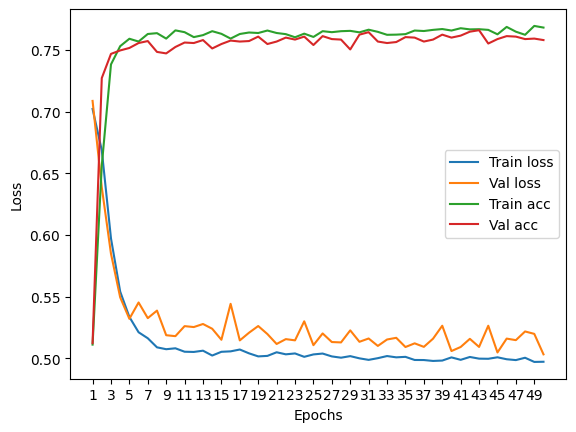

In [126]:
plot_loss(history)

Test accuracy:  78.36


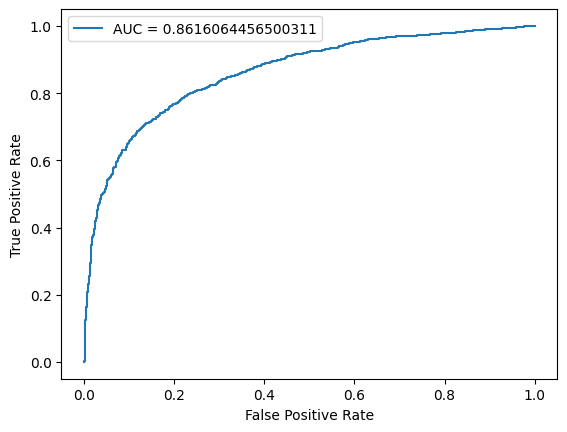

In [127]:
plot_auc(best_model, test_dataloader)

#### q_depth = 5, batch size = 1024

In [45]:
q_depth = 5

In [46]:
model = QGCN(input_dims, output_dims, classifier = "MPS", readout = True)
model

QGCN(
  (layers): ModuleList(
    (0): QGCNConv()
  )
  (activ_fn): LeakyReLU(negative_slope=0.2)
  (readout): Linear(in_features=1, out_features=1, bias=True)
  (classifier): <Quantum Torch Layer: func=quantum_circuit>
)

In [47]:
optimizer = Adam(model.parameters(), 1e-2)
lossFn = BCEWithLogitsLoss()
history = train_model(model, optimizer, lossFn, epochs, lr, train_dataloader, val_dataloader)

59it [02:34,  2.63s/it]


Train Epoch: 0 	Loss: 0.697131, Accuracy: 31809/59922 (53%)
Val Epoch: 0 	Loss: 0.706608, Accuracy: 11106/19974 (56%)



59it [02:29,  2.53s/it]


Train Epoch: 1 	Loss: 0.693278, Accuracy: 35120/59922 (59%)
Val Epoch: 1 	Loss: 0.702678, Accuracy: 14241/19974 (71%)



59it [02:29,  2.53s/it]


Train Epoch: 2 	Loss: 0.689647, Accuracy: 37045/59922 (62%)
Val Epoch: 2 	Loss: 0.698665, Accuracy: 13781/19974 (69%)



59it [02:33,  2.60s/it]


Train Epoch: 3 	Loss: 0.684988, Accuracy: 38744/59922 (65%)
Val Epoch: 3 	Loss: 0.692188, Accuracy: 13951/19974 (70%)



59it [02:24,  2.45s/it]


Train Epoch: 4 	Loss: 0.674737, Accuracy: 40501/59922 (68%)
Val Epoch: 4 	Loss: 0.675497, Accuracy: 14476/19974 (72%)



59it [02:24,  2.44s/it]


Train Epoch: 5 	Loss: 0.656433, Accuracy: 42058/59922 (70%)
Val Epoch: 5 	Loss: 0.659936, Accuracy: 13904/19974 (70%)



59it [04:18,  4.38s/it]


Train Epoch: 6 	Loss: 0.643230, Accuracy: 42706/59922 (71%)
Val Epoch: 6 	Loss: 0.648823, Accuracy: 13774/19974 (69%)



59it [01:48,  1.84s/it]


Train Epoch: 7 	Loss: 0.632751, Accuracy: 42923/59922 (72%)
Val Epoch: 7 	Loss: 0.637451, Accuracy: 14441/19974 (72%)



59it [01:59,  2.03s/it]


Train Epoch: 8 	Loss: 0.623706, Accuracy: 43159/59922 (72%)
Val Epoch: 8 	Loss: 0.627738, Accuracy: 14599/19974 (73%)



59it [02:11,  2.24s/it]


Train Epoch: 9 	Loss: 0.615743, Accuracy: 43429/59922 (72%)
Val Epoch: 9 	Loss: 0.622697, Accuracy: 14385/19974 (72%)



59it [02:20,  2.38s/it]


Train Epoch: 10 	Loss: 0.609461, Accuracy: 43233/59922 (72%)
Val Epoch: 10 	Loss: 0.618091, Accuracy: 14325/19974 (72%)



59it [02:17,  2.34s/it]


Train Epoch: 11 	Loss: 0.602893, Accuracy: 43366/59922 (72%)
Val Epoch: 11 	Loss: 0.607289, Accuracy: 14595/19974 (73%)



59it [02:18,  2.34s/it]


Train Epoch: 12 	Loss: 0.595967, Accuracy: 43673/59922 (73%)
Val Epoch: 12 	Loss: 0.600831, Accuracy: 14612/19974 (73%)



59it [02:20,  2.39s/it]


Train Epoch: 13 	Loss: 0.594891, Accuracy: 43041/59922 (72%)
Val Epoch: 13 	Loss: 0.600002, Accuracy: 14454/19974 (72%)



59it [02:23,  2.43s/it]


Train Epoch: 14 	Loss: 0.588298, Accuracy: 43397/59922 (72%)
Val Epoch: 14 	Loss: 0.594845, Accuracy: 14450/19974 (72%)



59it [02:20,  2.38s/it]


Train Epoch: 15 	Loss: 0.583367, Accuracy: 43524/59922 (73%)
Val Epoch: 15 	Loss: 0.587489, Accuracy: 14573/19974 (73%)



59it [02:20,  2.39s/it]


Train Epoch: 16 	Loss: 0.579289, Accuracy: 43529/59922 (73%)
Val Epoch: 16 	Loss: 0.583829, Accuracy: 14625/19974 (73%)



59it [02:25,  2.46s/it]


Train Epoch: 17 	Loss: 0.575848, Accuracy: 43553/59922 (73%)
Val Epoch: 17 	Loss: 0.584879, Accuracy: 14418/19974 (72%)



59it [03:04,  3.13s/it]


Train Epoch: 18 	Loss: 0.574023, Accuracy: 43530/59922 (73%)
Val Epoch: 18 	Loss: 0.581761, Accuracy: 14416/19974 (72%)



59it [03:10,  3.23s/it]


Train Epoch: 19 	Loss: 0.571040, Accuracy: 43572/59922 (73%)
Val Epoch: 19 	Loss: 0.588432, Accuracy: 14225/19974 (71%)



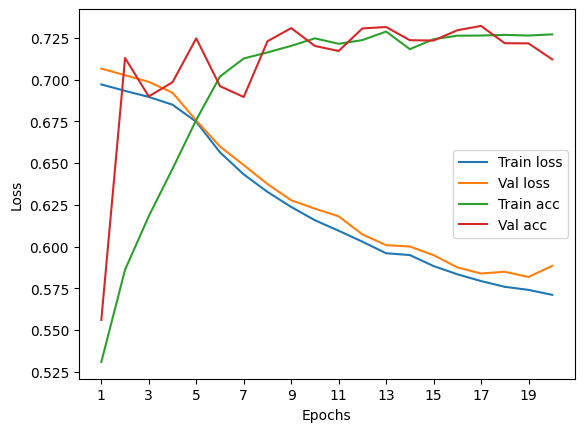

In [48]:
plot_loss(history)

In [49]:
history2 = train_model(model, optimizer, lossFn, epochs, lr, train_dataloader, val_dataloader)

59it [02:48,  2.86s/it]


Train Epoch: 0 	Loss: 0.568425, Accuracy: 43594/59922 (73%)
Val Epoch: 0 	Loss: 0.572174, Accuracy: 14611/19974 (73%)



59it [03:10,  3.22s/it]


Train Epoch: 1 	Loss: 0.566269, Accuracy: 43605/59922 (73%)
Val Epoch: 1 	Loss: 0.570349, Accuracy: 14625/19974 (73%)



59it [02:29,  2.54s/it]


Train Epoch: 2 	Loss: 0.565028, Accuracy: 43487/59922 (73%)
Val Epoch: 2 	Loss: 0.568864, Accuracy: 14624/19974 (73%)



59it [02:37,  2.67s/it]


Train Epoch: 3 	Loss: 0.561505, Accuracy: 43698/59922 (73%)
Val Epoch: 3 	Loss: 0.568758, Accuracy: 14583/19974 (73%)



59it [02:34,  2.61s/it]


Train Epoch: 4 	Loss: 0.561955, Accuracy: 43626/59922 (73%)
Val Epoch: 4 	Loss: 0.565235, Accuracy: 14599/19974 (73%)



59it [02:34,  2.63s/it]


Train Epoch: 5 	Loss: 0.558951, Accuracy: 43750/59922 (73%)
Val Epoch: 5 	Loss: 0.564754, Accuracy: 14612/19974 (73%)



59it [02:15,  2.30s/it]


Train Epoch: 6 	Loss: 0.560477, Accuracy: 43605/59922 (73%)
Val Epoch: 6 	Loss: 0.562188, Accuracy: 14622/19974 (73%)



59it [02:32,  2.59s/it]


Train Epoch: 7 	Loss: 0.557558, Accuracy: 43689/59922 (73%)
Val Epoch: 7 	Loss: 0.560613, Accuracy: 14626/19974 (73%)



59it [02:44,  2.79s/it]


Train Epoch: 8 	Loss: 0.558395, Accuracy: 43574/59922 (73%)
Val Epoch: 8 	Loss: 0.559722, Accuracy: 14615/19974 (73%)



59it [02:49,  2.87s/it]


Train Epoch: 9 	Loss: 0.557601, Accuracy: 43623/59922 (73%)
Val Epoch: 9 	Loss: 0.562673, Accuracy: 14627/19974 (73%)



59it [02:39,  2.70s/it]


Train Epoch: 10 	Loss: 0.554769, Accuracy: 43738/59922 (73%)
Val Epoch: 10 	Loss: 0.558111, Accuracy: 14656/19974 (73%)



59it [02:57,  3.02s/it]


Train Epoch: 11 	Loss: 0.553684, Accuracy: 43766/59922 (73%)
Val Epoch: 11 	Loss: 0.557187, Accuracy: 14655/19974 (73%)



59it [03:03,  3.12s/it]


Train Epoch: 12 	Loss: 0.552961, Accuracy: 43849/59922 (73%)
Val Epoch: 12 	Loss: 0.556950, Accuracy: 14633/19974 (73%)



59it [03:08,  3.20s/it]


Train Epoch: 13 	Loss: 0.553426, Accuracy: 43696/59922 (73%)
Val Epoch: 13 	Loss: 0.557804, Accuracy: 14598/19974 (73%)



59it [03:00,  3.07s/it]


Train Epoch: 14 	Loss: 0.552125, Accuracy: 43748/59922 (73%)
Val Epoch: 14 	Loss: 0.556450, Accuracy: 14613/19974 (73%)



59it [02:55,  2.98s/it]


Train Epoch: 15 	Loss: 0.551874, Accuracy: 43754/59922 (73%)
Val Epoch: 15 	Loss: 0.558786, Accuracy: 14604/19974 (73%)



59it [02:52,  2.92s/it]


Train Epoch: 16 	Loss: 0.552192, Accuracy: 43729/59922 (73%)
Val Epoch: 16 	Loss: 0.558032, Accuracy: 14564/19974 (73%)



59it [02:52,  2.93s/it]


Train Epoch: 17 	Loss: 0.552336, Accuracy: 43741/59922 (73%)
Val Epoch: 17 	Loss: 0.554618, Accuracy: 14628/19974 (73%)



59it [02:52,  2.93s/it]


Train Epoch: 18 	Loss: 0.552287, Accuracy: 43652/59922 (73%)
Val Epoch: 18 	Loss: 0.571138, Accuracy: 14413/19974 (72%)



59it [03:04,  3.13s/it]


Train Epoch: 19 	Loss: 0.550583, Accuracy: 43780/59922 (73%)
Val Epoch: 19 	Loss: 0.554443, Accuracy: 14646/19974 (73%)



In [63]:
a = dict()
for key in history.keys():
    a[key] = history[key] + history2[key]
len(a["train_loss"]), len(history["train_loss"])

(44, 22)

#### With classical readout (1 node NN layer)

#### Batch size = 256

In [92]:
model = QGCN(input_dims, output_dims, classifier = "MPS", readout = True)
model

QGCN(
  (layers): ModuleList(
    (0): QGCNConv()
  )
  (activ_fn): LeakyReLU(negative_slope=0.2)
  (readout): Linear(in_features=1, out_features=1, bias=True)
  (classifier): <Quantum Torch Layer: func=quantum_circuit>
)

In [93]:
optimizer = Adam(model.parameters(), 1e-2)
lossFn = BCEWithLogitsLoss()
history = train_model(model, optimizer, lossFn, epochs, lr, train_dataloader, val_dataloader)

313it [01:34,  3.33it/s]


Train Epoch: 0 	Loss: 0.692894, Accuracy: 41702/79896 (52%)
Val Epoch: 0 	Loss: 0.685161, Accuracy: 6734/9987 (67%)



313it [01:39,  3.15it/s]


Train Epoch: 1 	Loss: 0.627278, Accuracy: 55511/79896 (69%)
Val Epoch: 1 	Loss: 0.602105, Accuracy: 7176/9987 (72%)



313it [01:43,  3.03it/s]


Train Epoch: 2 	Loss: 0.577162, Accuracy: 57597/79896 (72%)
Val Epoch: 2 	Loss: 0.576855, Accuracy: 7348/9987 (74%)



313it [01:49,  2.85it/s]


Train Epoch: 3 	Loss: 0.559508, Accuracy: 57936/79896 (73%)
Val Epoch: 3 	Loss: 0.567254, Accuracy: 7289/9987 (73%)



313it [01:55,  2.71it/s]


Train Epoch: 4 	Loss: 0.553671, Accuracy: 57971/79896 (73%)
Val Epoch: 4 	Loss: 0.562518, Accuracy: 7239/9987 (72%)



313it [01:49,  2.87it/s]


Train Epoch: 5 	Loss: 0.550818, Accuracy: 58132/79896 (73%)
Val Epoch: 5 	Loss: 0.549491, Accuracy: 7299/9987 (73%)



313it [01:37,  3.21it/s]


Train Epoch: 6 	Loss: 0.551838, Accuracy: 58090/79896 (73%)
Val Epoch: 6 	Loss: 0.545362, Accuracy: 7306/9987 (73%)



313it [01:31,  3.41it/s]


Train Epoch: 7 	Loss: 0.550924, Accuracy: 58059/79896 (73%)
Val Epoch: 7 	Loss: 0.547601, Accuracy: 7315/9987 (73%)



313it [01:31,  3.40it/s]


Train Epoch: 8 	Loss: 0.549134, Accuracy: 58195/79896 (73%)
Val Epoch: 8 	Loss: 0.587775, Accuracy: 7108/9987 (71%)



313it [01:31,  3.43it/s]


Train Epoch: 9 	Loss: 0.551176, Accuracy: 58032/79896 (73%)
Val Epoch: 9 	Loss: 0.547953, Accuracy: 7357/9987 (74%)



313it [01:29,  3.49it/s]


Train Epoch: 10 	Loss: 0.550786, Accuracy: 58028/79896 (73%)
Val Epoch: 10 	Loss: 0.579704, Accuracy: 7281/9987 (73%)



313it [01:59,  2.61it/s]


Train Epoch: 11 	Loss: 0.550640, Accuracy: 58064/79896 (73%)
Val Epoch: 11 	Loss: 0.549506, Accuracy: 7367/9987 (74%)



313it [01:56,  2.69it/s]


Train Epoch: 12 	Loss: 0.549292, Accuracy: 58136/79896 (73%)
Val Epoch: 12 	Loss: 0.557750, Accuracy: 7288/9987 (73%)



313it [02:02,  2.55it/s]


Train Epoch: 13 	Loss: 0.549417, Accuracy: 58138/79896 (73%)
Val Epoch: 13 	Loss: 0.546394, Accuracy: 7338/9987 (73%)



313it [01:35,  3.28it/s]


Train Epoch: 14 	Loss: 0.548446, Accuracy: 58262/79896 (73%)
Val Epoch: 14 	Loss: 0.553274, Accuracy: 7384/9987 (74%)



313it [01:47,  2.90it/s]


Train Epoch: 15 	Loss: 0.548337, Accuracy: 58224/79896 (73%)
Val Epoch: 15 	Loss: 0.553750, Accuracy: 7323/9987 (73%)



313it [02:01,  2.58it/s]


Train Epoch: 16 	Loss: 0.550014, Accuracy: 58178/79896 (73%)
Val Epoch: 16 	Loss: 0.552275, Accuracy: 7287/9987 (73%)



313it [01:56,  2.68it/s]


Train Epoch: 17 	Loss: 0.547561, Accuracy: 58333/79896 (73%)
Val Epoch: 17 	Loss: 0.546264, Accuracy: 7388/9987 (74%)



313it [02:04,  2.52it/s]


Train Epoch: 18 	Loss: 0.547830, Accuracy: 58317/79896 (73%)
Val Epoch: 18 	Loss: 0.555675, Accuracy: 7282/9987 (73%)



313it [01:40,  3.11it/s]


Train Epoch: 19 	Loss: 0.548044, Accuracy: 58216/79896 (73%)
Val Epoch: 19 	Loss: 0.552980, Accuracy: 7390/9987 (74%)



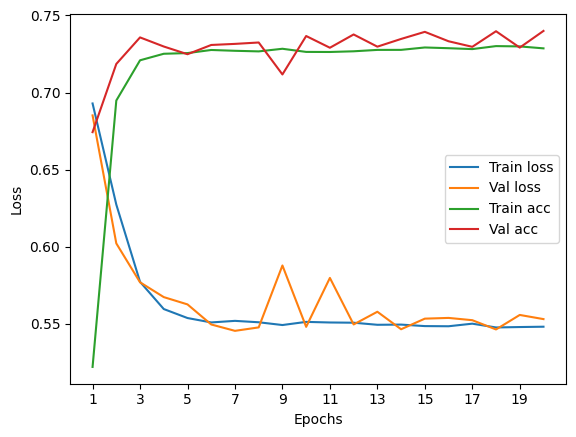

In [94]:
plot_loss(history)

Test accuracy:  72.36407329528387


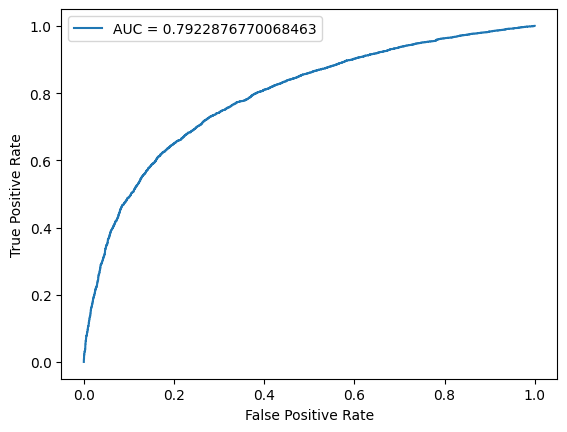

In [95]:
plot_auc(model, test_dataloader)

### QGCN with quantum classifier (TTN)

#### Leaky ReLU

#### Learning rate = 1e-2

#### With classical readout (1 node NN layer)

In [88]:
model = QGCN(input_dims, output_dims, classifier = "TTN", readout = True)
model

QGCN(
  (layers): ModuleList(
    (0): QGCNConv()
  )
  (activ_fn): LeakyReLU(negative_slope=0.2)
  (readout): Linear(in_features=1, out_features=1, bias=True)
  (classifier): <Quantum Torch Layer: func=quantum_circuit>
)

In [86]:
[p.numel() for p in model.parameters()]

[8, 16, 1, 1, 15]

In [108]:
optimizer = Adam(model.parameters(), 1e-2)
lossFn = BCEWithLogitsLoss()
history = train_model(model, optimizer, lossFn, epochs, lr, train_dataloader, val_dataloader)

313it [01:31,  3.43it/s]


Train Epoch: 0 	Loss: 0.681000, Accuracy: 48501/79896 (61%)
Val Epoch: 0 	Loss: 0.672508, Accuracy: 6922/9987 (69%)



313it [01:29,  3.48it/s]


Train Epoch: 1 	Loss: 0.636306, Accuracy: 56272/79896 (70%)
Val Epoch: 1 	Loss: 0.627609, Accuracy: 7215/9987 (72%)



313it [01:42,  3.04it/s]


Train Epoch: 2 	Loss: 0.602632, Accuracy: 57383/79896 (72%)
Val Epoch: 2 	Loss: 0.611829, Accuracy: 7151/9987 (72%)



313it [01:51,  2.81it/s]


Train Epoch: 3 	Loss: 0.580859, Accuracy: 57706/79896 (72%)
Val Epoch: 3 	Loss: 0.591779, Accuracy: 7158/9987 (72%)



313it [01:42,  3.06it/s]


Train Epoch: 4 	Loss: 0.567206, Accuracy: 57925/79896 (73%)
Val Epoch: 4 	Loss: 0.587606, Accuracy: 7061/9987 (71%)



313it [01:51,  2.81it/s]


Train Epoch: 5 	Loss: 0.562071, Accuracy: 57820/79896 (72%)
Val Epoch: 5 	Loss: 0.584432, Accuracy: 7104/9987 (71%)



313it [02:04,  2.52it/s]


Train Epoch: 6 	Loss: 0.558320, Accuracy: 57718/79896 (72%)
Val Epoch: 6 	Loss: 0.569604, Accuracy: 7195/9987 (72%)



313it [01:48,  2.89it/s]


Train Epoch: 7 	Loss: 0.553123, Accuracy: 58064/79896 (73%)
Val Epoch: 7 	Loss: 0.591374, Accuracy: 7060/9987 (71%)



313it [01:54,  2.75it/s]


Train Epoch: 8 	Loss: 0.554289, Accuracy: 57863/79896 (72%)
Val Epoch: 8 	Loss: 0.608931, Accuracy: 6866/9987 (69%)



313it [01:53,  2.76it/s]


Train Epoch: 9 	Loss: 0.552773, Accuracy: 57965/79896 (73%)
Val Epoch: 9 	Loss: 0.581031, Accuracy: 7068/9987 (71%)



313it [01:57,  2.66it/s]


Train Epoch: 10 	Loss: 0.550186, Accuracy: 58154/79896 (73%)
Val Epoch: 10 	Loss: 0.588283, Accuracy: 7169/9987 (72%)



313it [02:02,  2.56it/s]


Train Epoch: 11 	Loss: 0.551110, Accuracy: 58049/79896 (73%)
Val Epoch: 11 	Loss: 0.578840, Accuracy: 7152/9987 (72%)



313it [02:02,  2.55it/s]


Train Epoch: 12 	Loss: 0.550900, Accuracy: 58059/79896 (73%)
Val Epoch: 12 	Loss: 0.569618, Accuracy: 7169/9987 (72%)



313it [02:02,  2.56it/s]


Train Epoch: 13 	Loss: 0.549998, Accuracy: 58154/79896 (73%)
Val Epoch: 13 	Loss: 0.556895, Accuracy: 7245/9987 (73%)



313it [01:43,  3.01it/s]


Train Epoch: 14 	Loss: 0.550479, Accuracy: 57981/79896 (73%)
Val Epoch: 14 	Loss: 0.578339, Accuracy: 7232/9987 (72%)



313it [01:59,  2.63it/s]


Train Epoch: 15 	Loss: 0.550932, Accuracy: 58193/79896 (73%)
Val Epoch: 15 	Loss: 0.567073, Accuracy: 7243/9987 (73%)



313it [01:42,  3.05it/s]


Train Epoch: 16 	Loss: 0.549316, Accuracy: 58110/79896 (73%)
Val Epoch: 16 	Loss: 0.576231, Accuracy: 7244/9987 (73%)



313it [01:42,  3.06it/s]


Train Epoch: 17 	Loss: 0.549314, Accuracy: 58210/79896 (73%)
Val Epoch: 17 	Loss: 0.588104, Accuracy: 7121/9987 (71%)



313it [01:50,  2.82it/s]


Train Epoch: 18 	Loss: 0.548972, Accuracy: 58246/79896 (73%)
Val Epoch: 18 	Loss: 0.560048, Accuracy: 7248/9987 (73%)



313it [01:54,  2.75it/s]


Train Epoch: 19 	Loss: 0.546859, Accuracy: 58391/79896 (73%)
Val Epoch: 19 	Loss: 0.587806, Accuracy: 7005/9987 (70%)



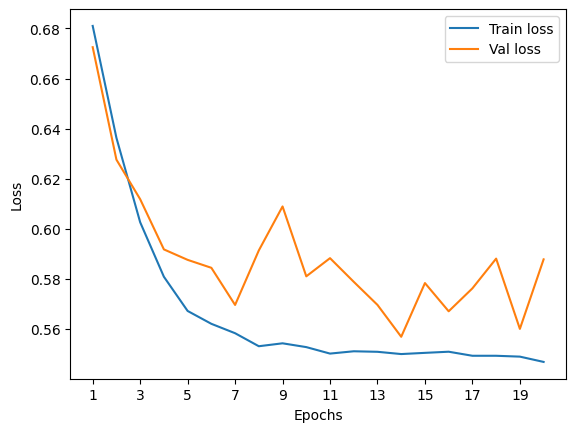

In [109]:
plot_loss(history)